In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import warnings
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import optuna
from collections import Counter
from statsmodels.tsa.stattools import adfuller, kpss
from tqdm import tqdm
from functools import partial, reduce
from datetime import timedelta
from matplotlib.image import imread
warnings.filterwarnings("ignore")

In [2]:
def read_dataset(file):
    if file.split('.')[1]=='csv':
        data = pd.read_csv(file)
    elif file.split('.')[1]=='xlsx':
        data = pd.read_excel(file)
    return data

In [3]:
def make_train_test_splits(X, y, test_split):
    split_size = int(len(X) * (1 - test_split))  
    X_train = X[:split_size]
    y_train = y[:split_size]
    X_test = X[split_size:]
    y_test = y[split_size:]
    return X_train, X_test, y_train, y_test

In [4]:
def time_control_type(train,col):
    if str(train[col].dtypes) not in '[ns]':
        train[col]=pd.to_datetime(train[col])
    return train

In [5]:
def date_sort(data,col):
    data = data.sort_values(by=col)
    return data

In [6]:
def date_column_info(data,image_path=None):
    num_cols = data.select_dtypes(include=['float','int']).columns.tolist()  
    fig = make_subplots(rows=len(num_cols), cols=1, subplot_titles=num_cols)
    for i, col in enumerate(num_cols):
        line_chart = px.line(data, x='date', y=col)
        line = line_chart.data[0]
        fig.add_trace(line, row=i + 1, col=1)
    num_rows = data.shape[1]
    fig.update_xaxes(title_text='Date', row=num_cols, col=1)
    fig.update_layout(showlegend=False, height=150*num_rows, width=1400)
    try:
        image = imread(image_path)
        fig, ax = plt.subplots(figsize=(15, 25))  
        ax.imshow(image)
        ax.axis('off')  
        plt.show()
    except:
        fig.show()

In [7]:
def date_engineering(data,col):
    data['Day'] = data[col].dt.day.astype(str)
    data['Month'] = data[col].dt.month.astype(str)
    data['Year'] = data[col].dt.year.astype(str)         
    data['DayOfWeek'] = data[col].dt.dayofweek.astype(str)
    data['DayOfYear'] = data[col].dt.dayofyear.astype(str)
    data['WeekOfYear'] = data[col].dt.weekofyear.astype(str)
    data['Quarter'] = data[col].dt.quarter.astype(str)
    return data

In [8]:
def frequency_detect(data, selected_datetime):
    dates = data[selected_datetime].unique()
    frequencies = [int(int((dates[x + 1] - dates[x])) / (1000000000)) for x in range(0, len(dates) - 1)]
    time_type = ''
    frequency = list(Counter(frequencies).most_common(1)[0])[0]
    if frequency >= 31536000:
        time_type = 'years' if frequency % 31536000 == 0 else 'quarters'
    elif frequency >= 7948800:
        time_type = 'quarters' if frequency % 7948800 == 0 else 'months'
    elif frequency >= 2592000:
        time_type = 'months' if frequency % 2592000 == 0 else 'weeks'
    elif frequency >= 604800:
        time_type = 'weeks' if frequency % 604800 == 0 else 'days'
    elif frequency >= 86400:
        time_type = 'days' if frequency % 86400 == 0 else 'hours'
    elif frequency >= 3600:
        time_type = 'hours' if frequency % 3600 == 0 else 'minutes'
    elif frequency >= 60:
        time_type = 'minutes' if frequency % 60 == 0 else 'seconds'
    elif frequency >= 1:
        time_type = 'seconds'
    return time_type,frequency

In [9]:
def ADF_Test(data, target, selected_datetime_feature, SignificanceLevel=.05):
    # Dickey-Fuller test:
    data = data.set_index(
        pd.DatetimeIndex(data[selected_datetime_feature]))
    data = data.drop([selected_datetime_feature], axis=1)
    data = data[[target]]
    adfTest = adfuller(data, autolag='AIC')

    pValue = adfTest[1]

    if (pValue < SignificanceLevel):
        isStationary_adf = True
    else:
        isStationary_adf = False

    dataResults = pd.Series(adfTest[0:4],
                           index=['Adata Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
    
    # Add Critical Values
    for key, value in adfTest[4].items():
         dataResults['Critical Value (%s)' % key] = value
    
    print('Augmented Dickey-Fuller Test Results:')
    print(dataResults)
    print(isStationary_adf)
    return isStationary_adf
    
def KPSS_Test(data, target, selected_datetime_feature, trend,SignificanceLevel=.05):
    """
    Regression: This parameter determines the type of regression to be used in calculating the test statistic. The KPSS test applies a regression model to examine the stationarity property of the data. 
    In this model, a component of the data is predicted, and the test statistic is calculated based on the remaining residuals. "c" (constant): This option represents a regression model with a constant component.
    The test examines the stationarity property of the series with this component. "ct" (constant and trend): This option represents a regression model that includes both a constant component and a linear trend component.
    The test assesses the stationarity property of the series with these two components. The nlags parameter specifies the number of lags used in the KPSS test. 
    This parameter determines how many steps back the regression model used in calculating the test statistic looks. The number of lags is a method used to examine the stationarity property of the series.
    If nlags is set to 25, the regression model will be designed to look back 25 steps (25 observations) when calculating the test statistic.
    This means that the test will use the last 25 observations when evaluating the stationarity property of the series.
    """
    data = data.set_index(
        pd.DatetimeIndex(data[selected_datetime_feature]))
    data = data.drop([selected_datetime_feature], axis=1)
    data = data[[target]]
    kpsstest = kpss(data, regression='ct',nlags=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
    for key, value in kpsstest[3].items():
         kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)
    pValue = kpsstest[1]
    if (pValue < SignificanceLevel):
        isStationary_kpss = False
    else:
        isStationary_kpss = True
    print(isStationary_kpss)
    return isStationary_kpss

In [10]:
def editing_index(data, col):
    data = data.set_index(pd.DatetimeIndex(data[col]))
    data = data.drop([col], axis=1)
    return data

In [11]:
def derived_lag_features(data, lag_features, lag_bound=5):
    for col in lag_features:
        for lag in range(1, int(lag_bound) + 1):
            f_name = f'{col}_lag_{lag}'
            data[f_name] = data[col].shift(int(lag))
    return data.loc[:, data.columns.str.contains('_lag_')]

In [12]:
def app_lag_data(data, WINDOW, derived_lag_features_cols):
    data_1 = data.copy()
    data_2 = []
    v = WINDOW + 1
    if v < 7:
        for i in tqdm(range(len(data_1) - int(WINDOW))):
            data_3 = derived_lag_features(data_1[v - int(WINDOW):v + 1], derived_lag_features_cols,
                                             lag_bound=WINDOW).dropna()
            v += 1
            data_2.append(data_3)
    else:
        for i in tqdm(range(len(data_1) - int(WINDOW))):
            data_3 = derived_lag_features(data_1[v - int(WINDOW):v][-6:], derived_lag_features_cols).dropna()
            v += 1
            data_2.append(data_3)
    lagged_data = pd.concat(data_2)
    lagged_data = lagged_data.astype('float32')
    return lagged_data

In [13]:
def derive_features(data, derivation_lagged_cols, win, window_list,time_type, frequency):
    def time_type_detect(time_type):
        if time_type == 'years':
            time_num = 31536000
        elif time_type == 'quarters':
            time_num = 7948800
        elif time_type == 'months':
            time_num = 2592000
        elif time_type == 'weeks':
            time_num = 604800
        elif time_type == 'days':
            time_num = 86400
        elif time_type == 'hours':
            time_num = 3600
        elif time_type == 'minutes':
            time_num = 60
        elif time_type == 'seconds':
            time_num = 1
        return time_num
    functions = {
        'min': lambda x: x.rolling(window=win, min_periods=1).min(),
        'max': lambda x: x.rolling(window=win, min_periods=1).max(),
        'mean': lambda x: x.rolling(window=win, min_periods=1).mean(),
        'std': lambda x: x.rolling(window=win, min_periods=1).std(),
        'median': lambda x: x.rolling(window=win, min_periods=1).median()
    }
    time_num = time_type_detect(time_type)
    for win in window_list:
        for function_name, function in functions.items():
            for j in derivation_lagged_cols:
                data[f'{j}_stat_{function_name}_{int(win * frequency / time_num)}_{time_type}'] = data[[j]].apply(function)
    return data

In [14]:
def app_derived_data(data, derived_lag_features_cols, WINDOW, window_list,time_type, frequency):
    data_1 = data.copy()
    v = int(WINDOW) + 1
    derives = []
    if v < 7:
        for i in tqdm(range(len(data_1) - int(WINDOW))):
            this_derive = derive_features(data_1[v - int(WINDOW):v + 1], derived_lag_features_cols, WINDOW,window_list,time_type,frequency).iloc[-1].to_frame().T
            derives.append(this_derive)
            v += 1
    else:
        for i in tqdm(range(len(data_1) - int(WINDOW))):
            this_derive = derive_features(data_1[v - int(WINDOW):v], derived_lag_features_cols, WINDOW,window_list,time_type,frequency).iloc[-1].to_frame().T
            derives.append(this_derive)
            v += 1
    derived_data = pd.concat(derives)
    derived_data = derived_data.loc[:, derived_data.columns.str.contains('stat_')]
    derived_data = derived_data.astype('float32')
    return derived_data

In [15]:
def app_diff_data(df, window, lagged_data, derived_data, target, time_type):
    data = df.copy()
    lag_data_target_columns = [x for x in lagged_data.columns if target in x]
    derived_diff_inp_column = derived_data[f'{target}_stat_mean_{window}_{time_type}']
    derived_data_target_columns = [x for x in derived_data.columns if target in x and derived_diff_inp_column.name not in x]
    for i in lag_data_target_columns:
        data[f'{target}_diff_{i.replace(target + "_", "", 1)}'] = data[target] - lagged_data[i]
        data[f'{target}_{i.replace(target + "_", "", 1)}_diff_{derived_diff_inp_column.name}'] = lagged_data[
                                                                                                     i] - derived_diff_inp_column
    for k in derived_data_target_columns:
        data[f'{target}_diff_{k.replace(target + "_", "", 1)}'] = data[target] - derived_data[k]
        data[f'{target}_{k.replace(target + "_", "", 1)}_diff_{derived_diff_inp_column.name}'] = derived_data[
                                                                                                     k] - derived_diff_inp_column
    data = data.loc[:, data.columns.str.contains('diff')]
    return data

In [16]:
def merge_data(data, lagged_data, derived_data, diff_data=None):
    list_of_datas = [data, lagged_data, derived_data]
    if not diff_data.empty:
        list_of_datas.append(diff_data)
    merge = partial(pd.merge_asof, left_index=True, right_index=True)
    final_data = reduce(merge, list_of_datas)
    return final_data

In [17]:
def trend_removal_log(data,target_list):
    negative_values = []
    [[negative_values.append({column: x}) for x in range(len(data)) if data[column][x] < 0] for index, column in enumerate(data[target_list])]
    data[target_list] = abs(data[target_list])
    data[target_list] = np.log1p(data[target_list])
    if not negative_values:
        [data.rename({x: f"{x}_log"}, axis=1, inplace=True) for x in data[target_list].columns.tolist()]
        return data
    for i in negative_values:
        for key, value in i.items():
            data[key][value] = data[key][value] * int(-1)
    [data.rename({x: f"{x}_log"}, axis=1, inplace=True) for x in data[target_list].columns.tolist()]
    return data

In [18]:
def split(df,target,horizon):
    X = df.drop([target], axis=1)
    y = df[[target]]
    horizon = int(horizon)
    y = derived_lag_features(y, [target], horizon).dropna()
    X = X.iloc[horizon:]
    return X,y

In [19]:
def get_fold(X,y,fold_number):
    tscv = TimeSeriesSplit(n_splits=fold_number)
    tscv.get_n_splits(X, y)
    cv_partitions = []
    for train_index, val_index in tscv.split(X, y):
        cv_partitions.append({f'train': train_index.tolist(),
                              f'validation': val_index.tolist()})
    return cv_partitions

In [20]:
def pipeline_build(alg,num_cols,cat_cols):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median', fill_value='missing')),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)], remainder='passthrough')

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('algorithm', MultiOutputRegressor(alg))])
    return pipe

In [21]:
def objective(trial,X,y,fold_list,alg,num_cols,cat_cols):   
    params = {
        'learning_rate': trial.suggest_float('learning_rate',0.05, 0.5,step=0.01),
        'n_estimators': trial.suggest_int('n_estimators',10, 3000,step=10),
        'max_bin': trial.suggest_int('max_bin',16, 2048,step=16),
        'subsample': trial.suggest_float('subsample', 0.1, 1,step=0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
    }
    liste = []  
    for i in range(len(fold_list)):
        train_indices = fold_list[i]['train']
        val_indices = fold_list[i]['validation']
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_val = X.iloc[val_indices]                    
        y_val = y.iloc[val_indices]
        alg.set_params(**params)
        pipe = pipeline_build(alg,num_cols,cat_cols)
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        liste.append(rmse)
    print(f'RMSE : {np.mean(liste)}')
    return np.mean(liste)

In [22]:
def metrics_calculate(y_val,y_pred,X_train):
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    rmsle = mean_squared_log_error(y_val, y_pred),
    r2 = r2_score(y_val, y_pred),
    adj_r2 = 1 - (1 - (r2_score(y_val, y_pred))) * (X_train.shape[0] - 1) / (X_train.shape[0] - len(X_train.columns.tolist()) - 1)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    scores = {'RMSE' : rmse,'MAE' : mae,'RMSLE' : rmsle,'R-Squared' : r2,
                  'Adj R-Squared' : adj_r2,'MAPE' : mape}
    return scores

In [23]:
def train_and_visualization(X,y,external_y,external_final_data,fold_list,horizon,num_cols,cat_cols,frequency,alg):
    for i in range(len(fold_list)):
        train_indices = fold_list[i]['train']
        val_indices = fold_list[i]['validation']
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_val = X.iloc[val_indices]                    
        y_val = y.iloc[val_indices]  
        pipe = pipeline_build(alg,num_cols,cat_cols)
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_val)
        external_y_pred = pipe.predict(external_final_data)
        scores = metrics_calculate(y_val,y_pred,X_train)
        external_scores = metrics_calculate(external_y,external_y_pred,external_y)
        print(f"Fold {i + 1} Scores : {scores}")
        print(f"Fold {i + 1} External Scores : {external_scores}")
        model_preds_columns_list = [[f'+{i + 1}_Horizon_time_step'][0] for i in range(horizon)]
        y_pred = pd.DataFrame(y_pred, index=X_val.index,
                                  columns=[model_preds_columns_list])
        external_y_pred = pd.DataFrame(external_y_pred, index=external_final_data.index,
                                  columns=[model_preds_columns_list])
        y_pred_ = y_pred.reset_index()
        y_pred_ = y_pred_.to_numpy().tolist()
        external_y_pred_ = external_y_pred.reset_index()
        external_y_pred_ = external_y_pred_.to_numpy().tolist()
        real_results = []
        pred_results = []
        for k, row in enumerate(y_pred_):
            for distance, value in enumerate(row[1:]):
                real_results.append({
                    "Timestamp":y_pred_[k][0] + timedelta(**{"seconds":(distance+1)*frequency}),
                    "Forecast Distance":distance+1,
                    "Forecast Point":y_pred_[k][0],
                    "Prediction": value})
        y_pred_ = pd.DataFrame(real_results)
        for k, row in enumerate(external_y_pred_):
            for distance, value in enumerate(row[1:]):
                pred_results.append({
                    "Timestamp":external_y_pred_[k][0] + timedelta(**{"seconds":(distance+1)*frequency}),
                    "Forecast Distance":distance+1,
                    "Forecast Point":external_y_pred_[k][0],
                    "Prediction": value})
        external_y_pred_ = pd.DataFrame(pred_results)
        print(f"Train Start-End: {X_train.index[0]} - {X_train.index[-1]}")
        print(f"Validation Start-End: {X_val.index[0]} - {X_val.index[-1]}")
        for k in range(len(y_val.columns.tolist())):
            real_table_name = y_val.iloc[:,k].astype('float32').name.split('lag_')[1]
            # If you want to plot real and predicted data using Plotly Express, you can use the code below with comments disabled.
            """
            y_val_vis = y_val.iloc[:,k].astype('float32')
            y_pred_vis = y_pred.iloc[:,k].astype('float32')
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=y_val.index, y=y_val_vis, mode='lines',name=f'Real Day {real_table_name}',line_color='#247AFD'))
            fig.add_trace(go.Scatter(x=y_val.index, y=y_pred_vis, mode='lines',name=f'Pred Day {real_table_name}',line_color='#ff0000'))
            fig.update_layout(title=f'Test Values And Predictions Fold {i + 1}',
                      xaxis_title='Time',
                      yaxis_title='Horizon Time Steps')
            fig.show()"""
            y_val.iloc[:,k].plot(label = f'Real Day {real_table_name}');
            y_pred.iloc[:,k].plot(label = f'Pred Day {real_table_name}');
            plt.xlabel("Time")
            plt.ylabel("Horizon Time Steps")
            plt.legend()
            plt.figure(figsize=(30, 10))
            plt.show()
            external_y.iloc[:,k].plot(label = f'External Real Day {real_table_name}');
            external_y_pred.iloc[:,k].plot(label = f'External Pred Day {real_table_name}');
            plt.xlabel("Time")
            plt.ylabel("Horizon Time Steps")
            plt.legend()
            plt.figure(figsize=(30, 10))
            plt.show()

In [24]:
train = read_dataset("C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/multiple_time_series/data/raw/DailyDelhiClimateTrain.csv")
test = read_dataset('C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/multiple_time_series/data/external/DailyDelhiClimateTest.csv')

In [25]:
train = train[:-1]

In [26]:
train

date   meantemp   humidity  wind_speed  meanpressure
0     2013-01-01  10.000000  84.500000    0.000000   1015.666667
1     2013-01-02   7.400000  92.000000    2.980000   1017.800000
2     2013-01-03   7.166667  87.000000    4.633333   1018.666667
3     2013-01-04   8.666667  71.333333    1.233333   1017.166667
4     2013-01-05   6.000000  86.833333    3.700000   1016.500000
...          ...        ...        ...         ...           ...
1456  2016-12-27  16.850000  67.550000    8.335000   1017.200000
1457  2016-12-28  17.217391  68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095  87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238  89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632  87.000000    7.325000   1016.100000

[1461 rows x 5 columns]

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1461 non-null   object 
 1   meantemp      1461 non-null   float64
 2   humidity      1461 non-null   float64
 3   wind_speed    1461 non-null   float64
 4   meanpressure  1461 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [28]:
test

date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   1018.277778
2    2017-01-03  17.111111  81.888889    4.016667   1018.333333
3    2017-01-04  18.700000  70.050000    4.545000   1015.700000
4    2017-01-05  18.388889  74.944444    3.300000   1014.333333
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 5 columns]

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [30]:
timestamp_column = 'date'
target = 'meantemp' 

In [31]:
train=time_control_type(train,timestamp_column)

In [32]:
test=time_control_type(test,timestamp_column)

In [33]:
train = date_sort(train,timestamp_column)
test = date_sort(test,timestamp_column)

In [34]:
image_pth='C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/multiple_time_series/images/'

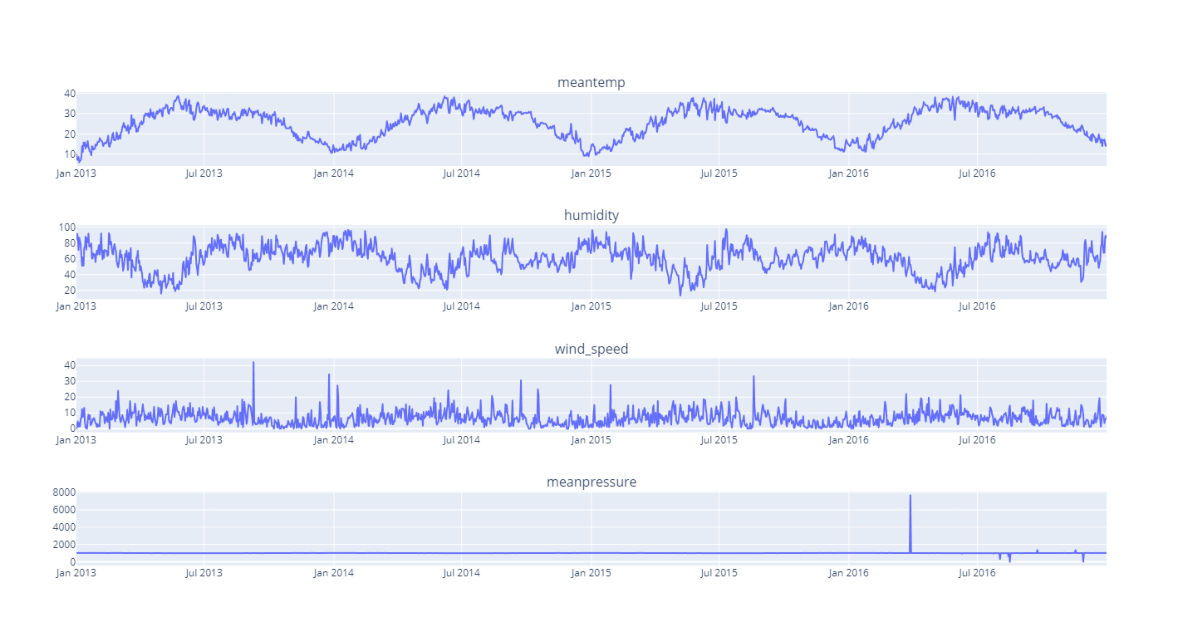

In [35]:
date_column_info(train,image_path=image_pth+'train_date_column_info.png')

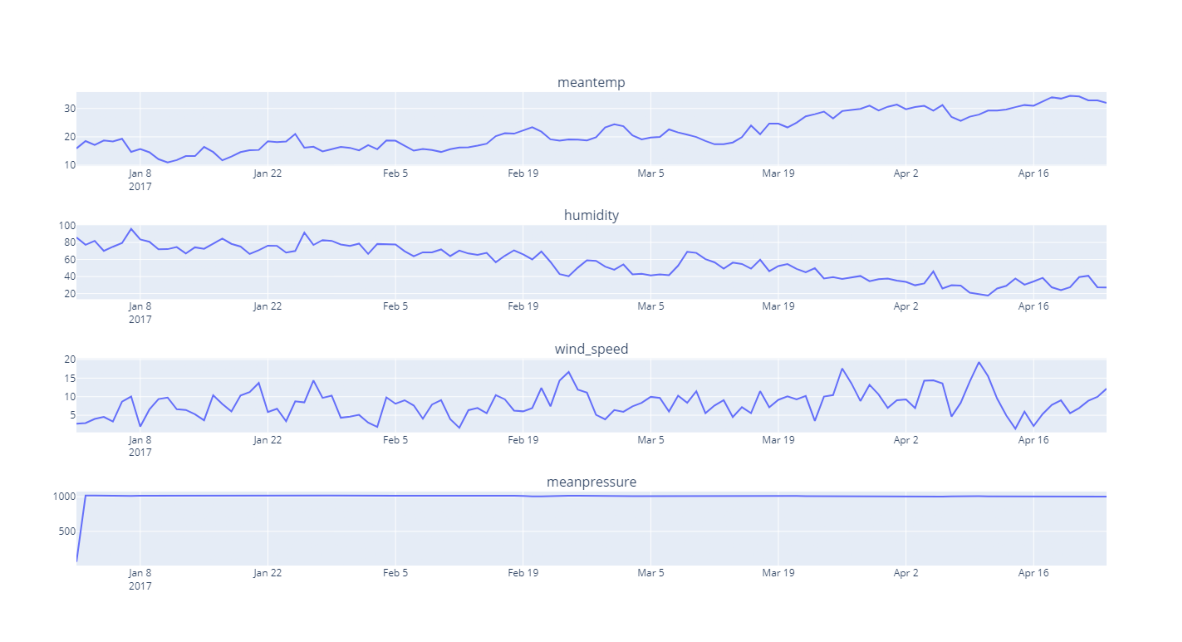

In [36]:
date_column_info(test,image_path=image_pth+'test_date_column_info.png')

In [37]:
train = date_engineering(train,timestamp_column)
test = date_engineering(test,timestamp_column)

In [38]:
time_type,frequency = frequency_detect(train,timestamp_column)

In [39]:
train.dtypes

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
Day                     object
Month                   object
Year                    object
DayOfWeek               object
DayOfYear               object
WeekOfYear              object
Quarter                 object
dtype: object

In [40]:
isStationary_adf = ADF_Test(train,target,timestamp_column)

Augmented Dickey-Fuller Test Results:
Adata Test Statistic      -2.155565
P-Value                    0.222766
# Lags Used               10.000000
# Observations Used     1450.000000
Critical Value (1%)       -3.434868
Critical Value (5%)       -2.863535
Critical Value (10%)      -2.567832
dtype: float64
False


In [41]:
# trend yıllık olduğu için 365 verilecek
isStationary_kpss = KPSS_Test(train,target,timestamp_column,trend=365)

Test Statistic             0.378829
p-value                    0.010000
#Lags Used               365.000000
Critical Value (10%)       0.119000
Critical Value (5%)        0.146000
Critical Value (2.5%)      0.176000
Critical Value (1%)        0.216000
dtype: float64
False


In [42]:
train = editing_index(train,timestamp_column)
test = editing_index(test,timestamp_column)

In [43]:
train

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2013-01-01  10.000000  84.500000    0.000000   1015.666667   1     1  2013   
2013-01-02   7.400000  92.000000    2.980000   1017.800000   2     1  2013   
2013-01-03   7.166667  87.000000    4.633333   1018.666667   3     1  2013   
2013-01-04   8.666667  71.333333    1.233333   1017.166667   4     1  2013   
2013-01-05   6.000000  86.833333    3.700000   1016.500000   5     1  2013   
...               ...        ...         ...           ...  ..   ...   ...   
2016-12-27  16.850000  67.550000    8.335000   1017.200000  27    12  2016   
2016-12-28  17.217391  68.043478    3.547826   1015.565217  28    12  2016   
2016-12-29  15.238095  87.857143    6.000000   1016.904762  29    12  2016   
2016-12-30  14.095238  89.666667    6.266667   1017.904762  30    12  2016   
2016-12-31  15.052632  87.000000    7.325000   1016.100000  31    12  2016   

           DayOfWeek DayOfYear WeekOfYear Quarter  
date                                               
2013-01-01         1         1          1       1  
2013-01-02         2         2          1       1  
2013-01-03         3         3          1       1  
2013-01-04         4         4          1       1  
2013-01-05         5         5          1       1  
...              ...       ...        ...     ...  
2016-12-27         1       362         52       4  
2016-12-28         2       363         52       4  
2016-12-29         3       364         52       4  
2016-12-30         4       365         52       4  
2016-12-31         5       366         52       4  

[1461 rows x 11 columns]

In [44]:
window = 365

In [45]:
test_day = test.index[0] - timedelta(days=window)

In [46]:
test_day

Timestamp('2016-01-02 00:00:00')

In [47]:
external_data = pd.concat([train[train.index>=test_day],test])

In [48]:
external_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2016-01-02  14.000000  75.875000    2.087500   1021.000000   2     1  2016   
2016-01-03  14.375000  74.750000    5.112500   1018.500000   3     1  2016   
2016-01-04  15.750000  77.125000    0.000000   1017.625000   4     1  2016   
2016-01-05  15.833333  88.833333    0.616667   1017.000000   5     1  2016   
2016-01-06  17.375000  81.625000    2.312500   1016.500000   6     1  2016   
...               ...        ...         ...           ...  ..   ...   ...   
2017-04-20  34.500000  27.500000    5.562500    998.625000  20     4  2017   
2017-04-21  34.250000  39.375000    6.962500    999.875000  21     4  2017   
2017-04-22  32.900000  40.900000    8.890000   1001.600000  22     4  2017   
2017-04-23  32.875000  27.500000    9.962500   1002.125000  23     4  2017   
2017-04-24  32.000000  27.142857   12.157143   1004.142857  24     4  2017   

           DayOfWeek DayOfYear WeekOfYear Quarter  
date                                               
2016-01-02         5         2         53       1  
2016-01-03         6         3         53       1  
2016-01-04         0         4          1       1  
2016-01-05         1         5          1       1  
2016-01-06         2         6          1       1  
...              ...       ...        ...     ...  
2017-04-20         3       110         16       2  
2017-04-21         4       111         16       2  
2017-04-22         5       112         16       2  
2017-04-23         6       113         16       2  
2017-04-24         0       114         17       2  

[479 rows x 11 columns]

In [49]:
num_cols = train.select_dtypes(include=['float','int']).columns.tolist() 
cat_cols = train.select_dtypes(exclude=['float','int']).columns.tolist()

In [50]:
lagged_data = app_lag_data(train,window,num_cols)

100%|██████████| 1096/1096 [00:06<00:00, 165.65it/s]


In [51]:
lagged_data

meantemp_lag_1  meantemp_lag_2  meantemp_lag_3  meantemp_lag_4  \
date                                                                         
2014-01-01       14.500000       12.375000       10.571428       10.875000   
2014-01-02       13.375000       14.500000       12.375000       10.571428   
2014-01-03       11.000000       13.375000       14.500000       12.375000   
2014-01-04       12.500000       11.000000       13.375000       14.500000   
2014-01-05       12.875000       12.500000       11.000000       13.375000   
...                    ...             ...             ...             ...   
2016-12-27       17.142857       14.000000       17.318182       15.550000   
2016-12-28       16.850000       17.142857       14.000000       17.318182   
2016-12-29       17.217392       16.850000       17.142857       14.000000   
2016-12-30       15.238095       17.217392       16.850000       17.142857   
2016-12-31       14.095238       15.238095       17.217392       16.850000   

            meantemp_lag_5  humidity_lag_1  humidity_lag_2  humidity_lag_3  \
date                                                                         
2014-01-01       11.875000       89.375000       79.500000       69.428574   
2014-01-02       10.875000       89.625000       89.375000       79.500000   
2014-01-03       10.571428       78.375000       89.625000       89.375000   
2014-01-04       12.375000       74.875000       78.375000       89.625000   
2014-01-05       14.500000       88.125000       74.875000       78.375000   
...                    ...             ...             ...             ...   
2016-12-27       17.285715       74.857140       94.300003       78.636360   
2016-12-28       15.550000       67.550003       74.857140       94.300003   
2016-12-29       17.318182       68.043480       67.550003       74.857140   
2016-12-30       14.000000       87.857140       68.043480       67.550003   
2016-12-31       17.142857       89.666664       87.857140       68.043480   

            humidity_lag_4  humidity_lag_5  wind_speed_lag_1  \
date                                                           
2014-01-01       70.000000       79.875000          4.862500   
2014-01-02       69.428574       70.000000          7.650000   
2014-01-03       79.500000       69.428574          8.100000   
2014-01-04       89.375000       79.500000          5.325000   
2014-01-05       89.625000       89.375000          1.162500   
...                    ...             ...               ...   
2016-12-27       74.699997       57.857143          8.784210   
2016-12-28       78.636360       74.699997          8.335000   
2016-12-29       94.300003       78.636360          3.547826   
2016-12-30       74.857140       94.300003          6.000000   
2016-12-31       67.550003       74.857140          6.266667   

            wind_speed_lag_2  wind_speed_lag_3  wind_speed_lag_4  \
date                                                               
2014-01-01          6.475000          5.325000          5.325000   
2014-01-02          4.862500          6.475000          5.325000   
2014-01-03          7.650000          4.862500          6.475000   
2014-01-04          8.100000          7.650000          4.862500   
2014-01-05          5.325000          8.100000          7.650000   
...                      ...               ...               ...   
2016-12-27          9.085000          5.236363          1.205000   
2016-12-28          8.784210          9.085000          5.236363   
2016-12-29          8.335000          8.784210          9.085000   
2016-12-30          3.547826          8.335000          8.784210   
2016-12-31          6.000000          3.547826          8.335000   

            wind_speed_lag_5  meanpressure_lag_1  meanpressure_lag_2  \
date                                                                   
2014-01-01          1.162500         1020.500000         1018.125000   
2014-01-02          5.325000         1021.000000

In [52]:
external_lagged_data = app_lag_data(external_data,window,num_cols)

100%|██████████| 114/114 [00:00<00:00, 166.81it/s]


In [53]:
external_lagged_data

meantemp_lag_1  meantemp_lag_2  meantemp_lag_3  meantemp_lag_4  \
date                                                                         
2017-01-01       15.052631       14.095238       15.238095       17.217392   
2017-01-02       15.913043       15.052631       14.095238       15.238095   
2017-01-03       18.500000       15.913043       15.052631       14.095238   
2017-01-04       17.111111       18.500000       15.913043       15.052631   
2017-01-05       18.700001       17.111111       18.500000       15.913043   
...                    ...             ...             ...             ...   
2017-04-20       33.500000       34.000000       32.555557       31.000000   
2017-04-21       34.500000       33.500000       34.000000       32.555557   
2017-04-22       34.250000       34.500000       33.500000       34.000000   
2017-04-23       32.900002       34.250000       34.500000       33.500000   
2017-04-24       32.875000       32.900002       34.250000       34.500000   

            meantemp_lag_5  humidity_lag_1  humidity_lag_2  humidity_lag_3  \
date                                                                         
2017-01-01       16.850000       87.000000       89.666664       87.857140   
2017-01-02       17.217392       85.869568       87.000000       89.666664   
2017-01-03       15.238095       77.222221       85.869568       87.000000   
2017-01-04       14.095238       81.888885       77.222221       85.869568   
2017-01-05       15.052631       70.050003       81.888885       77.222221   
...                    ...             ...             ...             ...   
2017-04-20       31.222221       24.125000       27.333334       38.444443   
2017-04-21       31.000000       27.500000       24.125000       27.333334   
2017-04-22       32.555557       39.375000       27.500000       24.125000   
2017-04-23       34.000000       40.900002       39.375000       27.500000   
2017-04-24       33.500000       27.500000       40.900002       39.375000   

            humidity_lag_4  humidity_lag_5  wind_speed_lag_1  \
date                                                           
2017-01-01       68.043480       67.550003          7.325000   
2017-01-02       87.857140       68.043480          2.743478   
2017-01-03       89.666664       87.857140          2.894444   
2017-01-04       87.000000       89.666664          4.016667   
2017-01-05       85.869568       87.000000          4.545000   
...                    ...             ...               ...   
2017-04-20       34.250000       30.444445          9.025000   
2017-04-21       38.444443       34.250000          5.562500   
2017-04-22       27.333334       38.444443          6.962500   
2017-04-23       24.125000       27.333334          8.890000   
2017-04-24       27.500000       24.125000          9.962500   

            wind_speed_lag_2  wind_speed_lag_3  wind_speed_lag_4  \
date                                                               
2017-01-01          6.266667          6.000000          3.547826   
2017-01-02          7.325000          6.266667          6.000000   
2017-01-03          2.743478          7.325000          6.266667   
2017-01-04          2.894444          2.743478          7.325000   
2017-01-05          4.016667          2.894444          2.743478   
...                      ...               ...               ...   
2017-04-20          7.811111          5.366667          2.100000   
2017-04-21          9.025000          7.811111          5.366667   
2017-04-22          5.562500          9.025000          7.811111   
2017-04-23          6.962500          5.562500          9.025000   
2017-04-24          8.890000          6.962500          5.562500   

            wind_speed_lag_5  meanpressure_lag_1  meanpressure_lag_2  \
date                                                                   
2017-01-01          8.335000         1016.099976         1017.904785   
2017-01-02          3.547826           59.000000

In [54]:
window_list = [365,180,90]

In [55]:
derived_data = app_derived_data(train,num_cols,window,window_list,time_type,frequency)

100%|██████████| 1096/1096 [01:06<00:00, 16.38it/s]


In [56]:
derived_data

meantemp_stat_min_365_days  humidity_stat_min_365_days  \
2014-01-01                      6.0000                   15.857142   
2014-01-02                      6.0000                   15.857142   
2014-01-03                      6.0000                   15.857142   
2014-01-04                      6.0000                   15.857142   
2014-01-05                      7.0000                   15.857142   
...                                ...                         ...   
2016-12-27                     11.1875                   18.466667   
2016-12-28                     11.1875                   18.466667   
2016-12-29                     11.1875                   18.466667   
2016-12-30                     11.1875                   18.466667   
2016-12-31                     11.1875                   18.466667   

            wind_speed_stat_min_365_days  meanpressure_stat_min_365_days  \
2014-01-01                           0.0                      993.250000   
2014-01-02                           0.0                      993.250000   
2014-01-03                           0.0                      993.250000   
2014-01-04                           0.0                      993.250000   
2014-01-05                           0.0                      993.250000   
...                                  ...                             ...   
2016-12-27                           0.0                       -3.041667   
2016-12-28                           0.0                       -3.041667   
2016-12-29                           0.0                       -3.041667   
2016-12-30                           0.0                       -3.041667   
2016-12-31                           0.0                       -3.041667   

            meantemp_stat_max_365_days  humidity_stat_max_365_days  \
2014-01-01                   38.714287                   94.000000   
2014-01-02                   38.714287                   94.000000   
2014-01-03                   38.714287                   94.000000   
2014-01-04                   38.714287                   94.000000   
2014-01-05                   38.714287                   94.000000   
...                                ...                         ...   
2016-12-27                   38.272728                   94.300003   
2016-12-28                   38.272728                   94.300003   
2016-12-29                   38.272728                   94.300003   
2016-12-30                   38.272728                   94.300003   
2016-12-31                   38.272728                   94.300003   

            wind_speed_stat_max_365_days  meanpressure_stat_max_365_days  \
2014-01-01                     42.220001                     1021.799988   
2014-01-02                     42.220001                     1021.799988   
2014-01-03                     42.220001                     1021.799988   
2014-01-04                     42.220001                     1021.799988   
2014-01-05                     42.220001                     1021.799988   
...                                  ...                             ...   
2016-12-27                     22.100000                     7679.333496   
2016-12-28                     22.100000                     7679.333496   
2016-12-29                     22.100000                     7679.333496   
2016-12-30                     22.100000                     7679.333496   
2016-12-31                     22.100000                     7679.333496   

            meantemp_stat_mean_365_days  humidity_stat_mean_365_days  ...  \
2014-01-01                    24.800741                    63.060333  ...   
2014-01-02                    24.810604                    63.023003  ...   
2014-01-03                    24.825214                    62.989784  ...   
2014-01-04                    24.836744                    63.035789  ...   
2014-01-05                    24.854210                    63.041725  ...   
...                                 ...   

In [57]:
external_derived_data = app_derived_data(external_data,num_cols,window,window_list,time_type,frequency)

100%|██████████| 114/114 [00:06<00:00, 16.41it/s]


In [58]:
external_derived_data

meantemp_stat_min_365_days  humidity_stat_min_365_days  \
2017-01-01                     11.1875                   18.466667   
2017-01-02                     11.1875                   18.466667   
2017-01-03                     11.1875                   18.466667   
2017-01-04                     11.1875                   18.466667   
2017-01-05                     11.1875                   18.466667   
...                                ...                         ...   
2017-04-20                     11.0000                   17.750000   
2017-04-21                     11.0000                   17.750000   
2017-04-22                     11.0000                   17.750000   
2017-04-23                     11.0000                   17.750000   
2017-04-24                     11.0000                   17.750000   

            wind_speed_stat_min_365_days  meanpressure_stat_min_365_days  \
2017-01-01                         0.000                       -3.041667   
2017-01-02                         0.000                       -3.041667   
2017-01-03                         0.000                       -3.041667   
2017-01-04                         0.000                       -3.041667   
2017-01-05                         0.000                       -3.041667   
...                                  ...                             ...   
2017-04-20                         0.925                       -3.041667   
2017-04-21                         0.925                       -3.041667   
2017-04-22                         0.925                       -3.041667   
2017-04-23                         0.925                       -3.041667   
2017-04-24                         0.925                       -3.041667   

            meantemp_stat_max_365_days  humidity_stat_max_365_days  \
2017-01-01                   38.272728                   94.300003   
2017-01-02                   38.272728                   94.300003   
2017-01-03                   38.272728                   94.300003   
2017-01-04                   38.272728                   94.300003   
2017-01-05                   38.272728                   94.300003   
...                                ...                         ...   
2017-04-20                   38.272728                   95.833336   
2017-04-21                   38.272728                   95.833336   
2017-04-22                   38.272728                   95.833336   
2017-04-23                   38.272728                   95.833336   
2017-04-24                   38.272728                   95.833336   

            wind_speed_stat_max_365_days  meanpressure_stat_max_365_days  \
2017-01-01                      22.10000                     7679.333496   
2017-01-02                      22.10000                     7679.333496   
2017-01-03                      22.10000                     7679.333496   
2017-01-04                      22.10000                     7679.333496   
2017-01-05                      22.10000                     7679.333496   
...                                  ...                             ...   
2017-04-20                      21.30625                     1352.615356   
2017-04-21                      21.30625                     1352.615356   
2017-04-22                      21.30625                     1352.615356   
2017-04-23                      21.30625                     1352.615356   
2017-04-24                      21.30625                     1352.615356   

            meantemp_stat_mean_365_days  humidity_stat_mean_365_days  ...  \
2017-01-01                    27.142557                    58.730446  ...   
2017-01-02                    27.153858                    58.737217  ...   
2017-01-03                    27.157587                    58.750271  ...   
2017-01-04                    27.165442                    58.698811  ...   
2017-01-05                    27.168219                    58.680508  ...   
...                                 ...   

In [59]:
if int(window) < int(6):
    train = train.iloc[int(window) + 1:]
else:
    train = train.iloc[int(window):]

In [60]:
if not isStationary_kpss:
    diff_data = app_diff_data(train,window,lagged_data,derived_data,target,time_type)
    external_diff_data = app_diff_data(external_data[window:],window,external_lagged_data,external_derived_data,target,time_type)

In [61]:
final_data = merge_data(train,lagged_data,derived_data,diff_data)
external_final_data = merge_data(external_data[window:],external_lagged_data,external_derived_data,external_diff_data)

In [62]:
final_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2014-01-01  13.375000  89.625000    7.650000   1021.000000   1     1  2014   
2014-01-02  11.000000  78.375000    8.100000   1020.250000   2     1  2014   
2014-01-03  12.500000  74.875000    5.325000   1017.750000   3     1  2014   
2014-01-04  12.875000  88.125000    1.162500   1016.250000   4     1  2014   
2014-01-05  12.375000  89.000000    0.462500   1014.500000   5     1  2014   
...               ...        ...         ...           ...  ..   ...   ...   
2016-12-27  16.850000  67.550000    8.335000   1017.200000  27    12  2016   
2016-12-28  17.217391  68.043478    3.547826   1015.565217  28    12  2016   
2016-12-29  15.238095  87.857143    6.000000   1016.904762  29    12  2016   
2016-12-30  14.095238  89.666667    6.266667   1017.904762  30    12  2016   
2016-12-31  15.052632  87.000000    7.325000   1016.100000  31    12  2016   

           DayOfWeek DayOfYear WeekOfYear  ... meantemp_diff_stat_min_90_days  \
date                                       ...                                  
2014-01-01         2         1          1  ...                       2.803572   
2014-01-02         3         2          1  ...                       0.428572   
2014-01-03         4         3          1  ...                       1.928572   
2014-01-04         5         4          1  ...                       2.303572   
2014-01-05         6         5          1  ...                       1.803572   
...              ...       ...        ...  ...                            ...   
2016-12-27         1       362         52  ...                       2.850000   
2016-12-28         2       363         52  ...                       3.217391   
2016-12-29         3       364         52  ...                       1.238095   
2016-12-30         4       365         52  ...                       0.095238   
2016-12-31         5       366         52  ...                       1.052632   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days  \
date                                                                     
2014-01-01                                         -14.229313            
2014-01-02                                         -14.239176            
2014-01-03                                         -14.253786            
2014-01-04                                         -14.265316            
2014-01-05                                         -14.282782            
...                                                       ...            
2016-12-27                                         -13.137278            
2016-12-28                                         -13.139585            
2016-12-29                                         -13.138868            
2016-12-30                                         -13.136389            
2016-12-31                                         -13.137316            

            meantemp_diff_stat_max_90_days  \
date                                         
2014-01-01                      -17.458334   
2014-01-02                      -19.833334   
2014-01-03                      -18.333334   
2014-01-04                      -17.958334   
2014-01-05                      -18.458334   
...                                    ...   
2016-12-27                      -16.419230   
2016-12-28                      -16.051839   
2016-12-29                      -18.031135   
2016-12-30                      -19.173992   
2016-12-31                      -18.216598   

            meantemp_stat_max_90_days_diff_meantemp_stat_mean_365_days  \
date                                                                     
2014-01-01                                           6.032593            
2014-01-02                                           6.022730            
2014-01-03                                           6.008120            
2014-01-04  

In [63]:
external_final_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2017-01-01  15.913043  85.869565    2.743478     59.000000   1     1  2017   
2017-01-02  18.500000  77.222222    2.894444   1018.277778   2     1  2017   
2017-01-03  17.111111  81.888889    4.016667   1018.333333   3     1  2017   
2017-01-04  18.700000  70.050000    4.545000   1015.700000   4     1  2017   
2017-01-05  18.388889  74.944444    3.300000   1014.333333   5     1  2017   
...               ...        ...         ...           ...  ..   ...   ...   
2017-04-20  34.500000  27.500000    5.562500    998.625000  20     4  2017   
2017-04-21  34.250000  39.375000    6.962500    999.875000  21     4  2017   
2017-04-22  32.900000  40.900000    8.890000   1001.600000  22     4  2017   
2017-04-23  32.875000  27.500000    9.962500   1002.125000  23     4  2017   
2017-04-24  32.000000  27.142857   12.157143   1004.142857  24     4  2017   

           DayOfWeek DayOfYear WeekOfYear  ... meantemp_diff_stat_min_90_days  \
date                                       ...                                  
2017-01-01         6         1         52  ...                       1.913043   
2017-01-02         0         2          1  ...                       4.500000   
2017-01-03         1         3          1  ...                       3.111111   
2017-01-04         2         4          1  ...                       4.700000   
2017-01-05         3         5          1  ...                       4.388889   
...              ...       ...        ...  ...                            ...   
2017-04-20         3       110         16  ...                      19.833333   
2017-04-21         4       111         16  ...                      19.583333   
2017-04-22         5       112         16  ...                      18.233333   
2017-04-23         6       113         16  ...                      18.208333   
2017-04-24         0       114         17  ...                      17.333333   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days  \
date                                                                     
2017-01-01                                         -13.142557            
2017-01-02                                         -13.153858            
2017-01-03                                         -13.157587            
2017-01-04                                         -13.165442            
2017-01-05                                         -13.168219            
...                                                       ...            
2017-04-20                                         -12.179582            
2017-04-21                                         -12.180266            
2017-04-22                                         -12.179309            
2017-04-23                                         -12.181933            
2017-04-24                                         -12.183818            

            meantemp_diff_stat_max_90_days  \
date                                         
2017-01-01                      -15.046956   
2017-01-02                      -12.459999   
2017-01-03                      -13.848888   
2017-01-04                      -12.259999   
2017-01-05                      -12.531111   
...                                    ...   
2017-04-20                        0.000000   
2017-04-21                       -0.250000   
2017-04-22                       -1.600000   
2017-04-23                       -1.625000   
2017-04-24                       -2.500000   

            meantemp_stat_max_90_days_diff_meantemp_stat_mean_365_days  \
date                                                                     
2017-01-01                                           3.817442            
2017-01-02                                           3.806141            
2017-01-03                                           3.802412            
2017-01-04  

In [64]:
if not isStationary_adf:
    target_list = [x for x in final_data.columns.tolist() if x.startswith(target) and x != target]
    final_data = trend_removal_log(final_data,target_list)
    external_final_data = trend_removal_log(external_final_data,target_list)

In [65]:
final_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2014-01-01  13.375000  89.625000    7.650000   1021.000000   1     1  2014   
2014-01-02  11.000000  78.375000    8.100000   1020.250000   2     1  2014   
2014-01-03  12.500000  74.875000    5.325000   1017.750000   3     1  2014   
2014-01-04  12.875000  88.125000    1.162500   1016.250000   4     1  2014   
2014-01-05  12.375000  89.000000    0.462500   1014.500000   5     1  2014   
...               ...        ...         ...           ...  ..   ...   ...   
2016-12-27  16.850000  67.550000    8.335000   1017.200000  27    12  2016   
2016-12-28  17.217391  68.043478    3.547826   1015.565217  28    12  2016   
2016-12-29  15.238095  87.857143    6.000000   1016.904762  29    12  2016   
2016-12-30  14.095238  89.666667    6.266667   1017.904762  30    12  2016   
2016-12-31  15.052632  87.000000    7.325000   1016.100000  31    12  2016   

           DayOfWeek DayOfYear WeekOfYear  ...  \
date                                       ...   
2014-01-01         2         1          1  ...   
2014-01-02         3         2          1  ...   
2014-01-03         4         3          1  ...   
2014-01-04         5         4          1  ...   
2014-01-05         6         5          1  ...   
...              ...       ...        ...  ...   
2016-12-27         1       362         52  ...   
2016-12-28         2       363         52  ...   
2016-12-29         3       364         52  ...   
2016-12-30         4       365         52  ...   
2016-12-31         5       366         52  ...   

           meantemp_diff_stat_min_90_days_log  \
date                                            
2014-01-01                           1.335941   
2014-01-02                           0.356675   
2014-01-03                           1.074515   
2014-01-04                           1.195004   
2014-01-05                           1.030894   
...                                       ...   
2016-12-27                           1.348073   
2016-12-28                           1.439217   
2016-12-29                           0.805625   
2016-12-30                           0.090972   
2016-12-31                           0.719123   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days_log  \
date                                                                         
2014-01-01                                          -2.723222                
2014-01-02                                          -2.723870                
2014-01-03                                          -2.724828                
2014-01-04                                          -2.725583                
2014-01-05                                          -2.726727                
...                                                       ...                
2016-12-27                                          -2.648815                
2016-12-28                                          -2.648978                
2016-12-29                                          -2.648928                
2016-12-30                                          -2.648752                
2016-12-31                                          -2.648818                

            meantemp_diff_stat_max_90_days_log  \
date                                             
2014-01-01                           -2.915516   
2014-01-02                           -3.036554   
2014-01-03                           -2.961831   
2014-01-04                           -2.942244   
2014-01-05                           -2.968275   
...                                        ...   
2016-12-27                           -2.857575   
2016-12-28                           -2.836258   
2016-12-29                           -2.946076   
2016-12-30                           -3.004394   
2016-12-31                           -2.955774   

            meantemp_stat_max_90_days_diff_

In [66]:
external_final_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2017-01-01  15.913043  85.869565    2.743478     59.000000   1     1  2017   
2017-01-02  18.500000  77.222222    2.894444   1018.277778   2     1  2017   
2017-01-03  17.111111  81.888889    4.016667   1018.333333   3     1  2017   
2017-01-04  18.700000  70.050000    4.545000   1015.700000   4     1  2017   
2017-01-05  18.388889  74.944444    3.300000   1014.333333   5     1  2017   
...               ...        ...         ...           ...  ..   ...   ...   
2017-04-20  34.500000  27.500000    5.562500    998.625000  20     4  2017   
2017-04-21  34.250000  39.375000    6.962500    999.875000  21     4  2017   
2017-04-22  32.900000  40.900000    8.890000   1001.600000  22     4  2017   
2017-04-23  32.875000  27.500000    9.962500   1002.125000  23     4  2017   
2017-04-24  32.000000  27.142857   12.157143   1004.142857  24     4  2017   

           DayOfWeek DayOfYear WeekOfYear  ...  \
date                                       ...   
2017-01-01         6         1         52  ...   
2017-01-02         0         2          1  ...   
2017-01-03         1         3          1  ...   
2017-01-04         2         4          1  ...   
2017-01-05         3         5          1  ...   
...              ...       ...        ...  ...   
2017-04-20         3       110         16  ...   
2017-04-21         4       111         16  ...   
2017-04-22         5       112         16  ...   
2017-04-23         6       113         16  ...   
2017-04-24         0       114         17  ...   

           meantemp_diff_stat_min_90_days_log  \
date                                            
2017-01-01                           1.069198   
2017-01-02                           1.704748   
2017-01-03                           1.413693   
2017-01-04                           1.740466   
2017-01-05                           1.684339   
...                                       ...   
2017-04-20                           3.036554   
2017-04-21                           3.024482   
2017-04-22                           2.956645   
2017-04-23                           2.955344   
2017-04-24                           2.908721   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days_log  \
date                                                                         
2017-01-01                                          -2.649189                
2017-01-02                                          -2.649987                
2017-01-03                                          -2.650251                
2017-01-04                                          -2.650805                
2017-01-05                                          -2.651001                
...                                                       ...                
2017-04-20                                          -2.578669                
2017-04-21                                          -2.578721                
2017-04-22                                          -2.578648                
2017-04-23                                          -2.578847                
2017-04-24                                          -2.578990                

            meantemp_diff_stat_max_90_days_log  \
date                                             
2017-01-01                           -2.775519   
2017-01-02                           -2.599722   
2017-01-03                           -2.697925   
2017-01-04                           -2.584752   
2017-01-05                           -2.604992   
...                                        ...   
2017-04-20                            0.000000   
2017-04-21                           -0.223144   
2017-04-22                           -0.955511   
2017-04-23                           -0.965081   
2017-04-24                           -1.252763   

            meantemp_stat_max_90_days_diff_

In [67]:
horizon = 7
X,y = split(final_data,target,horizon)

In [68]:
X

humidity  wind_speed  meanpressure Day Month  Year DayOfWeek  \
date                                                                        
2014-01-08  76.875000    1.850000   1017.875000   8     1  2014         2   
2014-01-09  83.000000    1.233333   1017.000000   9     1  2014         3   
2014-01-10  85.375000    0.000000   1016.625000  10     1  2014         4   
2014-01-11  82.625000    6.725000   1019.625000  11     1  2014         5   
2014-01-12  80.875000    3.250000   1020.750000  12     1  2014         6   
...               ...         ...           ...  ..   ...   ...       ...   
2016-12-27  67.550000    8.335000   1017.200000  27    12  2016         1   
2016-12-28  68.043478    3.547826   1015.565217  28    12  2016         2   
2016-12-29  87.857143    6.000000   1016.904762  29    12  2016         3   
2016-12-30  89.666667    6.266667   1017.904762  30    12  2016         4   
2016-12-31  87.000000    7.325000   1016.100000  31    12  2016         5   

           DayOfYear WeekOfYear Quarter  ...  \
date                                     ...   
2014-01-08         8          2       1  ...   
2014-01-09         9          2       1  ...   
2014-01-10        10          2       1  ...   
2014-01-11        11          2       1  ...   
2014-01-12        12          2       1  ...   
...              ...        ...     ...  ...   
2016-12-27       362         52       4  ...   
2016-12-28       363         52       4  ...   
2016-12-29       364         52       4  ...   
2016-12-30       365         52       4  ...   
2016-12-31       366         52       4  ...   

            meantemp_diff_stat_min_90_days_log  \
date                                             
2014-01-08                            0.834461   
2014-01-09                            1.182311   
2014-01-10                            1.030894   
2014-01-11                            0.937493   
2014-01-12                            1.195004   
...                                        ...   
2016-12-27                            1.348073   
2016-12-28                            1.439217   
2016-12-29                            0.805625   
2016-12-30                            0.090972   
2016-12-31                            0.719123   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days_log  \
date                                                                         
2014-01-08                                          -2.728981                
2014-01-09                                          -2.728772                
2014-01-10                                          -2.729018                
2014-01-11                                          -2.728376                
2014-01-12                                          -2.728175                
...                                                       ...                
2016-12-27                                          -2.648815                
2016-12-28                                          -2.648978                
2016-12-29                                          -2.648928                
2016-12-30                                          -2.648752                
2016-12-31                                          -2.648818                

            meantemp_diff_stat_max_90_days_log  \
date                                             
2014-01-08                           -2.828792   
2014-01-09                           -2.770503   
2014-01-10                           -2.798805   
2014-01-11                           -2.813911   
2014-01-12                           -2.767890   
...                                        ...   
2016-12-27                           -2.857575   
2016-12-28                           -2.836258   
2016-12-29                           -2.946076   
2016-12-30                           -3.004394   
2016-12-31                           -2.955774   

            meantemp_stat_max_90_days_diff_meantemp_stat_mean_365_day

In [69]:
y

meantemp_lag_1  meantemp_lag_2  meantemp_lag_3  meantemp_lag_4  \
date                                                                         
2014-01-08       12.142857       11.428571       12.375000       12.875000   
2014-01-09       11.875000       12.142857       11.428571       12.375000   
2014-01-10       12.833333       11.875000       12.142857       11.428571   
2014-01-11       12.375000       12.833333       11.875000       12.142857   
2014-01-12       12.125000       12.375000       12.833333       11.875000   
...                    ...             ...             ...             ...   
2016-12-27       17.142857       14.000000       17.318182       15.550000   
2016-12-28       16.850000       17.142857       14.000000       17.318182   
2016-12-29       17.217391       16.850000       17.142857       14.000000   
2016-12-30       15.238095       17.217391       16.850000       17.142857   
2016-12-31       14.095238       15.238095       17.217391       16.850000   

            meantemp_lag_5  meantemp_lag_6  meantemp_lag_7  
date                                                        
2014-01-08       12.500000       11.000000       13.375000  
2014-01-09       12.875000       12.500000       11.000000  
2014-01-10       12.375000       12.875000       12.500000  
2014-01-11       11.428571       12.375000       12.875000  
2014-01-12       12.142857       11.428571       12.375000  
...                    ...             ...             ...  
2016-12-27       17.285714       18.050000       19.800000  
2016-12-28       15.550000       17.285714       18.050000  
2016-12-29       17.318182       15.550000       17.285714  
2016-12-30       14.000000       17.318182       15.550000  
2016-12-31       17.142857       14.000000       17.318182  

[1089 rows x 7 columns]

In [70]:
external_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2016-01-02  14.000000  75.875000    2.087500   1021.000000   2     1  2016   
2016-01-03  14.375000  74.750000    5.112500   1018.500000   3     1  2016   
2016-01-04  15.750000  77.125000    0.000000   1017.625000   4     1  2016   
2016-01-05  15.833333  88.833333    0.616667   1017.000000   5     1  2016   
2016-01-06  17.375000  81.625000    2.312500   1016.500000   6     1  2016   
...               ...        ...         ...           ...  ..   ...   ...   
2017-04-20  34.500000  27.500000    5.562500    998.625000  20     4  2017   
2017-04-21  34.250000  39.375000    6.962500    999.875000  21     4  2017   
2017-04-22  32.900000  40.900000    8.890000   1001.600000  22     4  2017   
2017-04-23  32.875000  27.500000    9.962500   1002.125000  23     4  2017   
2017-04-24  32.000000  27.142857   12.157143   1004.142857  24     4  2017   

           DayOfWeek DayOfYear WeekOfYear Quarter  
date                                               
2016-01-02         5         2         53       1  
2016-01-03         6         3         53       1  
2016-01-04         0         4          1       1  
2016-01-05         1         5          1       1  
2016-01-06         2         6          1       1  
...              ...       ...        ...     ...  
2017-04-20         3       110         16       2  
2017-04-21         4       111         16       2  
2017-04-22         5       112         16       2  
2017-04-23         6       113         16       2  
2017-04-24         0       114         17       2  

[479 rows x 11 columns]

In [71]:
external_x,external_y = split(external_data,target,horizon)

In [72]:
external_x

humidity  wind_speed  meanpressure Day Month  Year DayOfWeek  \
date                                                                        
2016-01-09  65.142857    8.471429   1015.428571   9     1  2016         5   
2016-01-10  74.375000    2.775000   1017.500000  10     1  2016         6   
2016-01-11  74.875000    1.625000   1017.500000  11     1  2016         0   
2016-01-12  69.687500    6.031250   1014.937500  12     1  2016         1   
2016-01-13  75.800000    5.080000   1014.333333  13     1  2016         2   
...               ...         ...           ...  ..   ...   ...       ...   
2017-04-20  27.500000    5.562500    998.625000  20     4  2017         3   
2017-04-21  39.375000    6.962500    999.875000  21     4  2017         4   
2017-04-22  40.900000    8.890000   1001.600000  22     4  2017         5   
2017-04-23  27.500000    9.962500   1002.125000  23     4  2017         6   
2017-04-24  27.142857   12.157143   1004.142857  24     4  2017         0   

           DayOfYear WeekOfYear Quarter  
date                                     
2016-01-09         9          1       1  
2016-01-10        10          1       1  
2016-01-11        11          2       1  
2016-01-12        12          2       1  
2016-01-13        13          2       1  
...              ...        ...     ...  
2017-04-20       110         16       2  
2017-04-21       111         16       2  
2017-04-22       112         16       2  
2017-04-23       113         16       2  
2017-04-24       114         17       2  

[472 rows x 10 columns]

In [73]:
external_y

meantemp_lag_1  meantemp_lag_2  meantemp_lag_3  meantemp_lag_4  \
date                                                                         
2016-01-09       15.500000       17.125000       17.375000       15.833333   
2016-01-10       15.857143       15.500000       17.125000       17.375000   
2016-01-11       15.625000       15.857143       15.500000       17.125000   
2016-01-12       15.750000       15.625000       15.857143       15.500000   
2016-01-13       18.000000       15.750000       15.625000       15.857143   
...                    ...             ...             ...             ...   
2017-04-20       33.500000       34.000000       32.555556       31.000000   
2017-04-21       34.500000       33.500000       34.000000       32.555556   
2017-04-22       34.250000       34.500000       33.500000       34.000000   
2017-04-23       32.900000       34.250000       34.500000       33.500000   
2017-04-24       32.875000       32.900000       34.250000       34.500000   

            meantemp_lag_5  meantemp_lag_6  meantemp_lag_7  
date                                                        
2016-01-09       15.750000       14.375000       14.000000  
2016-01-10       15.833333       15.750000       14.375000  
2016-01-11       17.375000       15.833333       15.750000  
2016-01-12       17.125000       17.375000       15.833333  
2016-01-13       15.500000       17.125000       17.375000  
...                    ...             ...             ...  
2017-04-20       31.222222       30.500000       29.666667  
2017-04-21       31.000000       31.222222       30.500000  
2017-04-22       32.555556       31.000000       31.222222  
2017-04-23       34.000000       32.555556       31.000000  
2017-04-24       33.500000       34.000000       32.555556  

[472 rows x 7 columns]

In [74]:
external_y = external_y[external_y.index >= external_final_data.index[0]]

In [75]:
external_y

meantemp_lag_1  meantemp_lag_2  meantemp_lag_3  meantemp_lag_4  \
date                                                                         
2017-01-01       15.052632       14.095238       15.238095       17.217391   
2017-01-02       15.913043       15.052632       14.095238       15.238095   
2017-01-03       18.500000       15.913043       15.052632       14.095238   
2017-01-04       17.111111       18.500000       15.913043       15.052632   
2017-01-05       18.700000       17.111111       18.500000       15.913043   
...                    ...             ...             ...             ...   
2017-04-20       33.500000       34.000000       32.555556       31.000000   
2017-04-21       34.500000       33.500000       34.000000       32.555556   
2017-04-22       34.250000       34.500000       33.500000       34.000000   
2017-04-23       32.900000       34.250000       34.500000       33.500000   
2017-04-24       32.875000       32.900000       34.250000       34.500000   

            meantemp_lag_5  meantemp_lag_6  meantemp_lag_7  
date                                                        
2017-01-01       16.850000       17.142857       14.000000  
2017-01-02       17.217391       16.850000       17.142857  
2017-01-03       15.238095       17.217391       16.850000  
2017-01-04       14.095238       15.238095       17.217391  
2017-01-05       15.052632       14.095238       15.238095  
...                    ...             ...             ...  
2017-04-20       31.222222       30.500000       29.666667  
2017-04-21       31.000000       31.222222       30.500000  
2017-04-22       32.555556       31.000000       31.222222  
2017-04-23       34.000000       32.555556       31.000000  
2017-04-24       33.500000       34.000000       32.555556  

[114 rows x 7 columns]

In [76]:
external_final_data

meantemp   humidity  wind_speed  meanpressure Day Month  Year  \
date                                                                         
2017-01-01  15.913043  85.869565    2.743478     59.000000   1     1  2017   
2017-01-02  18.500000  77.222222    2.894444   1018.277778   2     1  2017   
2017-01-03  17.111111  81.888889    4.016667   1018.333333   3     1  2017   
2017-01-04  18.700000  70.050000    4.545000   1015.700000   4     1  2017   
2017-01-05  18.388889  74.944444    3.300000   1014.333333   5     1  2017   
...               ...        ...         ...           ...  ..   ...   ...   
2017-04-20  34.500000  27.500000    5.562500    998.625000  20     4  2017   
2017-04-21  34.250000  39.375000    6.962500    999.875000  21     4  2017   
2017-04-22  32.900000  40.900000    8.890000   1001.600000  22     4  2017   
2017-04-23  32.875000  27.500000    9.962500   1002.125000  23     4  2017   
2017-04-24  32.000000  27.142857   12.157143   1004.142857  24     4  2017   

           DayOfWeek DayOfYear WeekOfYear  ...  \
date                                       ...   
2017-01-01         6         1         52  ...   
2017-01-02         0         2          1  ...   
2017-01-03         1         3          1  ...   
2017-01-04         2         4          1  ...   
2017-01-05         3         5          1  ...   
...              ...       ...        ...  ...   
2017-04-20         3       110         16  ...   
2017-04-21         4       111         16  ...   
2017-04-22         5       112         16  ...   
2017-04-23         6       113         16  ...   
2017-04-24         0       114         17  ...   

           meantemp_diff_stat_min_90_days_log  \
date                                            
2017-01-01                           1.069198   
2017-01-02                           1.704748   
2017-01-03                           1.413693   
2017-01-04                           1.740466   
2017-01-05                           1.684339   
...                                       ...   
2017-04-20                           3.036554   
2017-04-21                           3.024482   
2017-04-22                           2.956645   
2017-04-23                           2.955344   
2017-04-24                           2.908721   

            meantemp_stat_min_90_days_diff_meantemp_stat_mean_365_days_log  \
date                                                                         
2017-01-01                                          -2.649189                
2017-01-02                                          -2.649987                
2017-01-03                                          -2.650251                
2017-01-04                                          -2.650805                
2017-01-05                                          -2.651001                
...                                                       ...                
2017-04-20                                          -2.578669                
2017-04-21                                          -2.578721                
2017-04-22                                          -2.578648                
2017-04-23                                          -2.578847                
2017-04-24                                          -2.578990                

            meantemp_diff_stat_max_90_days_log  \
date                                             
2017-01-01                           -2.775519   
2017-01-02                           -2.599722   
2017-01-03                           -2.697925   
2017-01-04                           -2.584752   
2017-01-05                           -2.604992   
...                                        ...   
2017-04-20                            0.000000   
2017-04-21                           -0.223144   
2017-04-22                           -0.955511   
2017-04-23                           -0.965081   
2017-04-24                           -1.252763   

            meantemp_stat_max_90_days_diff_

In [77]:
fold_list = get_fold(X,y,3)

In [78]:
num_cols = X.select_dtypes(include=['float','int']).columns.tolist() 
cat_cols = X.select_dtypes(exclude=['float','int']).columns.tolist()

In [79]:
alg_list = [XGBRegressor(random_state=42),LGBMRegressor(random_state=42,verbose=-1),CatBoostRegressor(random_state=42,verbose=0)]
rmse_list = []
for alg in alg_list:
    for i in range(len(fold_list)):
        train_indices = fold_list[i]['train']
        val_indices = fold_list[i]['validation']
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_val = X.iloc[val_indices]                    
        y_val = y.iloc[val_indices]
        pipe = pipeline_build(alg,num_cols,cat_cols)
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pipe.predict(X_val)))
        rmse_list.append(rmse)
    print(f'RMSE And {type(alg).__name__} : {np.mean(rmse_list)}')

RMSE And XGBRegressor : 1.7591705394602482
RMSE And LGBMRegressor : 1.5184942046170755
RMSE And CatBoostRegressor : 1.9040017924835095


In [80]:
study = optuna.create_study(direction = 'minimize',study_name = 'time_series')
study.optimize(lambda trial: objective(trial,X,y,fold_list,LGBMRegressor(random_state=42,verbose=-1),num_cols,cat_cols), n_trials = 100)

[I 2023-10-16 16:34:03,463] A new study created in memory with name: time_series
[I 2023-10-16 16:34:11,639] Trial 0 finished with value: 1.479901858497766 and parameters: {'learning_rate': 0.4, 'n_estimators': 900, 'max_bin': 1680, 'subsample': 0.8, 'max_depth': 6}. Best is trial 0 with value: 1.479901858497766.


RMSE : 1.479901858497766


[I 2023-10-16 16:34:14,772] Trial 1 finished with value: 1.5601640780685297 and parameters: {'learning_rate': 0.48, 'n_estimators': 240, 'max_bin': 1392, 'subsample': 1.0, 'max_depth': 9}. Best is trial 0 with value: 1.479901858497766.


RMSE : 1.5601640780685297


[I 2023-10-16 16:34:23,172] Trial 2 finished with value: 1.3453849580887969 and parameters: {'learning_rate': 0.22999999999999998, 'n_estimators': 730, 'max_bin': 208, 'subsample': 0.9, 'max_depth': 10}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.3453849580887969


[I 2023-10-16 16:34:33,959] Trial 3 finished with value: 1.3882862532505518 and parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 1200, 'max_bin': 1296, 'subsample': 0.30000000000000004, 'max_depth': 7}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.3882862532505518


[I 2023-10-16 16:34:41,880] Trial 4 finished with value: 1.601440198584626 and parameters: {'learning_rate': 0.46, 'n_estimators': 720, 'max_bin': 912, 'subsample': 0.2, 'max_depth': 9}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.601440198584626


[I 2023-10-16 16:34:52,602] Trial 5 finished with value: 1.428314436471264 and parameters: {'learning_rate': 0.12000000000000001, 'n_estimators': 1070, 'max_bin': 1984, 'subsample': 0.30000000000000004, 'max_depth': 8}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.428314436471264


[I 2023-10-16 16:34:54,671] Trial 6 finished with value: 1.3762210031603634 and parameters: {'learning_rate': 0.4, 'n_estimators': 180, 'max_bin': 176, 'subsample': 0.5, 'max_depth': 9}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.3762210031603634


[I 2023-10-16 16:35:03,923] Trial 7 finished with value: 1.4659007924220873 and parameters: {'learning_rate': 0.38, 'n_estimators': 840, 'max_bin': 1232, 'subsample': 0.4, 'max_depth': 9}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.4659007924220873


[I 2023-10-16 16:35:24,357] Trial 8 finished with value: 1.4684465394069193 and parameters: {'learning_rate': 0.35, 'n_estimators': 2040, 'max_bin': 832, 'subsample': 0.4, 'max_depth': 8}. Best is trial 2 with value: 1.3453849580887969.


RMSE : 1.4684465394069193


[I 2023-10-16 16:35:36,326] Trial 9 finished with value: 1.3349027770965876 and parameters: {'learning_rate': 0.24, 'n_estimators': 1000, 'max_bin': 240, 'subsample': 0.9, 'max_depth': 10}. Best is trial 9 with value: 1.3349027770965876.


RMSE : 1.3349027770965876


[I 2023-10-16 16:36:09,393] Trial 10 finished with value: 1.3737398873142908 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 2910, 'max_bin': 528, 'subsample': 0.7000000000000001, 'max_depth': 10}. Best is trial 9 with value: 1.3349027770965876.


RMSE : 1.3737398873142908


[I 2023-10-16 16:36:27,701] Trial 11 finished with value: 1.301065370845432 and parameters: {'learning_rate': 0.25, 'n_estimators': 1820, 'max_bin': 144, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.301065370845432


[I 2023-10-16 16:36:49,626] Trial 12 finished with value: 1.4320853801117794 and parameters: {'learning_rate': 0.29, 'n_estimators': 1850, 'max_bin': 464, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4320853801117794


[I 2023-10-16 16:36:59,631] Trial 13 finished with value: 1.7148836468582473 and parameters: {'learning_rate': 0.16999999999999998, 'n_estimators': 1740, 'max_bin': 16, 'subsample': 0.7000000000000001, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.7148836468582473


[I 2023-10-16 16:37:20,751] Trial 14 finished with value: 1.4496370276966493 and parameters: {'learning_rate': 0.29, 'n_estimators': 2390, 'max_bin': 576, 'subsample': 0.8, 'max_depth': 7}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4496370276966493


[I 2023-10-16 16:37:38,356] Trial 15 finished with value: 1.4097752447132832 and parameters: {'learning_rate': 0.25, 'n_estimators': 1440, 'max_bin': 304, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4097752447132832


[I 2023-10-16 16:38:02,190] Trial 16 finished with value: 1.386685993554036 and parameters: {'learning_rate': 0.14, 'n_estimators': 2280, 'max_bin': 688, 'subsample': 0.6, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.386685993554036


[I 2023-10-16 16:38:11,048] Trial 17 finished with value: 1.4781802470041938 and parameters: {'learning_rate': 0.33, 'n_estimators': 1450, 'max_bin': 48, 'subsample': 0.9, 'max_depth': 8}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4781802470041938


[I 2023-10-16 16:38:34,775] Trial 18 finished with value: 1.3645848704197483 and parameters: {'learning_rate': 0.19, 'n_estimators': 2700, 'max_bin': 1072, 'subsample': 0.8, 'max_depth': 7}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3645848704197483


[I 2023-10-16 16:38:53,946] Trial 19 finished with value: 1.3778573183152332 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 1670, 'max_bin': 384, 'subsample': 0.1, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3778573183152332


[I 2023-10-16 16:38:58,937] Trial 20 finished with value: 1.4318107865099428 and parameters: {'learning_rate': 0.26, 'n_estimators': 490, 'max_bin': 720, 'subsample': 0.9, 'max_depth': 8}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4318107865099428


[I 2023-10-16 16:39:13,414] Trial 21 finished with value: 1.3229749254687262 and parameters: {'learning_rate': 0.22999999999999998, 'n_estimators': 1240, 'max_bin': 240, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3229749254687262


[I 2023-10-16 16:39:27,350] Trial 22 finished with value: 1.358167349188431 and parameters: {'learning_rate': 0.31, 'n_estimators': 1190, 'max_bin': 240, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.358167349188431


[I 2023-10-16 16:39:42,419] Trial 23 finished with value: 1.3919299558198823 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 1430, 'max_bin': 416, 'subsample': 0.7000000000000001, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3919299558198823


[I 2023-10-16 16:39:55,265] Trial 24 finished with value: 1.406299794163776 and parameters: {'learning_rate': 0.22000000000000003, 'n_estimators': 2070, 'max_bin': 32, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.406299794163776


[I 2023-10-16 16:40:08,196] Trial 25 finished with value: 1.3825175358043216 and parameters: {'learning_rate': 0.1, 'n_estimators': 1200, 'max_bin': 624, 'subsample': 0.6, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3825175358043216


[I 2023-10-16 16:40:13,796] Trial 26 finished with value: 1.318030487514861 and parameters: {'learning_rate': 0.26, 'n_estimators': 510, 'max_bin': 176, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.318030487514861


[I 2023-10-16 16:40:17,733] Trial 27 finished with value: 1.3632199937313547 and parameters: {'learning_rate': 0.27, 'n_estimators': 350, 'max_bin': 144, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3632199937313547


[I 2023-10-16 16:40:18,584] Trial 28 finished with value: 1.353155056890153 and parameters: {'learning_rate': 0.19, 'n_estimators': 40, 'max_bin': 368, 'subsample': 1.0, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.353155056890153


[I 2023-10-16 16:40:35,305] Trial 29 finished with value: 1.4541237080114635 and parameters: {'learning_rate': 0.36, 'n_estimators': 2020, 'max_bin': 1664, 'subsample': 0.8, 'max_depth': 6}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4541237080114635


[I 2023-10-16 16:40:40,027] Trial 30 finished with value: 1.508953570858034 and parameters: {'learning_rate': 0.44, 'n_estimators': 540, 'max_bin': 848, 'subsample': 0.7000000000000001, 'max_depth': 6}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.508953570858034


[I 2023-10-16 16:40:52,067] Trial 31 finished with value: 1.3428582950816867 and parameters: {'learning_rate': 0.22999999999999998, 'n_estimators': 980, 'max_bin': 272, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3428582950816867


[I 2023-10-16 16:40:59,025] Trial 32 finished with value: 1.3193926554799666 and parameters: {'learning_rate': 0.31, 'n_estimators': 640, 'max_bin': 160, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3193926554799666


[I 2023-10-16 16:41:05,461] Trial 33 finished with value: 1.3384754663976102 and parameters: {'learning_rate': 0.32, 'n_estimators': 610, 'max_bin': 160, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3384754663976102


[I 2023-10-16 16:41:08,111] Trial 34 finished with value: 1.3769963866880788 and parameters: {'learning_rate': 0.29, 'n_estimators': 280, 'max_bin': 96, 'subsample': 0.8, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3769963866880788


[I 2023-10-16 16:41:17,048] Trial 35 finished with value: 1.3998153241247626 and parameters: {'learning_rate': 0.2, 'n_estimators': 760, 'max_bin': 448, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3998153241247626


[I 2023-10-16 16:41:32,134] Trial 36 finished with value: 1.4350788347750578 and parameters: {'learning_rate': 0.27, 'n_estimators': 1300, 'max_bin': 1520, 'subsample': 1.0, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4350788347750578


[I 2023-10-16 16:41:53,059] Trial 37 finished with value: 1.4257383850203666 and parameters: {'learning_rate': 0.33999999999999997, 'n_estimators': 1620, 'max_bin': 320, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4257383850203666


[I 2023-10-16 16:41:57,751] Trial 38 finished with value: 1.4942642549654492 and parameters: {'learning_rate': 0.42, 'n_estimators': 410, 'max_bin': 1088, 'subsample': 0.9, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4942642549654492


[I 2023-10-16 16:42:08,014] Trial 39 finished with value: 1.661810165165929 and parameters: {'learning_rate': 0.49, 'n_estimators': 870, 'max_bin': 1952, 'subsample': 0.6, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.661810165165929


[I 2023-10-16 16:42:09,421] Trial 40 finished with value: 1.3382069096461382 and parameters: {'learning_rate': 0.3, 'n_estimators': 110, 'max_bin': 144, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3382069096461382


[I 2023-10-16 16:42:22,365] Trial 41 finished with value: 1.3102335546318358 and parameters: {'learning_rate': 0.25, 'n_estimators': 1050, 'max_bin': 240, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3102335546318358


[I 2023-10-16 16:42:30,784] Trial 42 finished with value: 1.3194331638617234 and parameters: {'learning_rate': 0.25, 'n_estimators': 650, 'max_bin': 224, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3194331638617234


[I 2023-10-16 16:42:38,774] Trial 43 finished with value: 1.4252207597533797 and parameters: {'learning_rate': 0.25, 'n_estimators': 680, 'max_bin': 496, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4252207597533797


[I 2023-10-16 16:42:46,325] Trial 44 finished with value: 1.3610217523525854 and parameters: {'learning_rate': 0.37, 'n_estimators': 830, 'max_bin': 112, 'subsample': 1.0, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3610217523525854


[I 2023-10-16 16:42:59,748] Trial 45 finished with value: 1.3828206464680204 and parameters: {'learning_rate': 0.16999999999999998, 'n_estimators': 1090, 'max_bin': 336, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3828206464680204


[I 2023-10-16 16:43:01,293] Trial 46 finished with value: 1.6966330964757848 and parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 220, 'max_bin': 16, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.6966330964757848


[I 2023-10-16 16:43:06,813] Trial 47 finished with value: 1.3572266988729451 and parameters: {'learning_rate': 0.28, 'n_estimators': 460, 'max_bin': 208, 'subsample': 0.5, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3572266988729451


[I 2023-10-16 16:43:13,473] Trial 48 finished with value: 1.4408143989628197 and parameters: {'learning_rate': 0.31, 'n_estimators': 600, 'max_bin': 640, 'subsample': 0.9, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4408143989628197


[I 2023-10-16 16:43:24,184] Trial 49 finished with value: 1.5022945589315606 and parameters: {'learning_rate': 0.39, 'n_estimators': 970, 'max_bin': 528, 'subsample': 0.7000000000000001, 'max_depth': 8}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.5022945589315606


[I 2023-10-16 16:43:47,259] Trial 50 finished with value: 1.4081579114493508 and parameters: {'learning_rate': 0.25, 'n_estimators': 1830, 'max_bin': 1200, 'subsample': 0.30000000000000004, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4081579114493508


[I 2023-10-16 16:43:57,065] Trial 51 finished with value: 1.3229843571048905 and parameters: {'learning_rate': 0.22999999999999998, 'n_estimators': 780, 'max_bin': 240, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3229843571048905


[I 2023-10-16 16:44:13,732] Trial 52 finished with value: 1.322796548014379 and parameters: {'learning_rate': 0.24, 'n_estimators': 1350, 'max_bin': 208, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.322796548014379


[I 2023-10-16 16:44:27,890] Trial 53 finished with value: 1.342902703377451 and parameters: {'learning_rate': 0.27, 'n_estimators': 1540, 'max_bin': 96, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.342902703377451


[I 2023-10-16 16:44:41,136] Trial 54 finished with value: 1.3993332805581655 and parameters: {'learning_rate': 0.25, 'n_estimators': 1050, 'max_bin': 320, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3993332805581655


[I 2023-10-16 16:44:57,953] Trial 55 finished with value: 1.4286855000924346 and parameters: {'learning_rate': 0.29, 'n_estimators': 1350, 'max_bin': 416, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4286855000924346


[I 2023-10-16 16:45:05,462] Trial 56 finished with value: 1.3479722090096729 and parameters: {'learning_rate': 0.33, 'n_estimators': 670, 'max_bin': 160, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3479722090096729


[I 2023-10-16 16:45:18,088] Trial 57 finished with value: 1.3997404016784802 and parameters: {'learning_rate': 0.16999999999999998, 'n_estimators': 1120, 'max_bin': 752, 'subsample': 0.9, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3997404016784802


[I 2023-10-16 16:45:26,308] Trial 58 finished with value: 1.362782552218998 and parameters: {'learning_rate': 0.22000000000000003, 'n_estimators': 930, 'max_bin': 80, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.362782552218998


[I 2023-10-16 16:45:30,547] Trial 59 finished with value: 1.3128512571152458 and parameters: {'learning_rate': 0.2, 'n_estimators': 360, 'max_bin': 240, 'subsample': 0.8, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3128512571152458


[I 2023-10-16 16:45:33,895] Trial 60 finished with value: 1.3713924880724615 and parameters: {'learning_rate': 0.19, 'n_estimators': 290, 'max_bin': 576, 'subsample': 0.8, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3713924880724615


[I 2023-10-16 16:45:39,359] Trial 61 finished with value: 1.3295385982493815 and parameters: {'learning_rate': 0.24, 'n_estimators': 410, 'max_bin': 192, 'subsample': 0.7000000000000001, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3295385982493815


[I 2023-10-16 16:45:45,506] Trial 62 finished with value: 1.3390615052214183 and parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 580, 'max_bin': 272, 'subsample': 0.9, 'max_depth': 8}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3390615052214183


[I 2023-10-16 16:45:47,944] Trial 63 finished with value: 1.410835999445547 and parameters: {'learning_rate': 0.26, 'n_estimators': 180, 'max_bin': 384, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.410835999445547


[I 2023-10-16 16:46:05,190] Trial 64 finished with value: 1.3761395765707995 and parameters: {'learning_rate': 0.28, 'n_estimators': 1540, 'max_bin': 208, 'subsample': 1.0, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3761395765707995


[I 2023-10-16 16:46:16,955] Trial 65 finished with value: 1.3824819005754811 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 1800, 'max_bin': 32, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3824819005754811


[I 2023-10-16 16:46:44,623] Trial 66 finished with value: 1.376067616725657 and parameters: {'learning_rate': 0.18, 'n_estimators': 2210, 'max_bin': 288, 'subsample': 0.8, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.376067616725657


[I 2023-10-16 16:46:50,454] Trial 67 finished with value: 1.419777808410437 and parameters: {'learning_rate': 0.31, 'n_estimators': 510, 'max_bin': 480, 'subsample': 0.4, 'max_depth': 9}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.419777808410437


[I 2023-10-16 16:47:10,414] Trial 68 finished with value: 1.3688713850226923 and parameters: {'learning_rate': 0.11, 'n_estimators': 1670, 'max_bin': 352, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3688713850226923


[I 2023-10-16 16:47:34,105] Trial 69 finished with value: 1.4312462418127927 and parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 1950, 'max_bin': 944, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.4312462418127927


[I 2023-10-16 16:47:36,685] Trial 70 finished with value: 1.3745936794271136 and parameters: {'learning_rate': 0.26, 'n_estimators': 360, 'max_bin': 80, 'subsample': 0.7000000000000001, 'max_depth': 7}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3745936794271136


[I 2023-10-16 16:47:50,977] Trial 71 finished with value: 1.3488642283159216 and parameters: {'learning_rate': 0.24, 'n_estimators': 1210, 'max_bin': 224, 'subsample': 0.9, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3488642283159216


[I 2023-10-16 16:48:05,307] Trial 72 finished with value: 1.3261783047062243 and parameters: {'learning_rate': 0.22999999999999998, 'n_estimators': 1330, 'max_bin': 160, 'subsample': 1.0, 'max_depth': 10}. Best is trial 11 with value: 1.301065370845432.


RMSE : 1.3261783047062243


[I 2023-10-16 16:48:20,244] Trial 73 finished with value: 1.2964887434315762 and parameters: {'learning_rate': 0.22000000000000003, 'n_estimators': 1240, 'max_bin': 272, 'subsample': 0.8, 'max_depth': 10}. Best is trial 73 with value: 1.2964887434315762.


RMSE : 1.2964887434315762


[I 2023-10-16 16:48:33,043] Trial 74 finished with value: 1.3139223452200326 and parameters: {'learning_rate': 0.2, 'n_estimators': 1390, 'max_bin': 112, 'subsample': 0.8, 'max_depth': 10}. Best is trial 73 with value: 1.2964887434315762.


RMSE : 1.3139223452200326


[I 2023-10-16 16:48:47,294] Trial 75 finished with value: 1.2926557558288092 and parameters: {'learning_rate': 0.16, 'n_estimators': 1440, 'max_bin': 128, 'subsample': 0.8, 'max_depth': 10}. Best is trial 75 with value: 1.2926557558288092.


RMSE : 1.2926557558288092


[I 2023-10-16 16:49:01,205] Trial 76 finished with value: 1.3333427524768406 and parameters: {'learning_rate': 0.16, 'n_estimators': 1410, 'max_bin': 112, 'subsample': 0.8, 'max_depth': 10}. Best is trial 75 with value: 1.2926557558288092.


RMSE : 1.3333427524768406


[I 2023-10-16 16:49:11,106] Trial 77 finished with value: 1.7322356046386895 and parameters: {'learning_rate': 0.14, 'n_estimators': 1610, 'max_bin': 16, 'subsample': 0.7000000000000001, 'max_depth': 10}. Best is trial 75 with value: 1.2926557558288092.


RMSE : 1.7322356046386895


[I 2023-10-16 16:49:28,389] Trial 78 finished with value: 1.4044055113435274 and parameters: {'learning_rate': 0.2, 'n_estimators': 1500, 'max_bin': 288, 'subsample': 0.8, 'max_depth': 9}. Best is trial 75 with value: 1.2926557558288092.


RMSE : 1.4044055113435274


[I 2023-10-16 16:49:43,873] Trial 79 finished with value: 1.4092220650470724 and parameters: {'learning_rate': 0.13, 'n_estimators': 1280, 'max_bin': 416, 'subsample': 0.8, 'max_depth': 10}. Best is trial 75 with value: 1.2926557558288092.


RMSE : 1.4092220650470724


[I 2023-10-16 16:49:54,483] Trial 80 finished with value: 1.2824037649585256 and parameters: {'learning_rate': 0.08, 'n_estimators': 1140, 'max_bin': 128, 'subsample': 0.8, 'max_depth': 9}. Best is trial 80 with value: 1.2824037649585256.


RMSE : 1.2824037649585256


[I 2023-10-16 16:50:05,523] Trial 81 finished with value: 1.2604306202847282 and parameters: {'learning_rate': 0.07, 'n_estimators': 1210, 'max_bin': 144, 'subsample': 0.8, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2604306202847282


[I 2023-10-16 16:50:13,864] Trial 82 finished with value: 1.3170396407856282 and parameters: {'learning_rate': 0.08, 'n_estimators': 1170, 'max_bin': 64, 'subsample': 0.7000000000000001, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.3170396407856282


[I 2023-10-16 16:50:21,982] Trial 83 finished with value: 1.3100319756852434 and parameters: {'learning_rate': 0.07, 'n_estimators': 1160, 'max_bin': 64, 'subsample': 0.7000000000000001, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.3100319756852434


[I 2023-10-16 16:50:31,044] Trial 84 finished with value: 1.2826914361575608 and parameters: {'learning_rate': 0.08, 'n_estimators': 1030, 'max_bin': 128, 'subsample': 0.6, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2826914361575608


[I 2023-10-16 16:50:41,701] Trial 85 finished with value: 1.3465522725345132 and parameters: {'learning_rate': 0.05, 'n_estimators': 1030, 'max_bin': 288, 'subsample': 0.6, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.3465522725345132


[I 2023-10-16 16:50:51,852] Trial 86 finished with value: 1.2833591132693807 and parameters: {'learning_rate': 0.08, 'n_estimators': 1130, 'max_bin': 144, 'subsample': 0.6, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2833591132693807


[I 2023-10-16 16:50:59,636] Trial 87 finished with value: 1.317041686416967 and parameters: {'learning_rate': 0.08, 'n_estimators': 1130, 'max_bin': 64, 'subsample': 0.6, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.317041686416967


[I 2023-10-16 16:51:10,053] Trial 88 finished with value: 1.282763876191859 and parameters: {'learning_rate': 0.08, 'n_estimators': 1240, 'max_bin': 128, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.282763876191859


[I 2023-10-16 16:51:20,764] Trial 89 finished with value: 1.282765419480378 and parameters: {'learning_rate': 0.08, 'n_estimators': 1250, 'max_bin': 128, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.282765419480378


[I 2023-10-16 16:51:32,139] Trial 90 finished with value: 1.2621919886241721 and parameters: {'learning_rate': 0.1, 'n_estimators': 1260, 'max_bin': 128, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2621919886241721


[I 2023-10-16 16:51:43,062] Trial 91 finished with value: 1.2621913862210474 and parameters: {'learning_rate': 0.1, 'n_estimators': 1270, 'max_bin': 128, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2621913862210474


[I 2023-10-16 16:51:54,063] Trial 92 finished with value: 1.2621928405147946 and parameters: {'learning_rate': 0.1, 'n_estimators': 1250, 'max_bin': 128, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2621928405147946


[I 2023-10-16 16:52:05,595] Trial 93 finished with value: 1.2847520101211458 and parameters: {'learning_rate': 0.1, 'n_estimators': 1260, 'max_bin': 144, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2847520101211458


[I 2023-10-16 16:52:14,138] Trial 94 finished with value: 1.2868823177661504 and parameters: {'learning_rate': 0.1, 'n_estimators': 910, 'max_bin': 176, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.2868823177661504


[I 2023-10-16 16:52:20,419] Trial 95 finished with value: 1.7113869666163577 and parameters: {'learning_rate': 0.09, 'n_estimators': 1100, 'max_bin': 16, 'subsample': 0.5, 'max_depth': 8}. Best is trial 81 with value: 1.2604306202847282.


RMSE : 1.7113869666163577


[I 2023-10-16 16:52:31,242] Trial 96 finished with value: 1.2581770996943833 and parameters: {'learning_rate': 0.12000000000000001, 'n_estimators': 1270, 'max_bin': 128, 'subsample': 0.4, 'max_depth': 8}. Best is trial 96 with value: 1.2581770996943833.


RMSE : 1.2581770996943833


[I 2023-10-16 16:52:40,789] Trial 97 finished with value: 1.4283087952185312 and parameters: {'learning_rate': 0.12000000000000001, 'n_estimators': 950, 'max_bin': 1456, 'subsample': 0.4, 'max_depth': 8}. Best is trial 96 with value: 1.2581770996943833.


RMSE : 1.4283087952185312


[I 2023-10-16 16:52:51,415] Trial 98 finished with value: 1.3214539688250033 and parameters: {'learning_rate': 0.05, 'n_estimators': 1290, 'max_bin': 112, 'subsample': 0.4, 'max_depth': 8}. Best is trial 96 with value: 1.2581770996943833.


RMSE : 1.3214539688250033


[I 2023-10-16 16:53:04,965] Trial 99 finished with value: 1.2805545215838343 and parameters: {'learning_rate': 0.07, 'n_estimators': 1480, 'max_bin': 176, 'subsample': 0.5, 'max_depth': 8}. Best is trial 96 with value: 1.2581770996943833.


RMSE : 1.2805545215838343


In [81]:
print('Best Value:', study.best_value)
print('Best Params:', study.best_params)
best_params = study.best_params

Best Value: 1.2581770996943833
Best Params: {'learning_rate': 0.12000000000000001, 'n_estimators': 1270, 'max_bin': 128, 'subsample': 0.4, 'max_depth': 8}


Fold 1 Scores : {'RMSE': 1.5196655116565296, 'MAE': 0.8938678998386644, 'RMSLE': (0.006567339119589227,), 'R-Squared': (0.9602940058514987,), 'Adj R-Squared': 0.9249997888306087, 'MAPE': 0.04934729294857539}
Fold 1 External Scores : {'RMSE': 2.2284988494742723, 'MAE': 1.2954443046640083, 'RMSLE': (0.01145743443749391,), 'R-Squared': (0.8509927843958646,), 'Adj R-Squared': 0.8411526852521952, 'MAPE': 0.07024397241330167}
Train Start-End: 2014-01-08 00:00:00 - 2014-10-07 00:00:00
Validation Start-End: 2014-10-08 00:00:00 - 2015-07-06 00:00:00


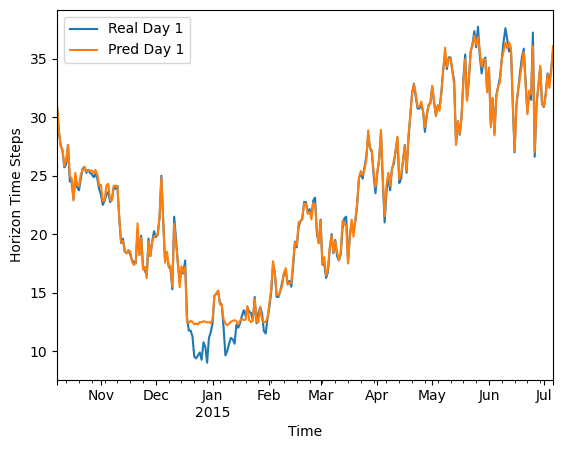

<Figure size 3000x1000 with 0 Axes>

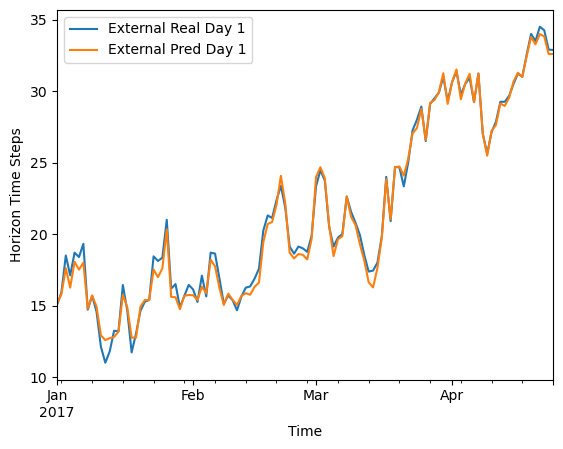

<Figure size 3000x1000 with 0 Axes>

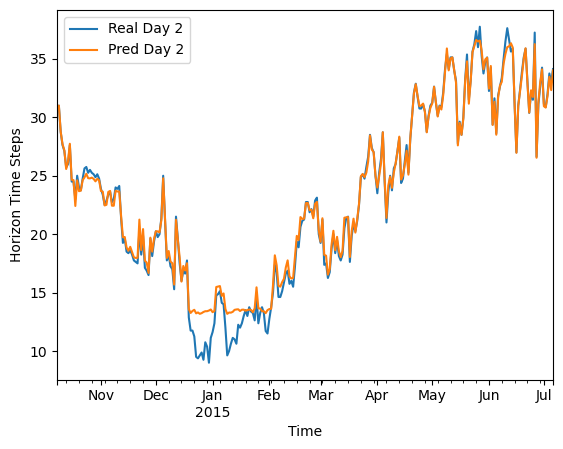

<Figure size 3000x1000 with 0 Axes>

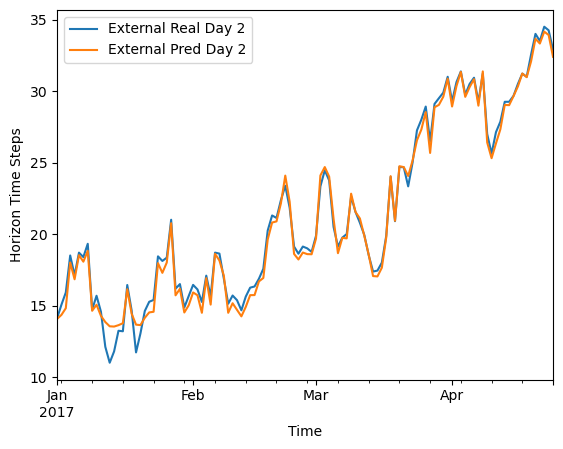

<Figure size 3000x1000 with 0 Axes>

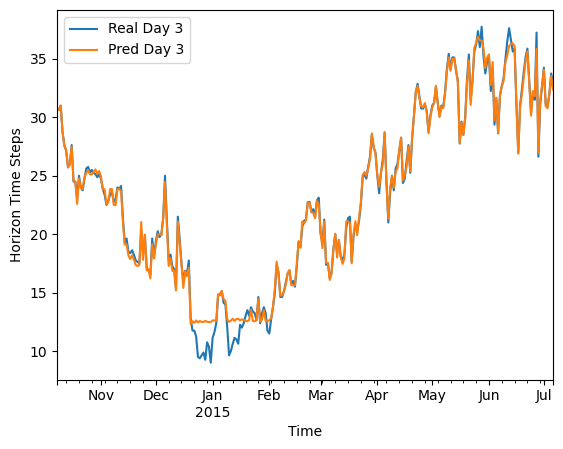

<Figure size 3000x1000 with 0 Axes>

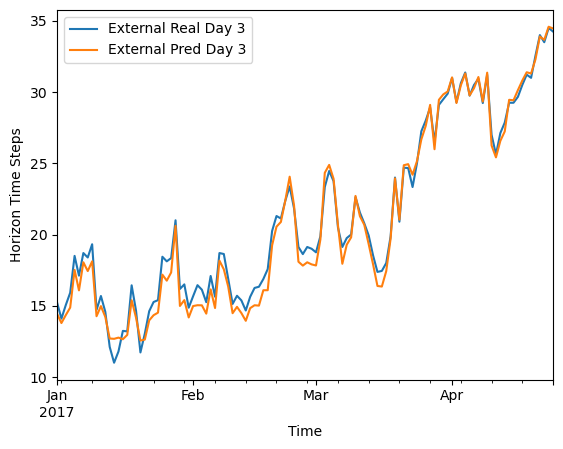

<Figure size 3000x1000 with 0 Axes>

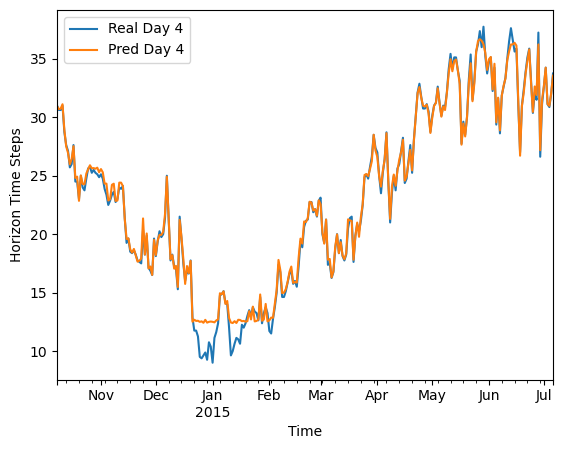

<Figure size 3000x1000 with 0 Axes>

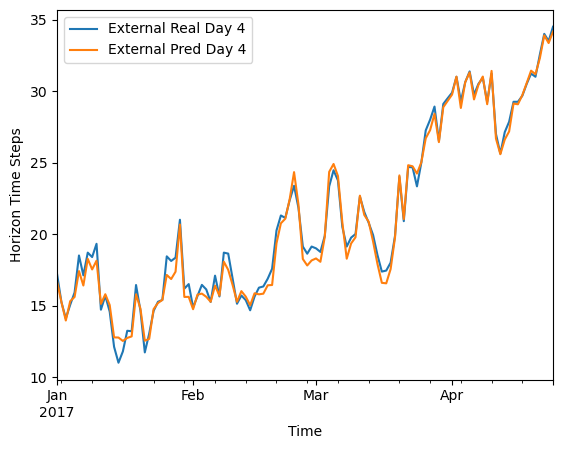

<Figure size 3000x1000 with 0 Axes>

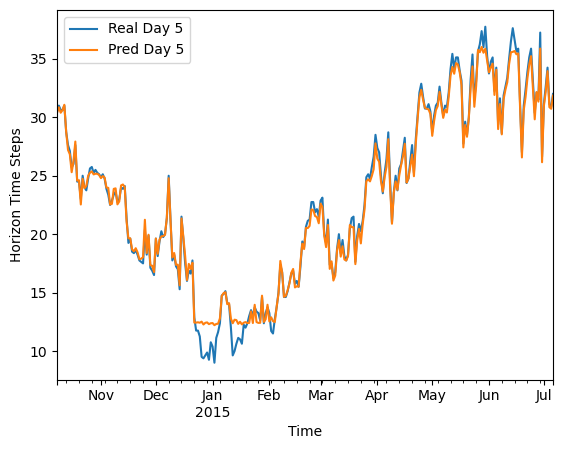

<Figure size 3000x1000 with 0 Axes>

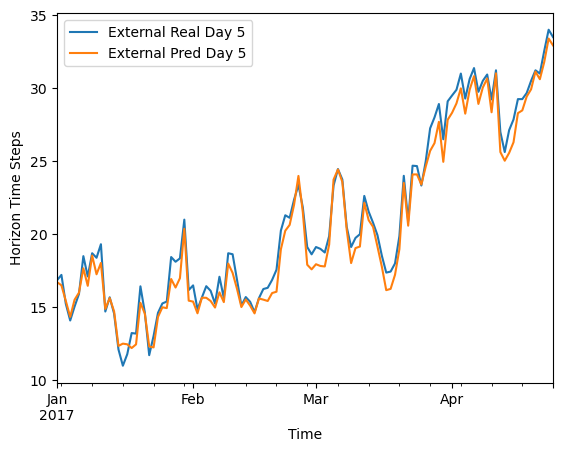

<Figure size 3000x1000 with 0 Axes>

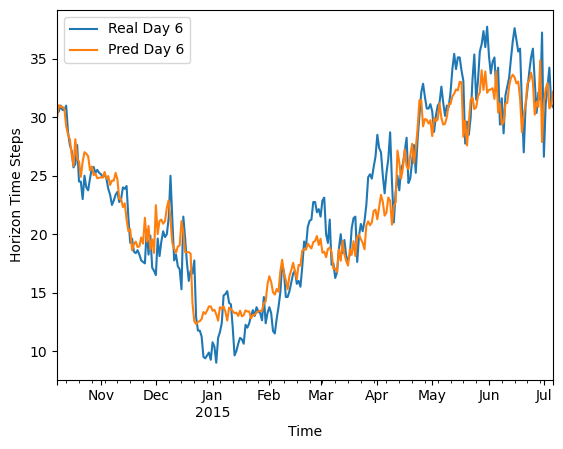

<Figure size 3000x1000 with 0 Axes>

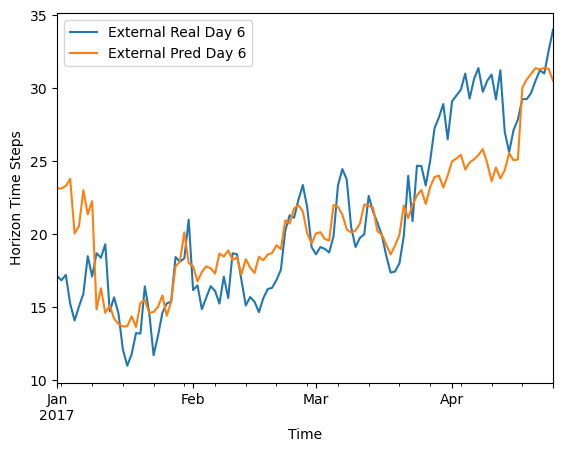

<Figure size 3000x1000 with 0 Axes>

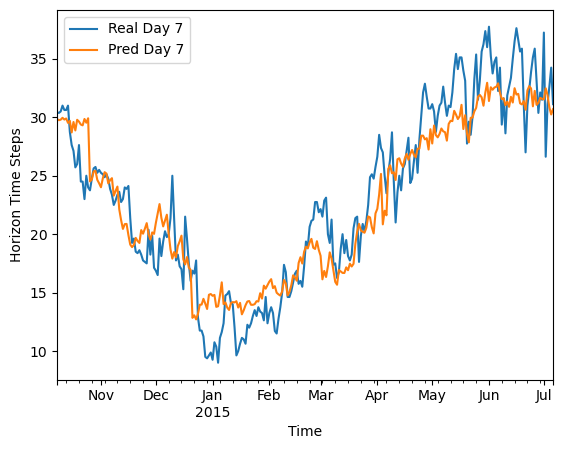

<Figure size 3000x1000 with 0 Axes>

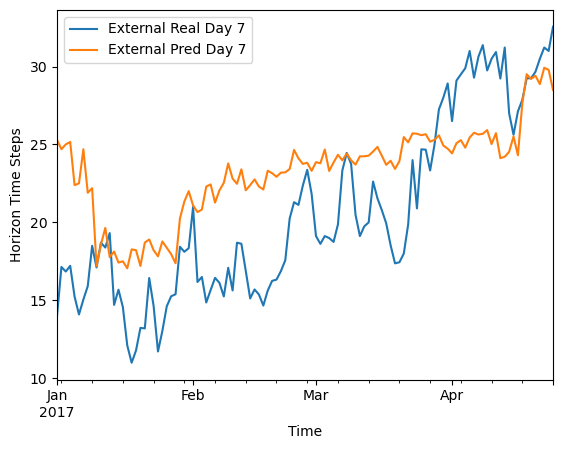

<Figure size 3000x1000 with 0 Axes>

Fold 2 Scores : {'RMSE': 1.0563665973141343, 'MAE': 0.5124625658703794, 'RMSLE': (0.0021211549393796805,), 'R-Squared': (0.9735331003469448,), 'Adj R-Squared': 0.9653894389152355, 'MAPE': 0.02356864454249}
Fold 2 External Scores : {'RMSE': 2.1999221565106257, 'MAE': 1.2526092215601383, 'RMSLE': (0.011517431818417927,), 'R-Squared': (0.8541533475336177,), 'Adj R-Squared': 0.8445219648235736, 'MAPE': 0.0712724555811208}
Train Start-End: 2014-01-08 00:00:00 - 2015-07-06 00:00:00
Validation Start-End: 2015-07-07 00:00:00 - 2016-04-03 00:00:00


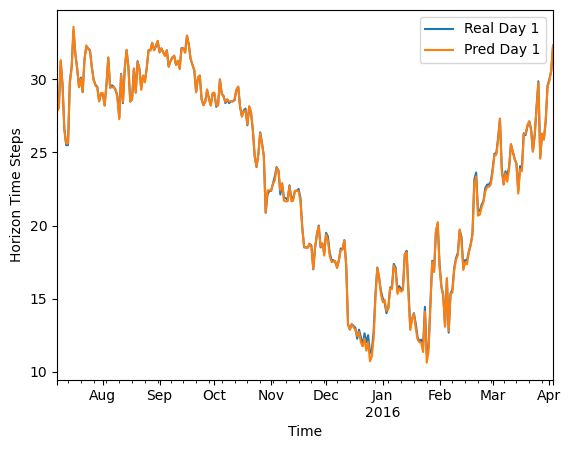

<Figure size 3000x1000 with 0 Axes>

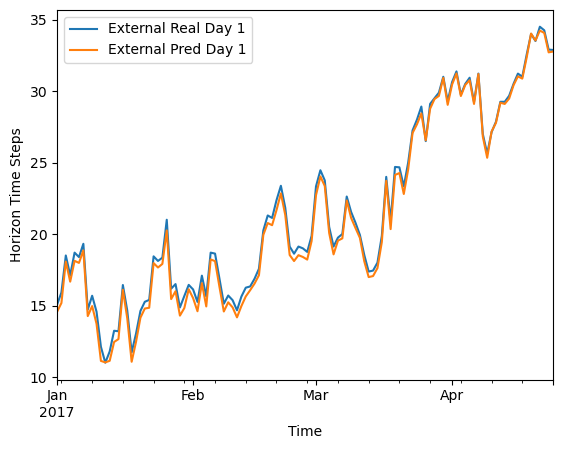

<Figure size 3000x1000 with 0 Axes>

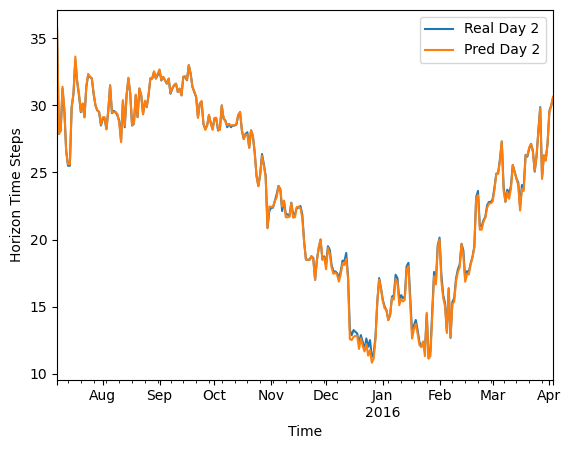

<Figure size 3000x1000 with 0 Axes>

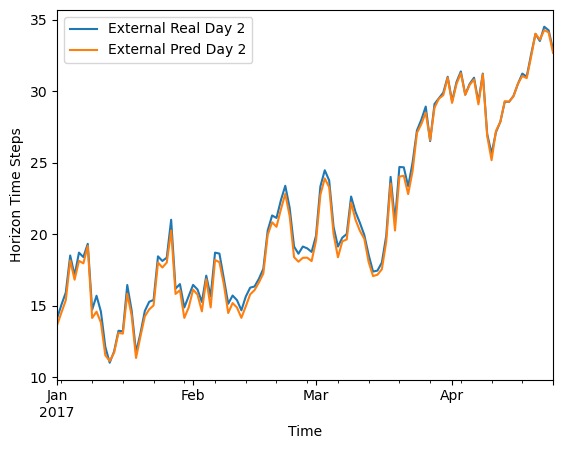

<Figure size 3000x1000 with 0 Axes>

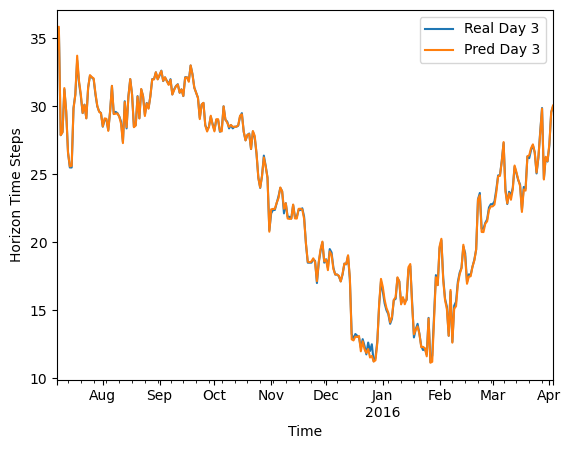

<Figure size 3000x1000 with 0 Axes>

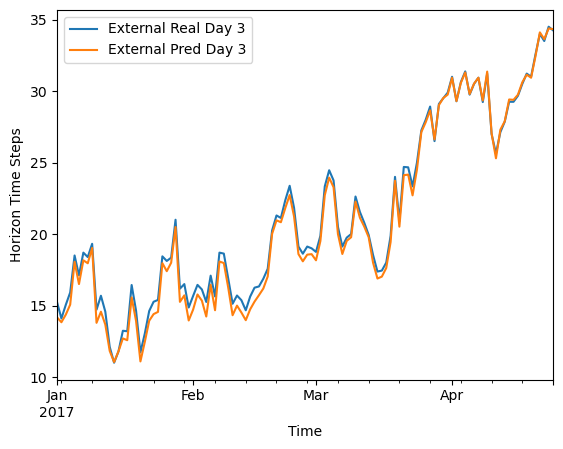

<Figure size 3000x1000 with 0 Axes>

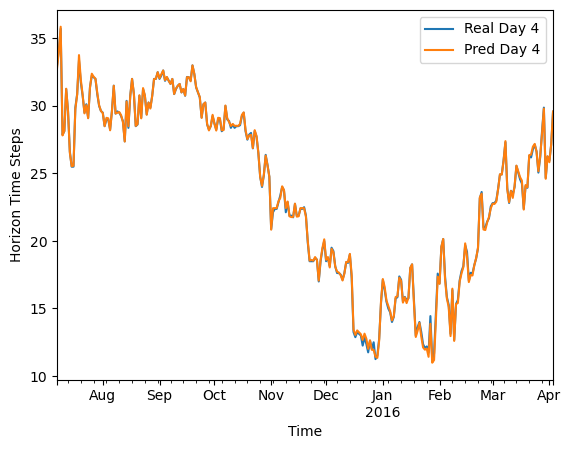

<Figure size 3000x1000 with 0 Axes>

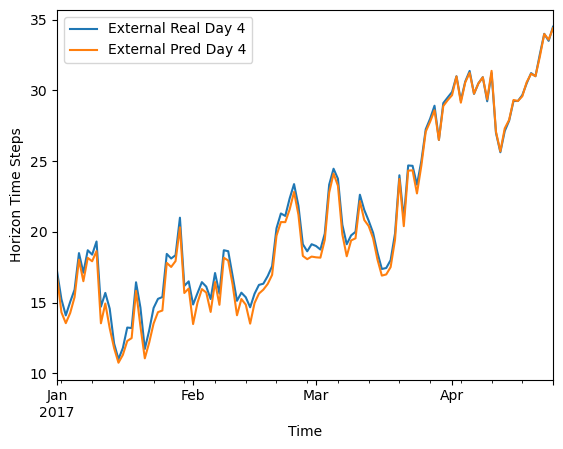

<Figure size 3000x1000 with 0 Axes>

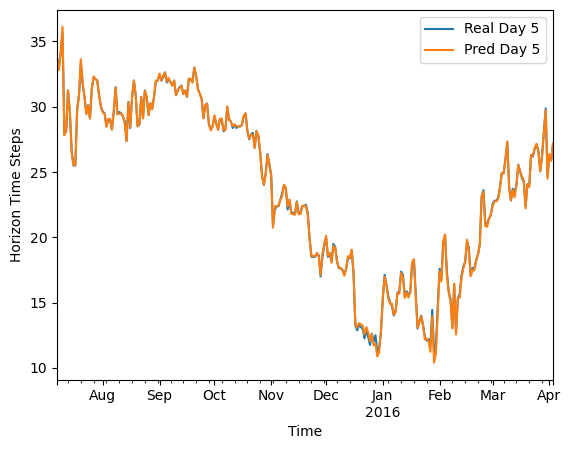

<Figure size 3000x1000 with 0 Axes>

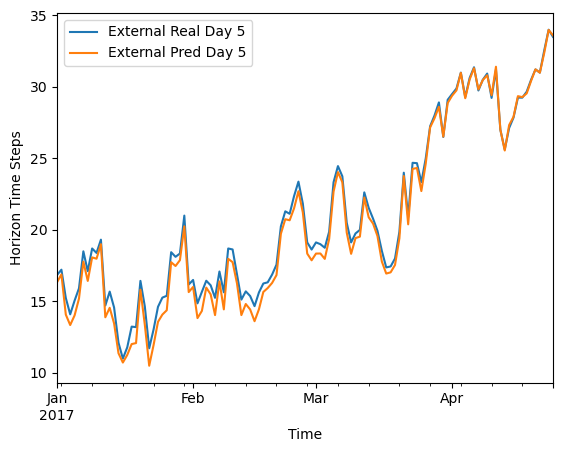

<Figure size 3000x1000 with 0 Axes>

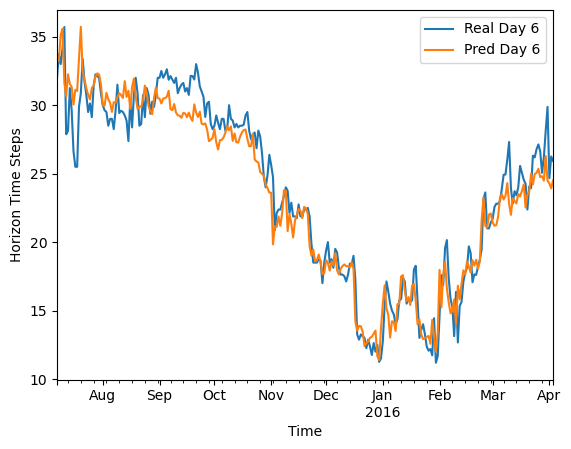

<Figure size 3000x1000 with 0 Axes>

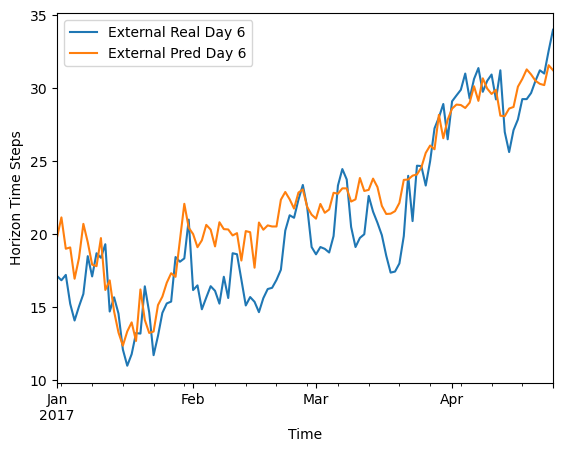

<Figure size 3000x1000 with 0 Axes>

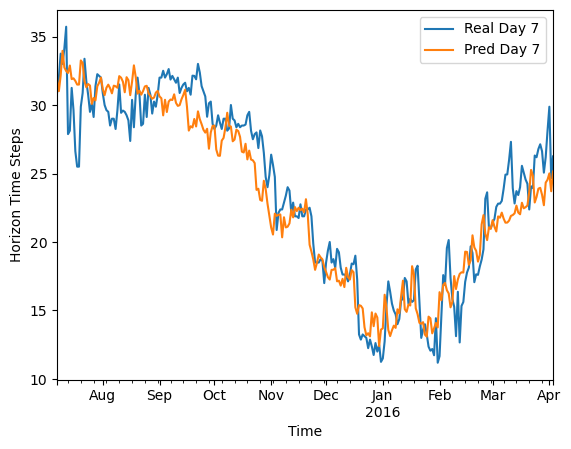

<Figure size 3000x1000 with 0 Axes>

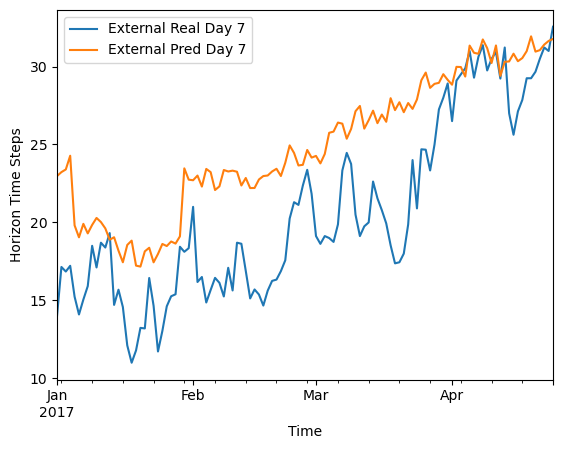

<Figure size 3000x1000 with 0 Axes>

Fold 3 Scores : {'RMSE': 1.1984991901124857, 'MAE': 0.6280411932707858, 'RMSLE': (0.0015762814713724215,), 'R-Squared': (0.9484787030489883,), 'Adj R-Squared': 0.938893345476707, 'MAPE': 0.021666648619966828}
Fold 3 External Scores : {'RMSE': 1.0708741405045328, 'MAE': 0.6666463112095234, 'RMSLE': (0.0029460864299608977,), 'R-Squared': (0.9658850910065605,), 'Adj R-Squared': 0.9636322196579371, 'MAPE': 0.03580580226457015}
Train Start-End: 2014-01-08 00:00:00 - 2016-04-03 00:00:00
Validation Start-End: 2016-04-04 00:00:00 - 2016-12-31 00:00:00


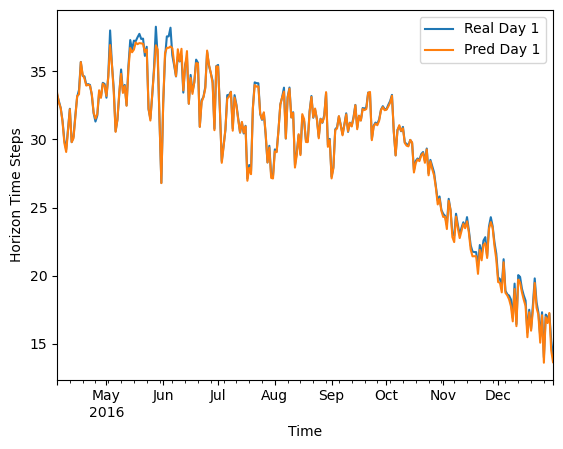

<Figure size 3000x1000 with 0 Axes>

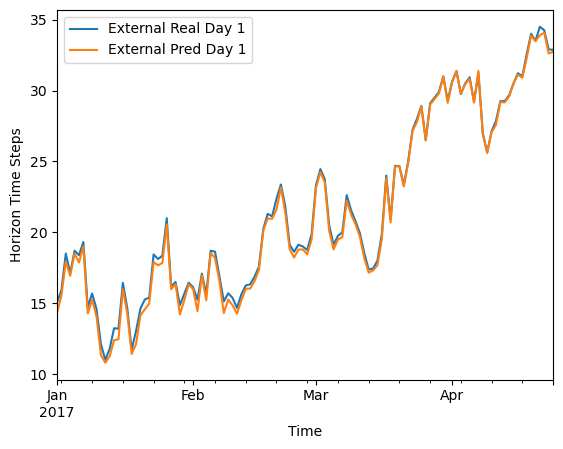

<Figure size 3000x1000 with 0 Axes>

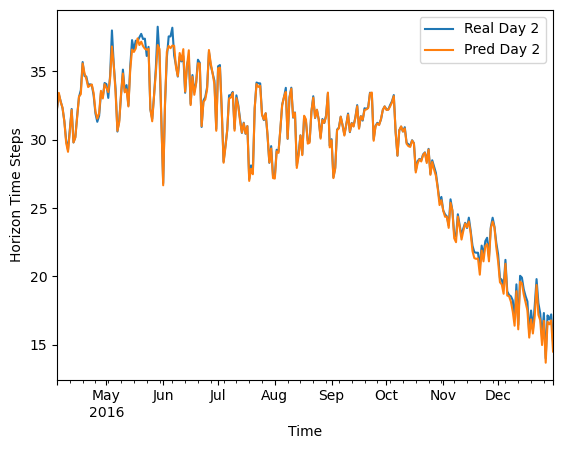

<Figure size 3000x1000 with 0 Axes>

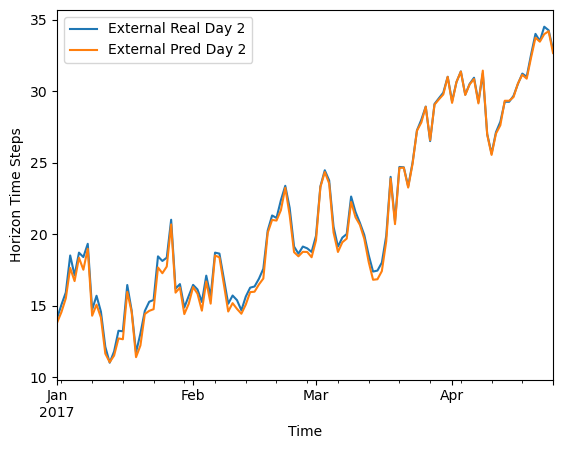

<Figure size 3000x1000 with 0 Axes>

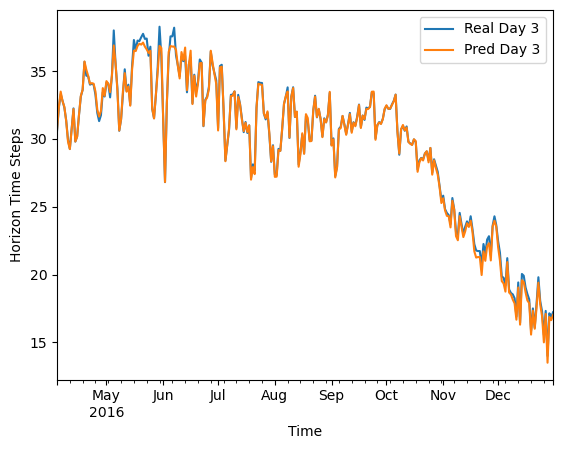

<Figure size 3000x1000 with 0 Axes>

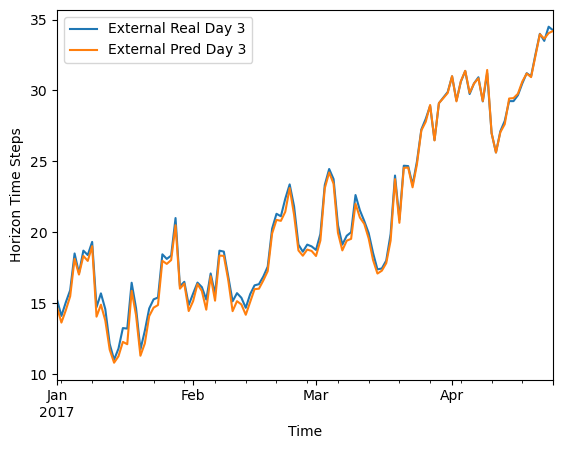

<Figure size 3000x1000 with 0 Axes>

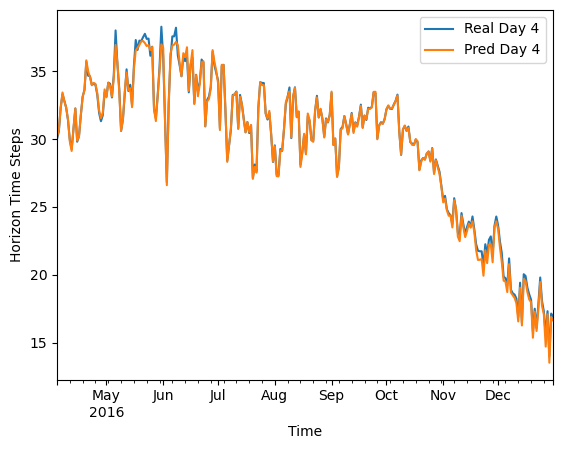

<Figure size 3000x1000 with 0 Axes>

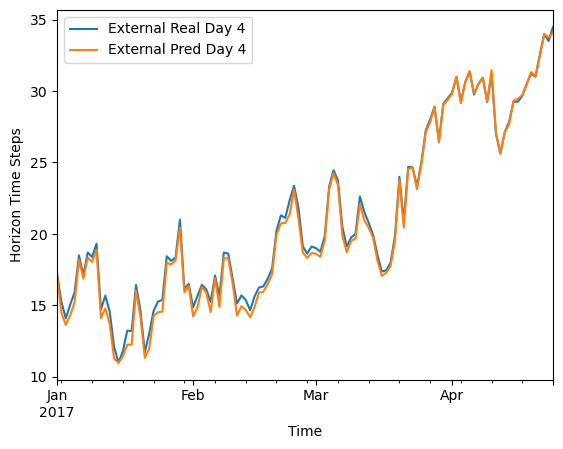

<Figure size 3000x1000 with 0 Axes>

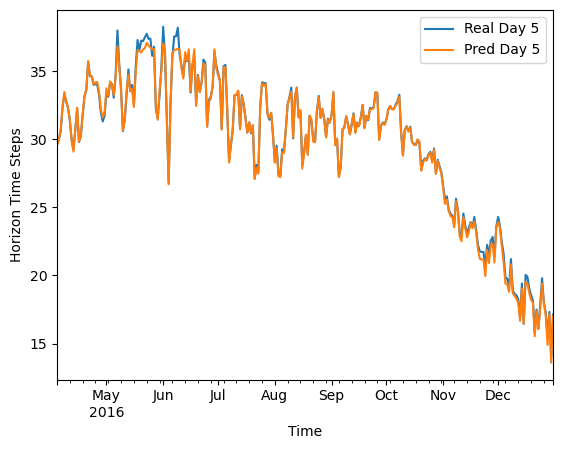

<Figure size 3000x1000 with 0 Axes>

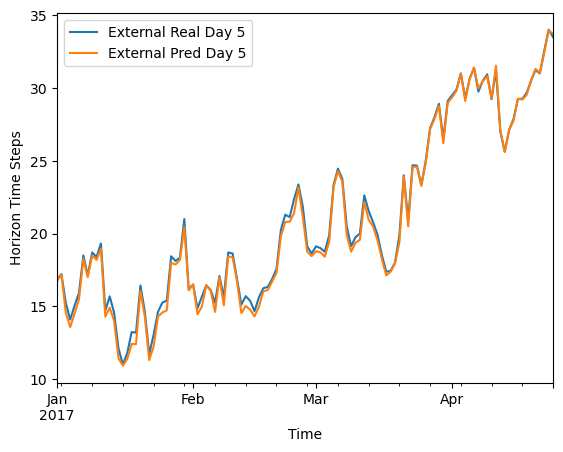

<Figure size 3000x1000 with 0 Axes>

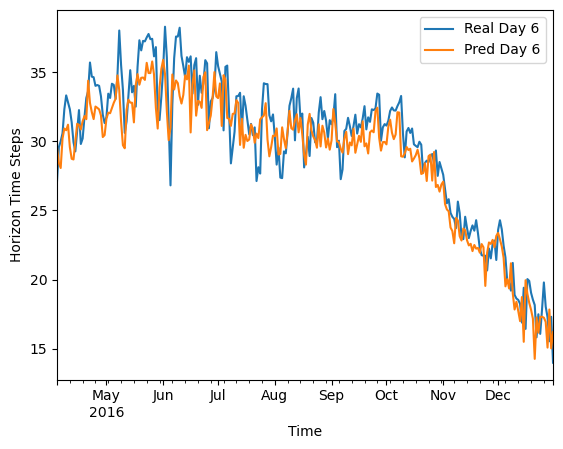

<Figure size 3000x1000 with 0 Axes>

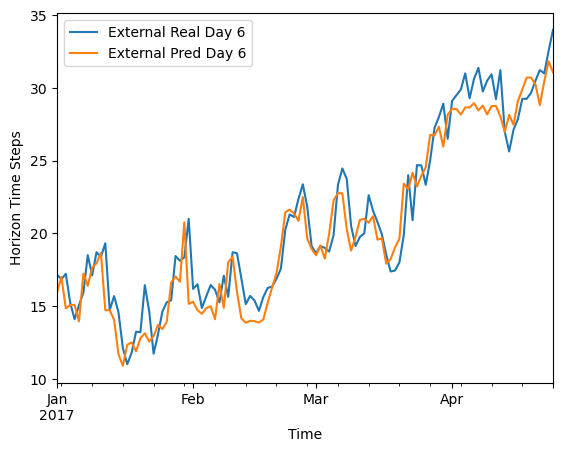

<Figure size 3000x1000 with 0 Axes>

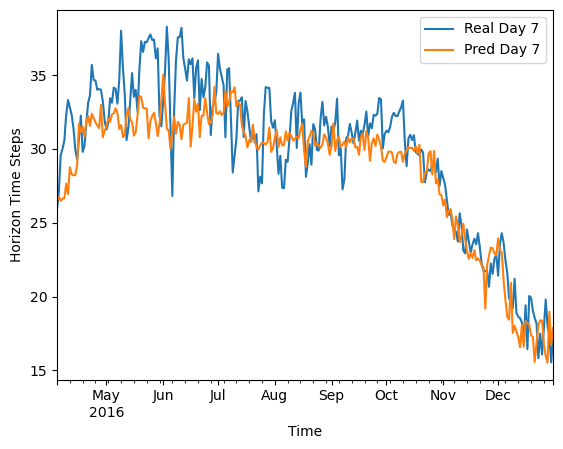

<Figure size 3000x1000 with 0 Axes>

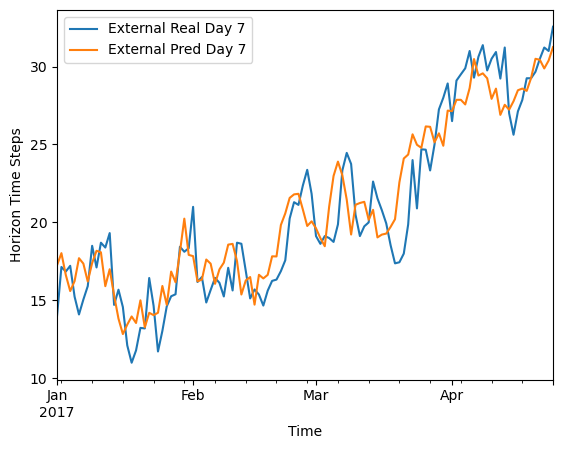

<Figure size 3000x1000 with 0 Axes>

In [82]:
alg = LGBMRegressor(random_state=42,verbose=-1)
alg.set_params(**best_params)
train_and_visualization(X,y,external_y,external_final_data,fold_list,horizon,num_cols,cat_cols,frequency,alg)

Fold 1 Scores : {'RMSE': 2.184733556867444, 'MAE': 1.2773246579095812, 'RMSLE': (0.0134132540543002,), 'R-Squared': (0.917865636796374,), 'Adj R-Squared': 0.8448573139487064, 'MAPE': 0.07312413687072337}
Fold 1 External Scores : {'RMSE': 2.3849501471785373, 'MAE': 1.3881874522192281, 'RMSLE': (0.01325397507863116,), 'R-Squared': (0.8304954604794687,), 'Adj R-Squared': 0.8193017644733958, 'MAPE': 0.07485165536106862}
Train Start-End: 2014-01-08 00:00:00 - 2014-10-07 00:00:00
Validation Start-End: 2014-10-08 00:00:00 - 2015-07-06 00:00:00


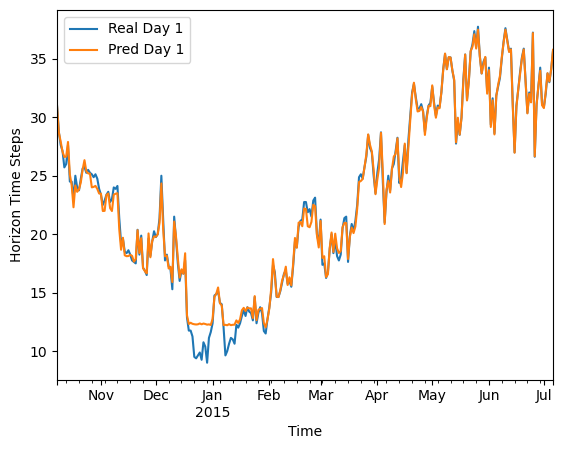

<Figure size 3000x1000 with 0 Axes>

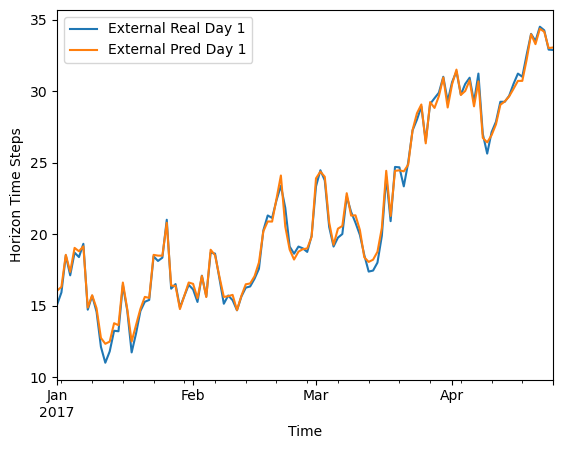

<Figure size 3000x1000 with 0 Axes>

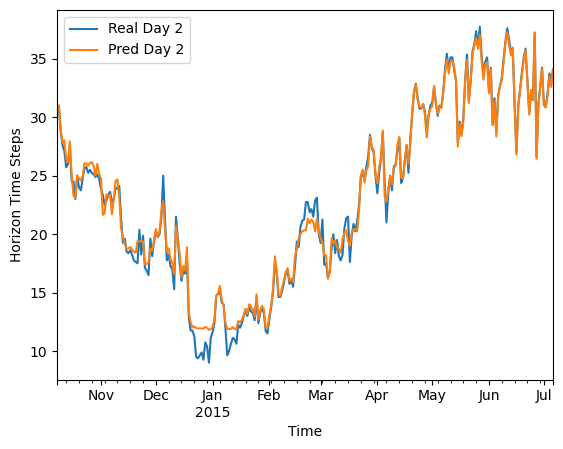

<Figure size 3000x1000 with 0 Axes>

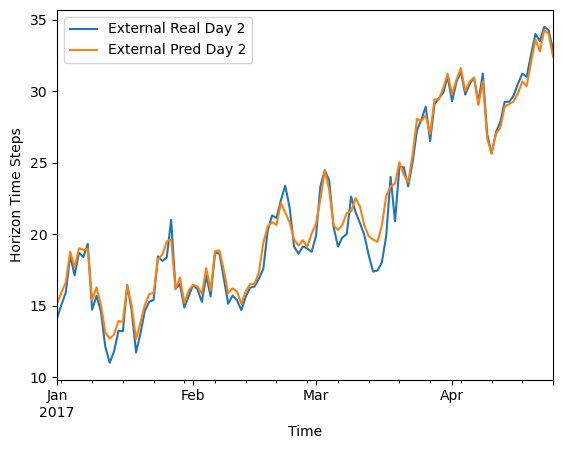

<Figure size 3000x1000 with 0 Axes>

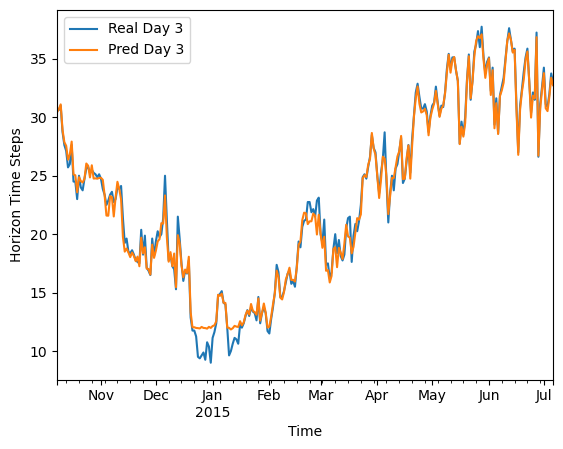

<Figure size 3000x1000 with 0 Axes>

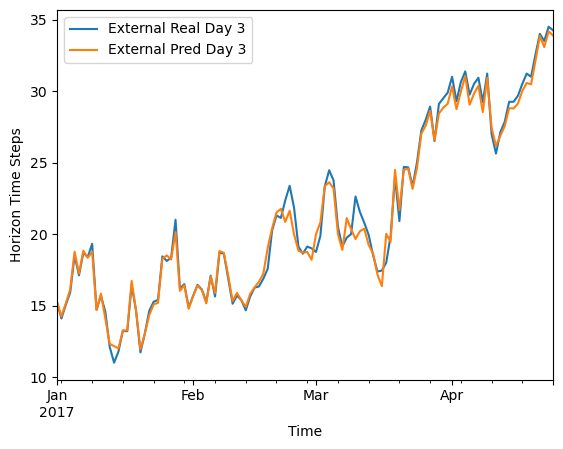

<Figure size 3000x1000 with 0 Axes>

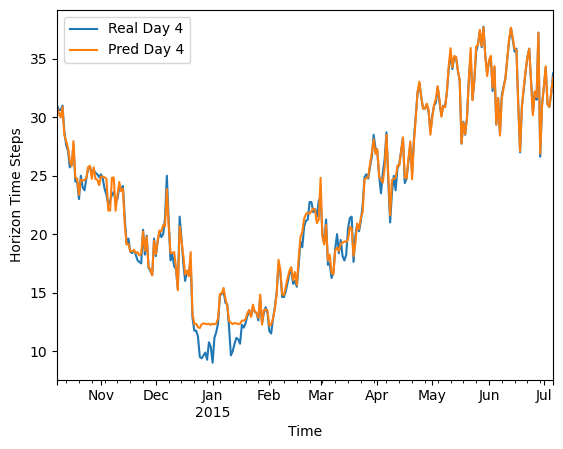

<Figure size 3000x1000 with 0 Axes>

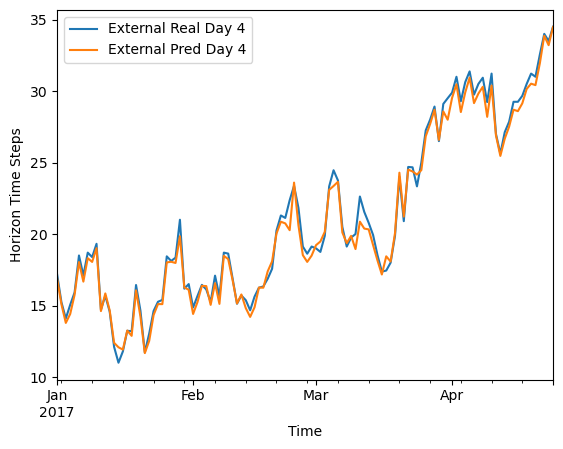

<Figure size 3000x1000 with 0 Axes>

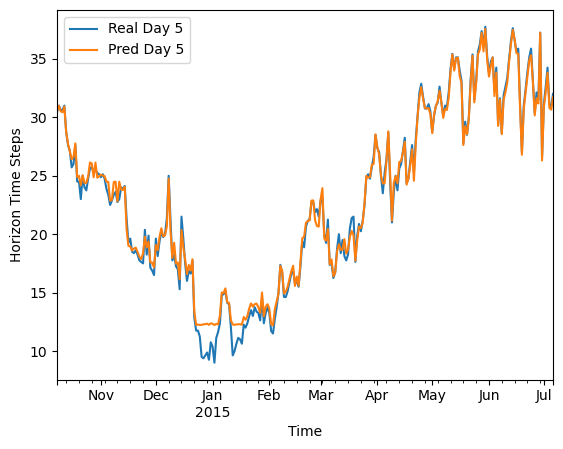

<Figure size 3000x1000 with 0 Axes>

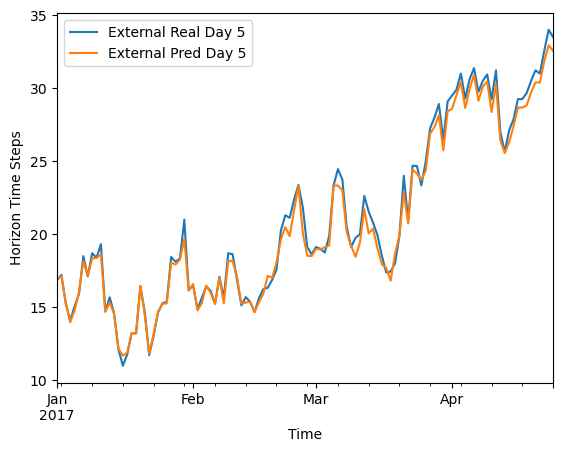

<Figure size 3000x1000 with 0 Axes>

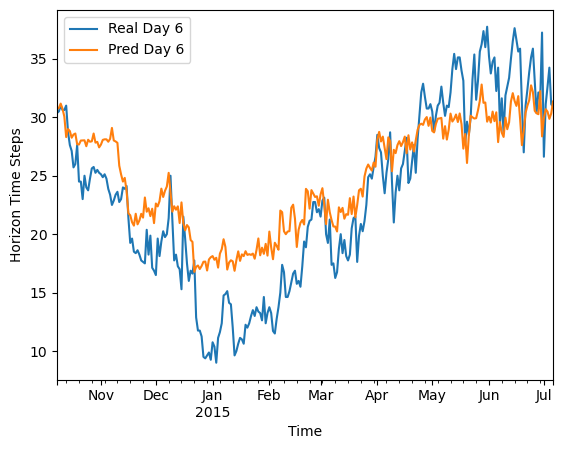

<Figure size 3000x1000 with 0 Axes>

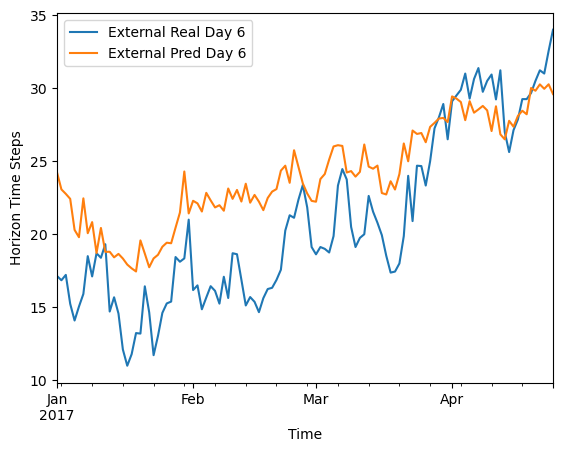

<Figure size 3000x1000 with 0 Axes>

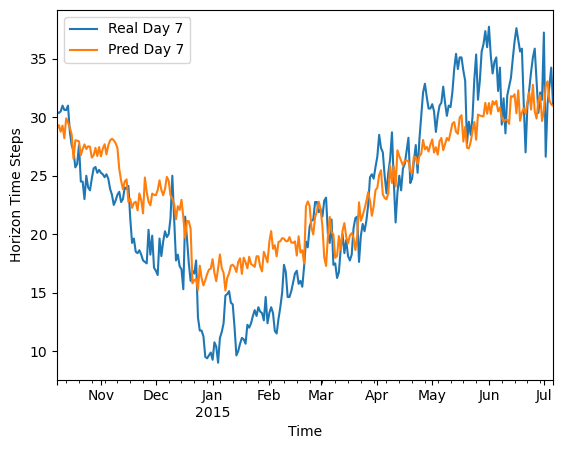

<Figure size 3000x1000 with 0 Axes>

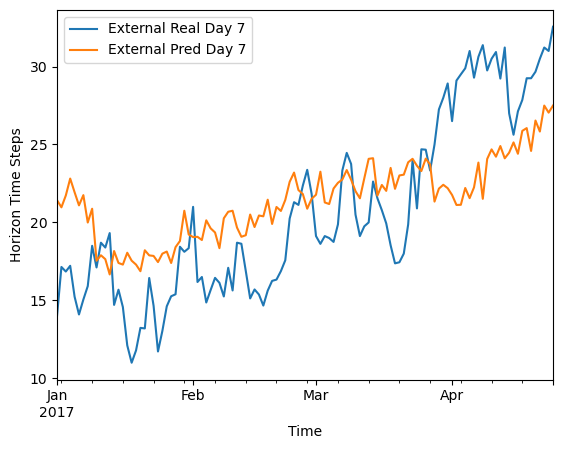

<Figure size 3000x1000 with 0 Axes>

Fold 2 Scores : {'RMSE': 1.3756213896281173, 'MAE': 0.6980843029766527, 'RMSLE': (0.0033554559425494268,), 'R-Squared': (0.9551244862591332,), 'Adj R-Squared': 0.941316635877328, 'MAPE': 0.030031608147830343}
Fold 2 External Scores : {'RMSE': 1.5543705707570432, 'MAE': 0.8400943006108046, 'RMSLE': (0.005993402286955219,), 'R-Squared': (0.9272824176292687,), 'Adj R-Squared': 0.9224803131330883, 'MAPE': 0.0453381994541392}
Train Start-End: 2014-01-08 00:00:00 - 2015-07-06 00:00:00
Validation Start-End: 2015-07-07 00:00:00 - 2016-04-03 00:00:00


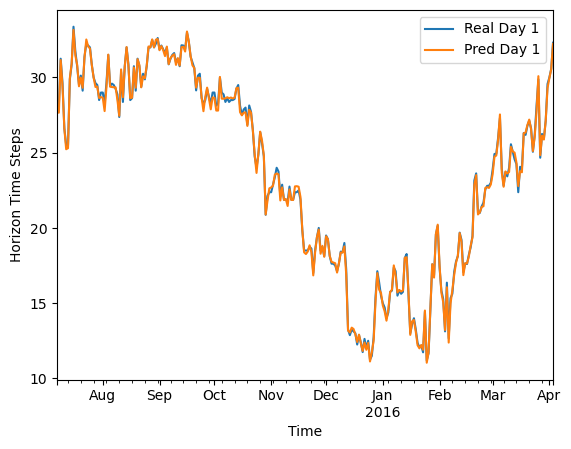

<Figure size 3000x1000 with 0 Axes>

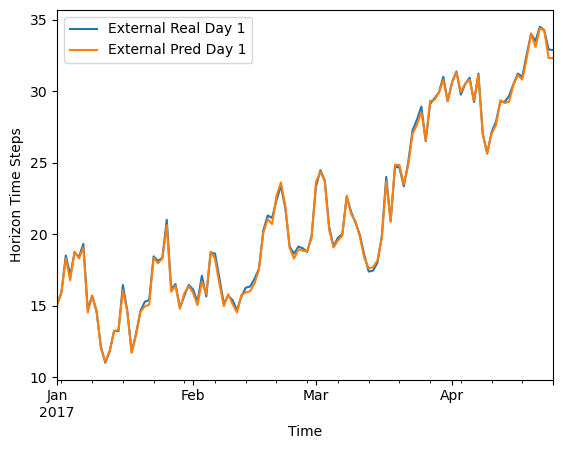

<Figure size 3000x1000 with 0 Axes>

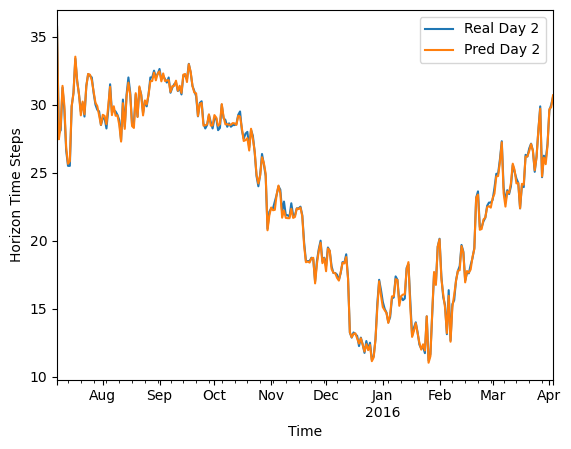

<Figure size 3000x1000 with 0 Axes>

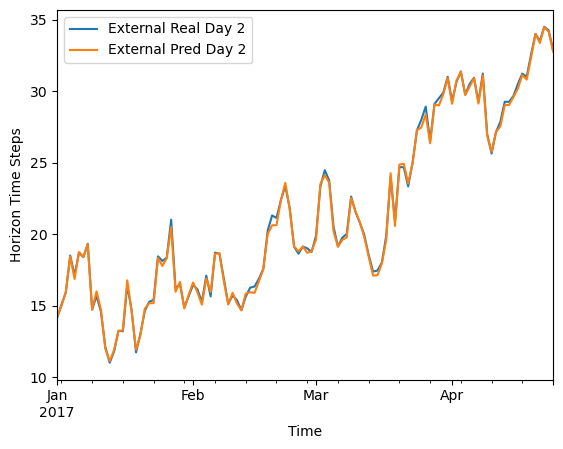

<Figure size 3000x1000 with 0 Axes>

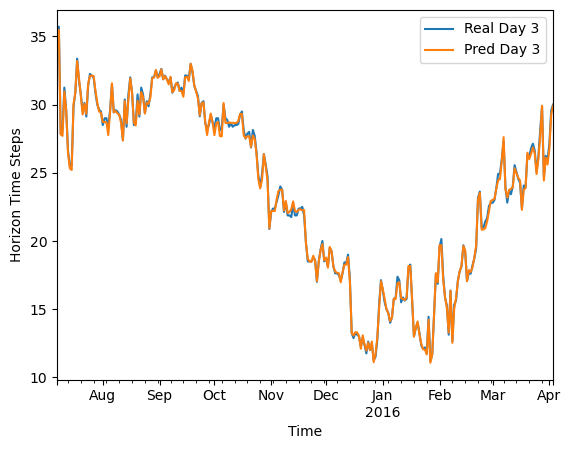

<Figure size 3000x1000 with 0 Axes>

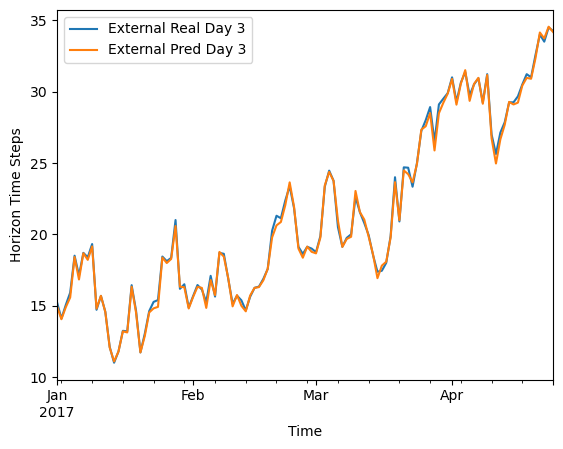

<Figure size 3000x1000 with 0 Axes>

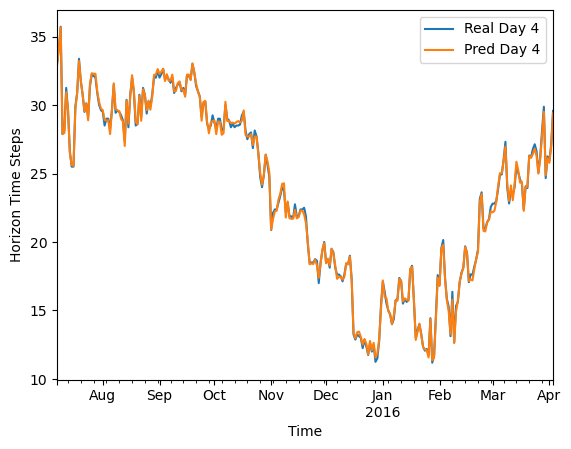

<Figure size 3000x1000 with 0 Axes>

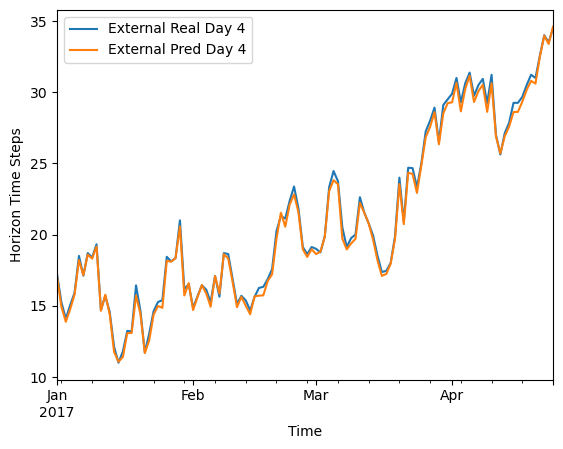

<Figure size 3000x1000 with 0 Axes>

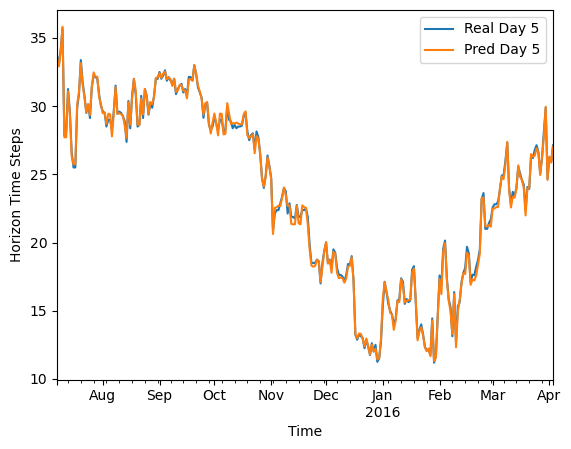

<Figure size 3000x1000 with 0 Axes>

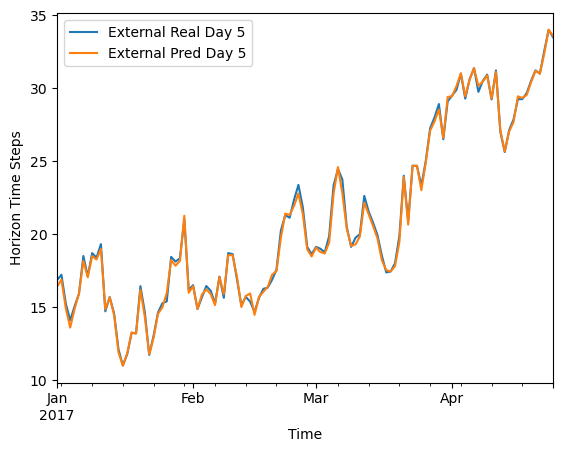

<Figure size 3000x1000 with 0 Axes>

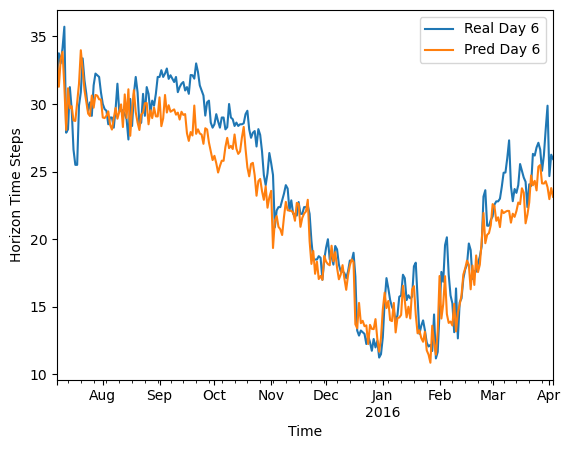

<Figure size 3000x1000 with 0 Axes>

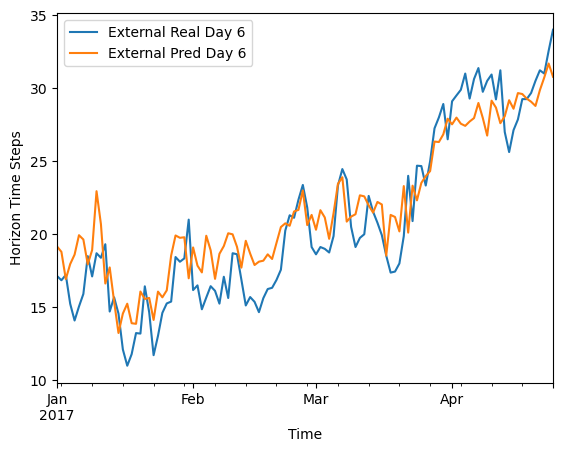

<Figure size 3000x1000 with 0 Axes>

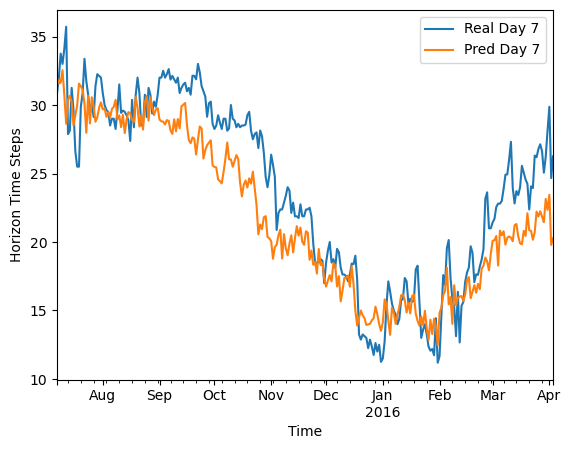

<Figure size 3000x1000 with 0 Axes>

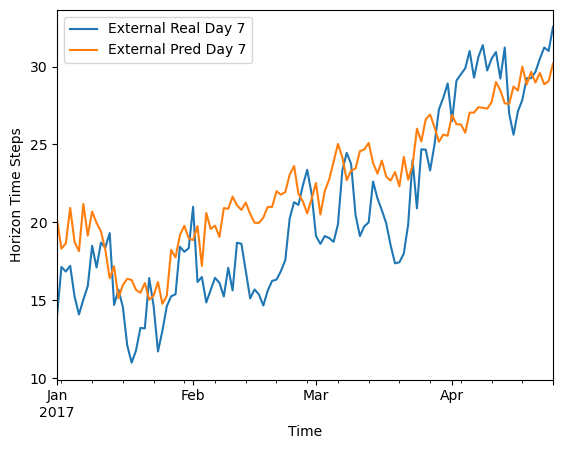

<Figure size 3000x1000 with 0 Axes>

Fold 3 Scores : {'RMSE': 1.6354114158358735, 'MAE': 0.8258162291849107, 'RMSLE': (0.0027989527837229597,), 'R-Squared': (0.9043076697642566,), 'Adj R-Squared': 0.8865044455343508, 'MAPE': 0.02722089421874127}
Fold 3 External Scores : {'RMSE': 1.2351671932177108, 'MAE': 0.6524071356458777, 'RMSLE': (0.0034151474331651946,), 'R-Squared': (0.9543130143153727,), 'Adj R-Squared': 0.9512959492229917, 'MAPE': 0.032819423978575735}
Train Start-End: 2014-01-08 00:00:00 - 2016-04-03 00:00:00
Validation Start-End: 2016-04-04 00:00:00 - 2016-12-31 00:00:00


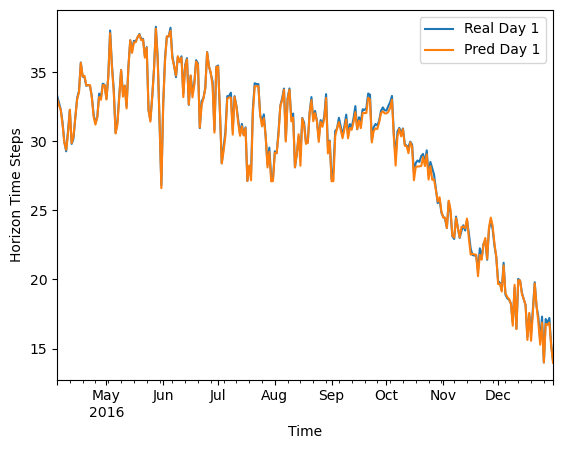

<Figure size 3000x1000 with 0 Axes>

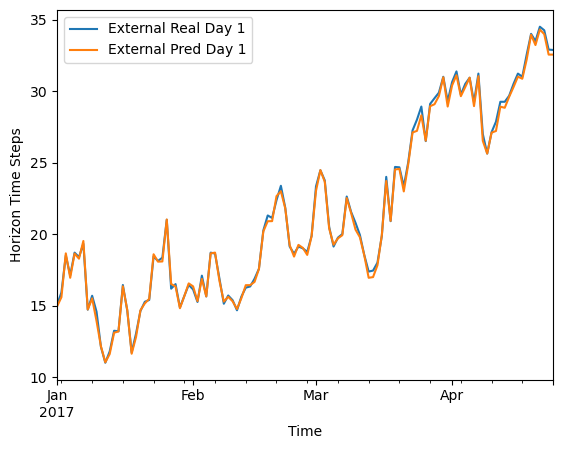

<Figure size 3000x1000 with 0 Axes>

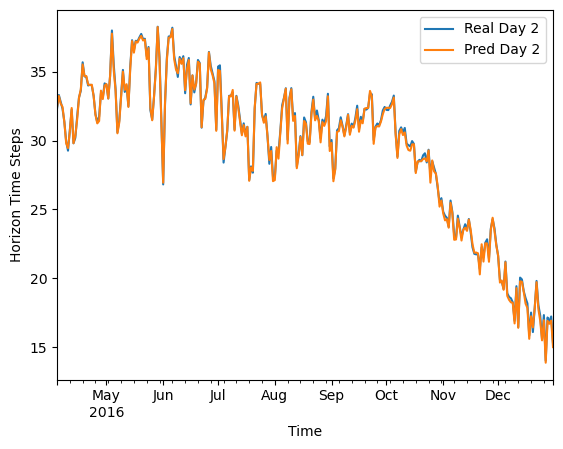

<Figure size 3000x1000 with 0 Axes>

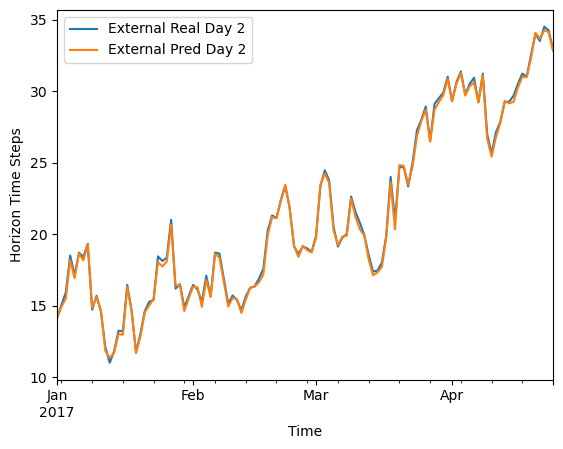

<Figure size 3000x1000 with 0 Axes>

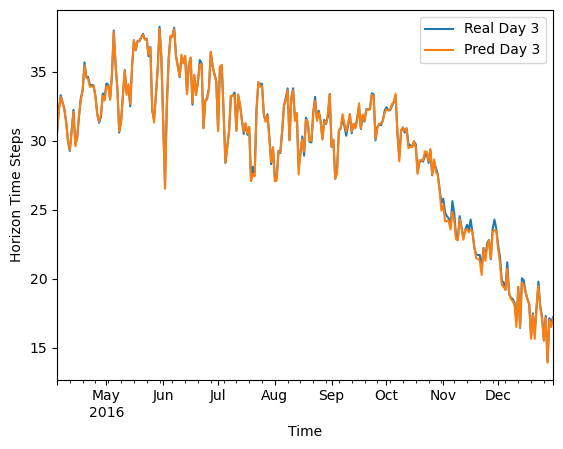

<Figure size 3000x1000 with 0 Axes>

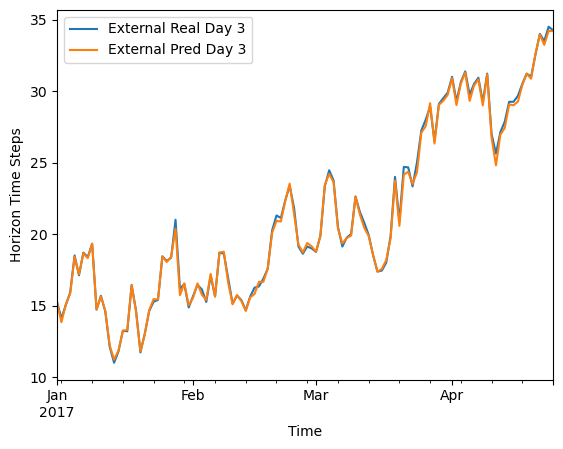

<Figure size 3000x1000 with 0 Axes>

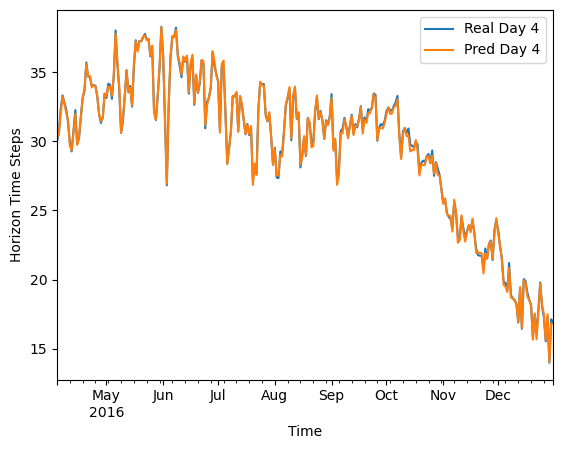

<Figure size 3000x1000 with 0 Axes>

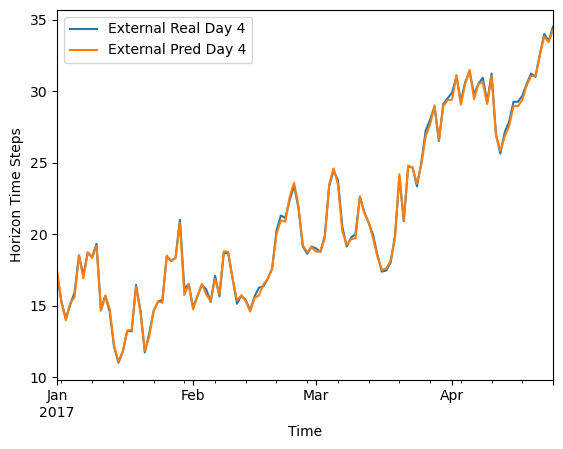

<Figure size 3000x1000 with 0 Axes>

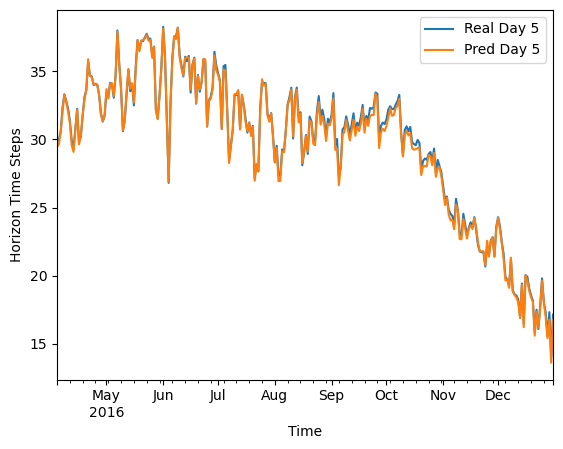

<Figure size 3000x1000 with 0 Axes>

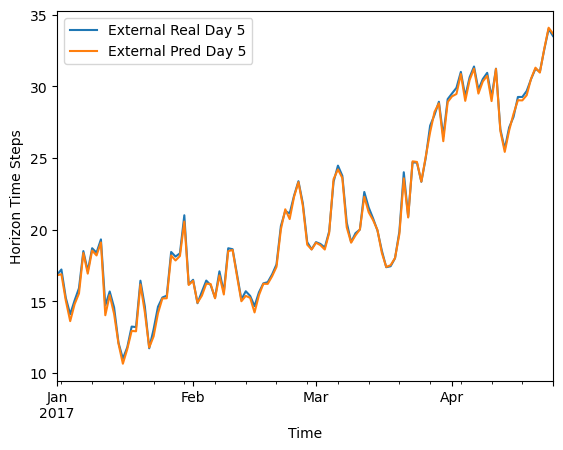

<Figure size 3000x1000 with 0 Axes>

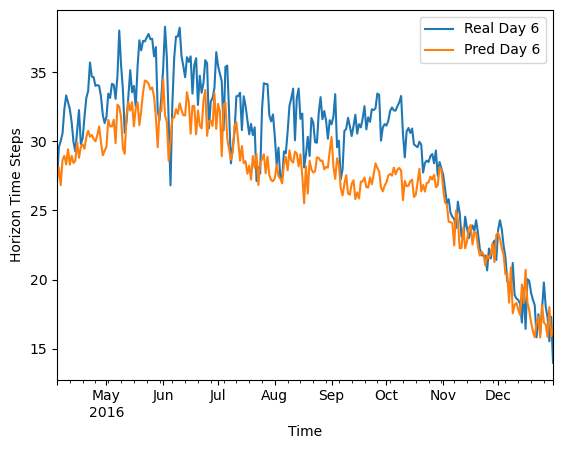

<Figure size 3000x1000 with 0 Axes>

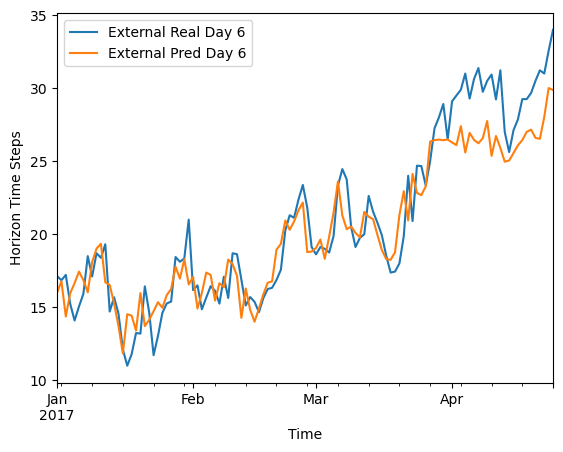

<Figure size 3000x1000 with 0 Axes>

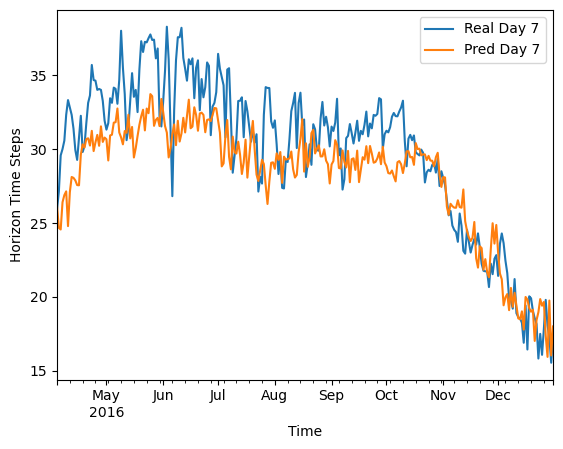

<Figure size 3000x1000 with 0 Axes>

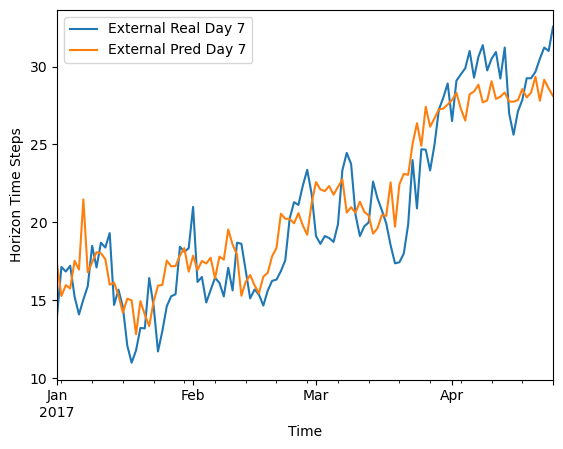

<Figure size 3000x1000 with 0 Axes>

In [83]:
alg = XGBRegressor(random_state=42)
alg.set_params(**best_params)
train_and_visualization(X,y,external_y,external_final_data,fold_list,horizon,num_cols,cat_cols,frequency,alg)

Fold 1 Scores : {'RMSE': 5.0137909100051266, 'MAE': 3.937821539943059, 'RMSLE': (0.07160418249970431,), 'R-Squared': (0.5697231289540275,), 'Adj R-Squared': 0.18725479913538534, 'MAPE': 0.24717026050308014}
Fold 1 External Scores : {'RMSE': 4.614536442797479, 'MAE': 3.983008947405459, 'RMSLE': (0.05455434432317629,), 'R-Squared': (0.41201705582294285,), 'Adj R-Squared': 0.3731879934716277, 'MAPE': 0.23278239790834002}
Train Start-End: 2014-01-08 00:00:00 - 2014-10-07 00:00:00
Validation Start-End: 2014-10-08 00:00:00 - 2015-07-06 00:00:00


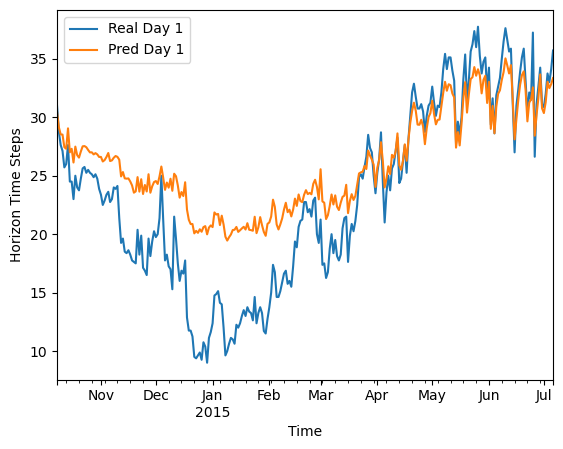

<Figure size 3000x1000 with 0 Axes>

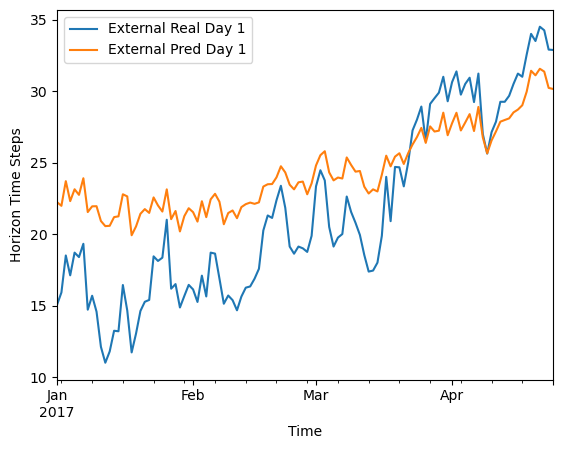

<Figure size 3000x1000 with 0 Axes>

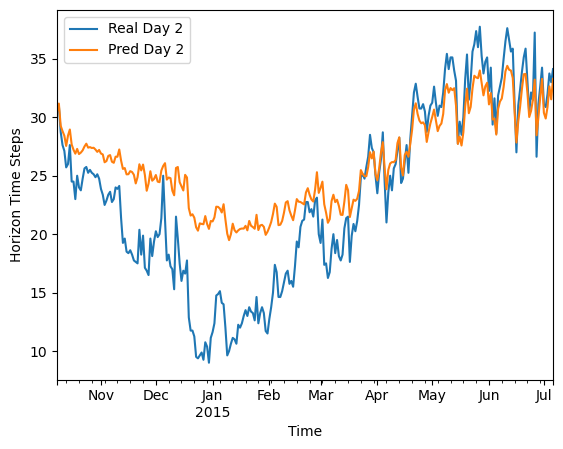

<Figure size 3000x1000 with 0 Axes>

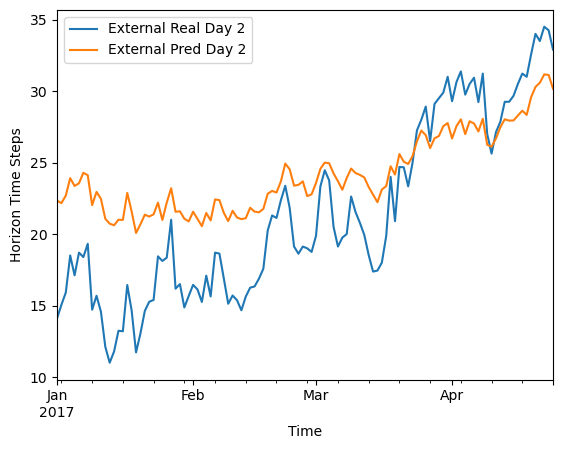

<Figure size 3000x1000 with 0 Axes>

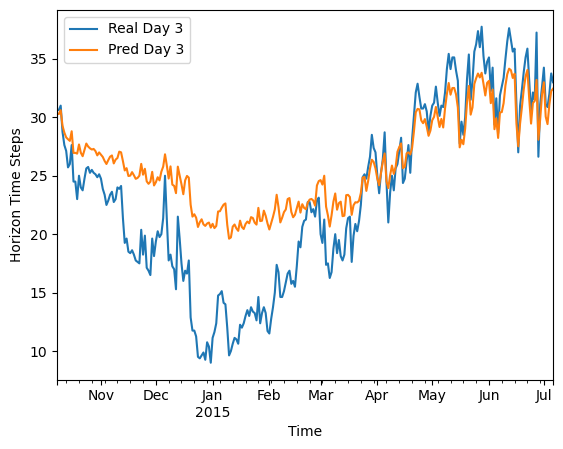

<Figure size 3000x1000 with 0 Axes>

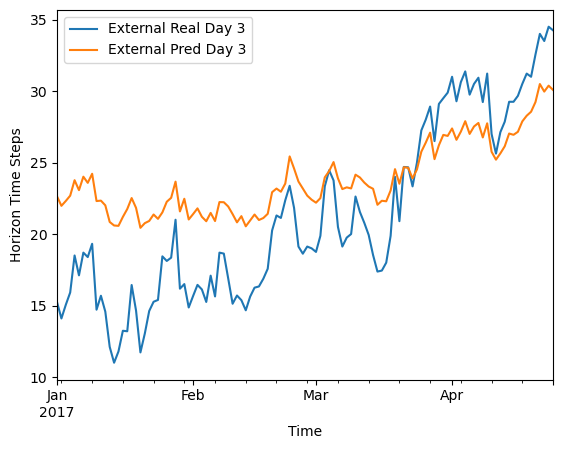

<Figure size 3000x1000 with 0 Axes>

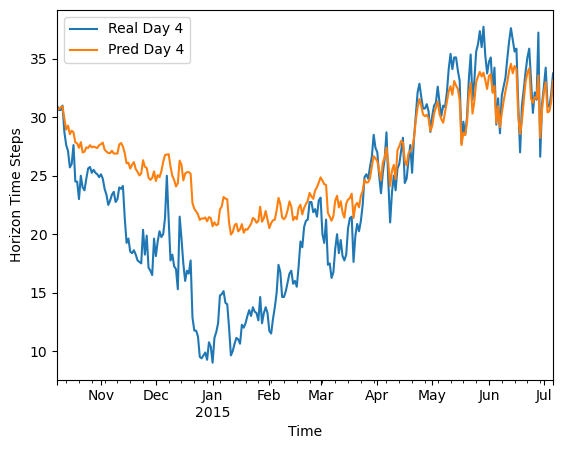

<Figure size 3000x1000 with 0 Axes>

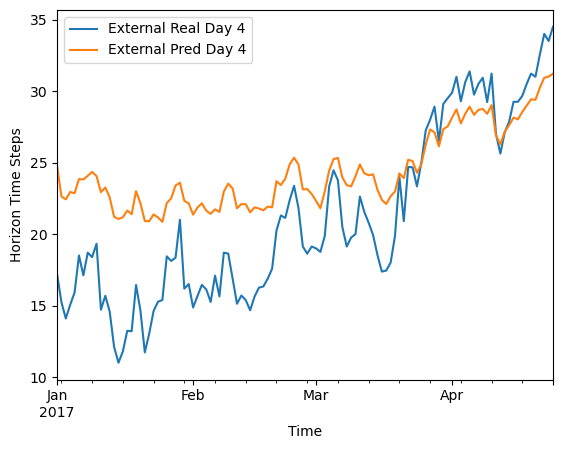

<Figure size 3000x1000 with 0 Axes>

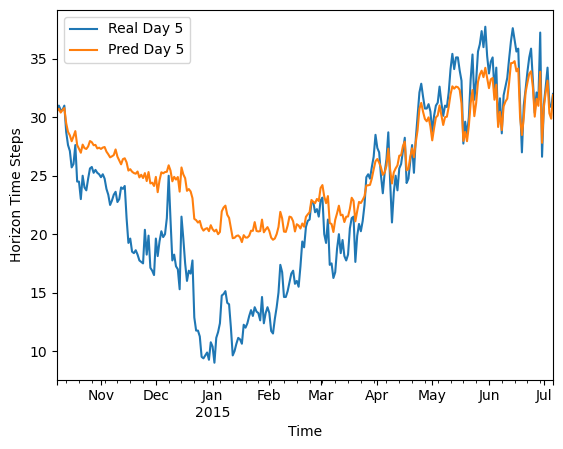

<Figure size 3000x1000 with 0 Axes>

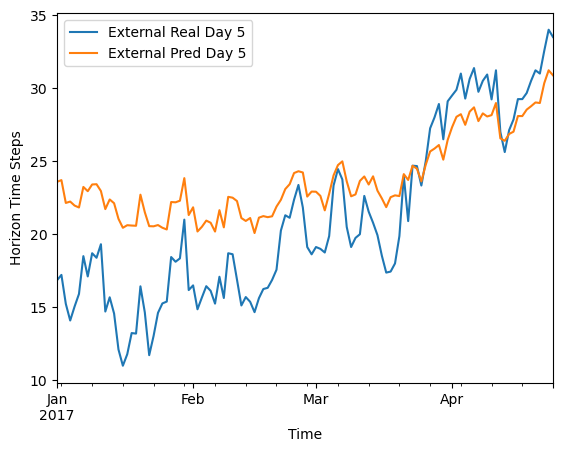

<Figure size 3000x1000 with 0 Axes>

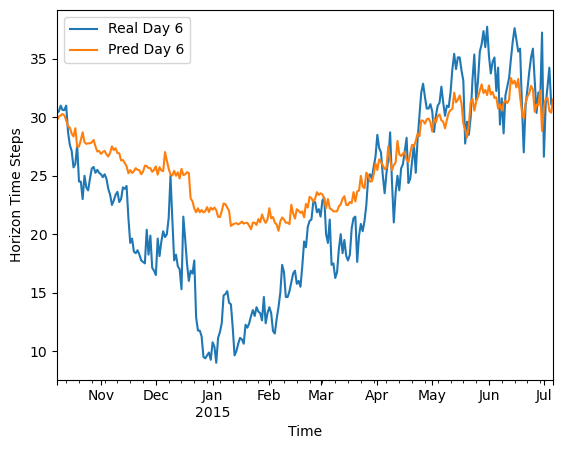

<Figure size 3000x1000 with 0 Axes>

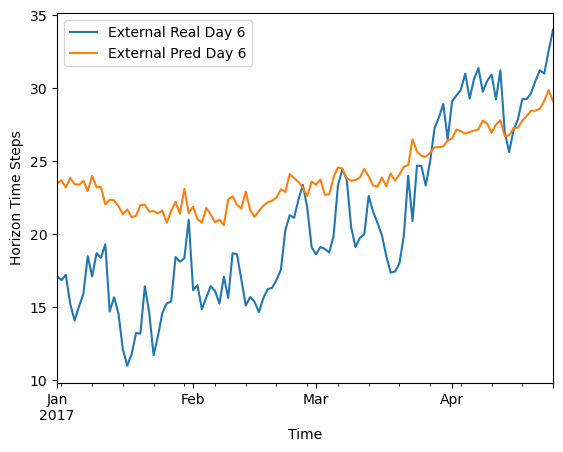

<Figure size 3000x1000 with 0 Axes>

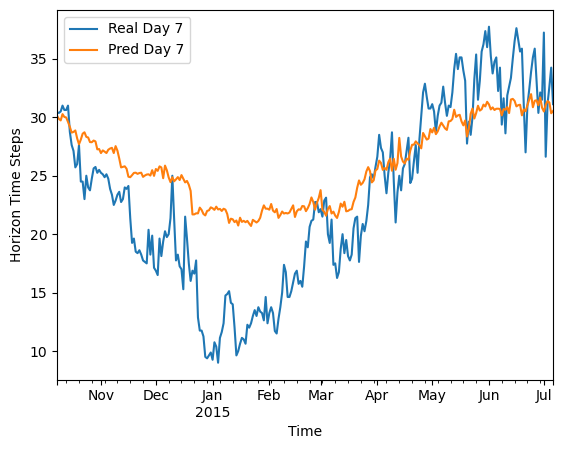

<Figure size 3000x1000 with 0 Axes>

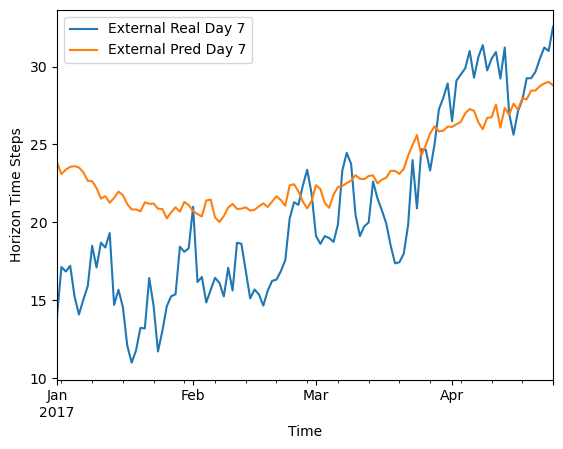

<Figure size 3000x1000 with 0 Axes>

Fold 2 Scores : {'RMSE': 1.3220441208060556, 'MAE': 0.959289936211654, 'RMSLE': (0.004364532543295775,), 'R-Squared': (0.9583165421249958,), 'Adj R-Squared': 0.9454908627788408, 'MAPE': 0.04777993469762441}
Fold 2 External Scores : {'RMSE': 2.500439445769788, 'MAE': 2.0341106531626325, 'RMSLE': (0.018136752777733134,), 'R-Squared': (0.8216642274611198,), 'Adj R-Squared': 0.8098873368217597, 'MAPE': 0.11807483367090142}
Train Start-End: 2014-01-08 00:00:00 - 2015-07-06 00:00:00
Validation Start-End: 2015-07-07 00:00:00 - 2016-04-03 00:00:00


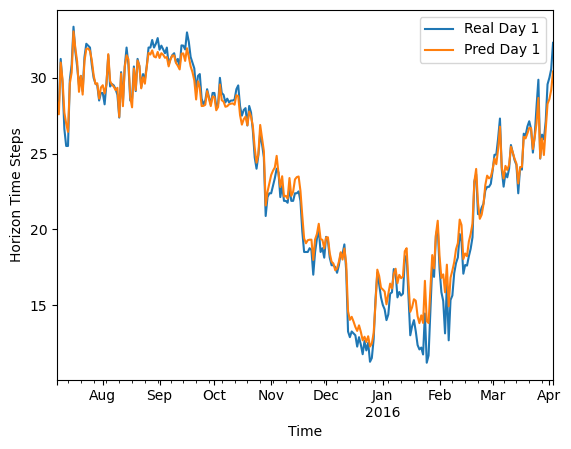

<Figure size 3000x1000 with 0 Axes>

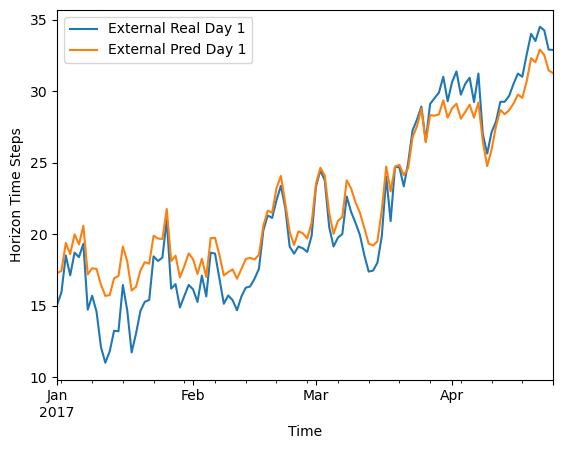

<Figure size 3000x1000 with 0 Axes>

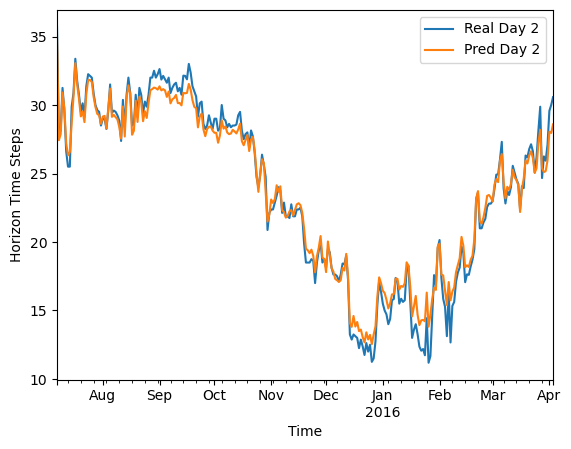

<Figure size 3000x1000 with 0 Axes>

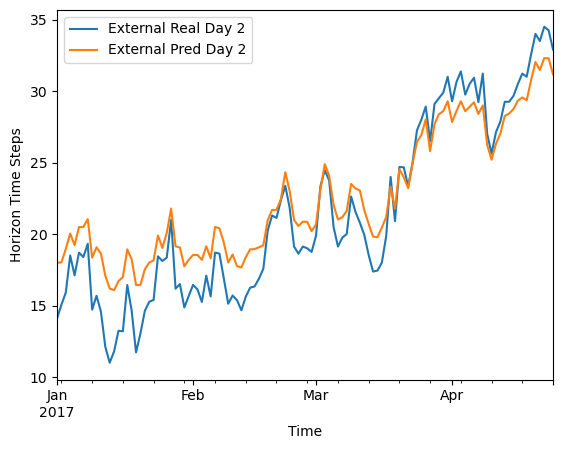

<Figure size 3000x1000 with 0 Axes>

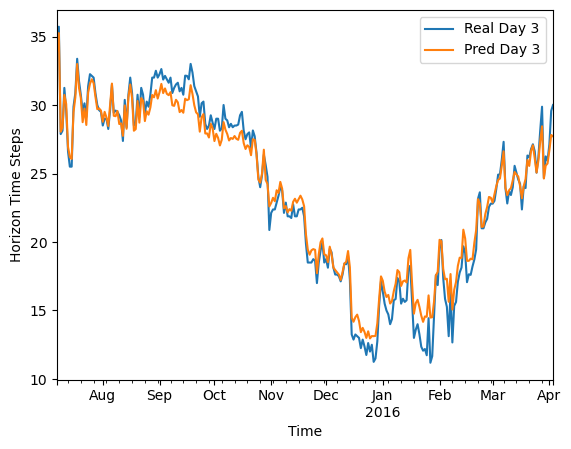

<Figure size 3000x1000 with 0 Axes>

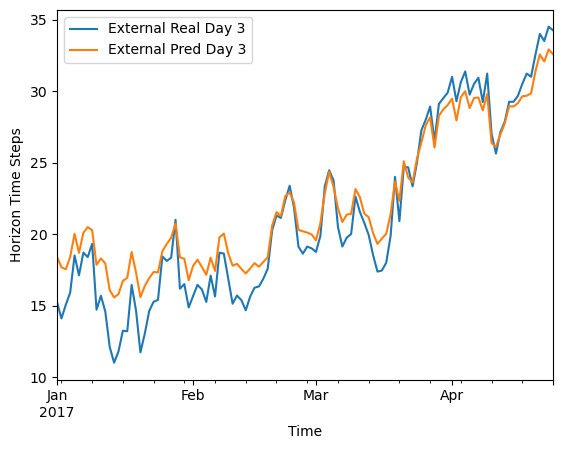

<Figure size 3000x1000 with 0 Axes>

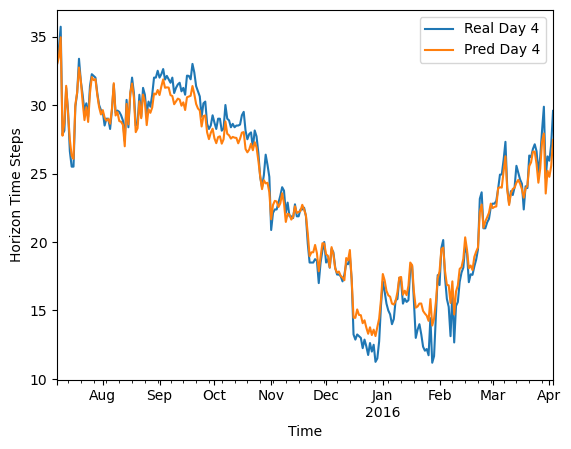

<Figure size 3000x1000 with 0 Axes>

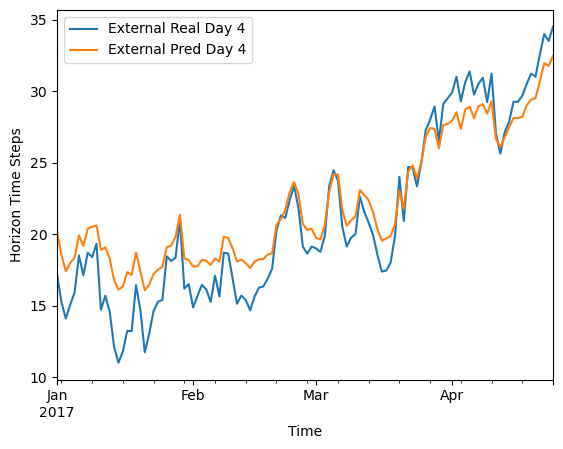

<Figure size 3000x1000 with 0 Axes>

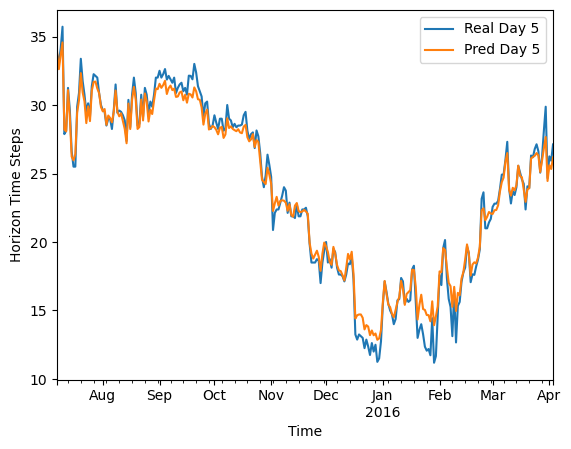

<Figure size 3000x1000 with 0 Axes>

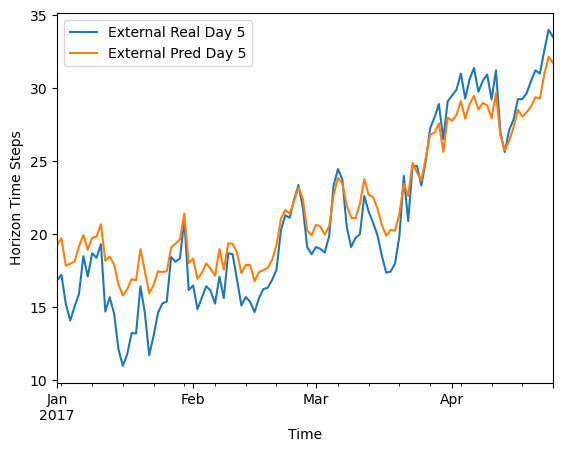

<Figure size 3000x1000 with 0 Axes>

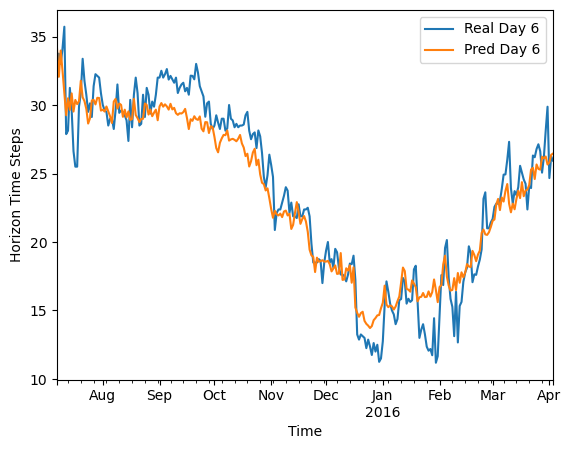

<Figure size 3000x1000 with 0 Axes>

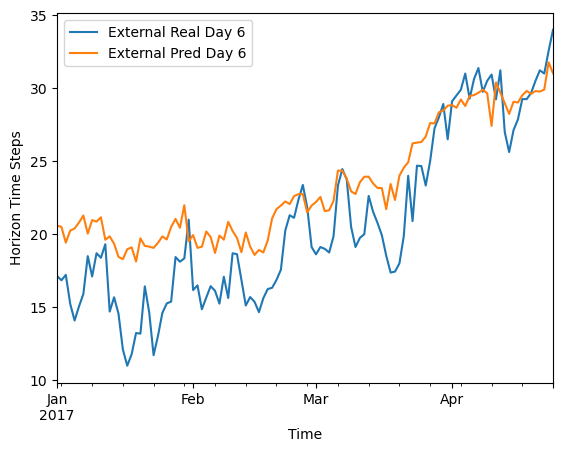

<Figure size 3000x1000 with 0 Axes>

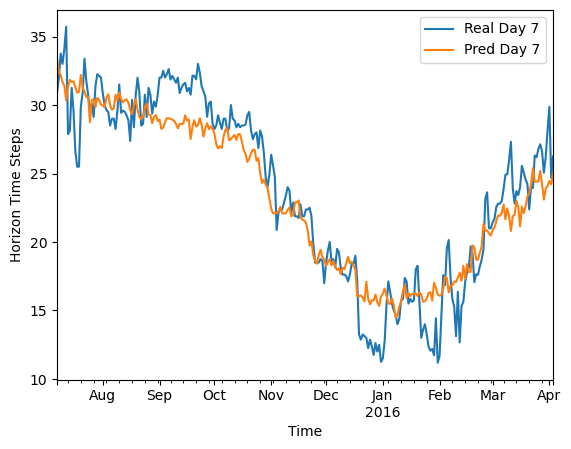

<Figure size 3000x1000 with 0 Axes>

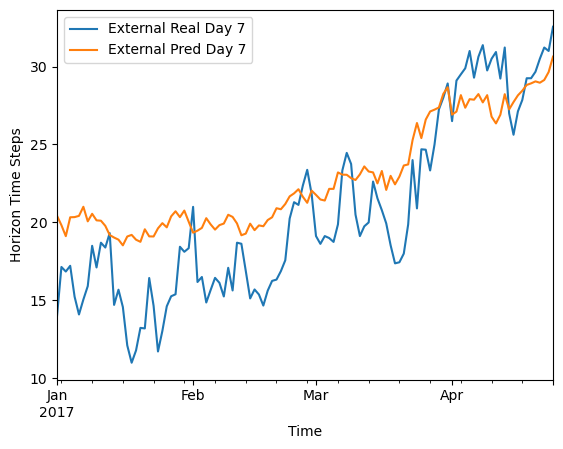

<Figure size 3000x1000 with 0 Axes>

Fold 3 Scores : {'RMSE': 1.6892158738379517, 'MAE': 1.3537961352657046, 'RMSLE': (0.0029801296420424546,), 'R-Squared': (0.9004510167911385,), 'Adj R-Squared': 0.8819302757290247, 'MAPE': 0.04483710567797278}
Fold 3 External Scores : {'RMSE': 1.7831703037655475, 'MAE': 1.3752612113941605, 'RMSLE': (0.009373248246005697,), 'R-Squared': (0.9077498941394594,), 'Adj R-Squared': 0.9016579060165935, 'MAPE': 0.07875706849094032}
Train Start-End: 2014-01-08 00:00:00 - 2016-04-03 00:00:00
Validation Start-End: 2016-04-04 00:00:00 - 2016-12-31 00:00:00


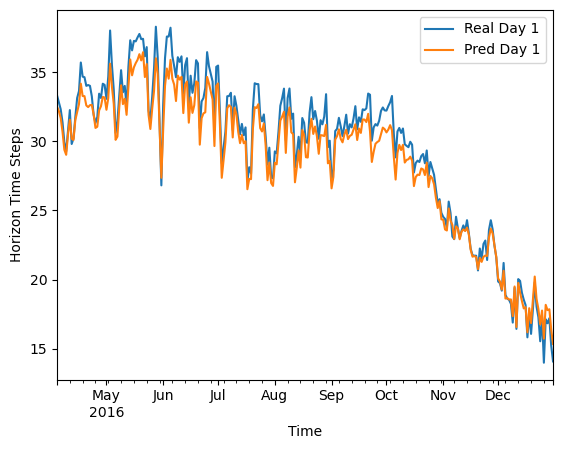

<Figure size 3000x1000 with 0 Axes>

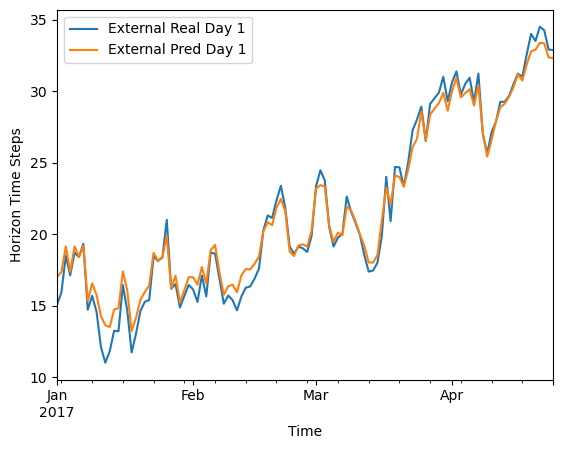

<Figure size 3000x1000 with 0 Axes>

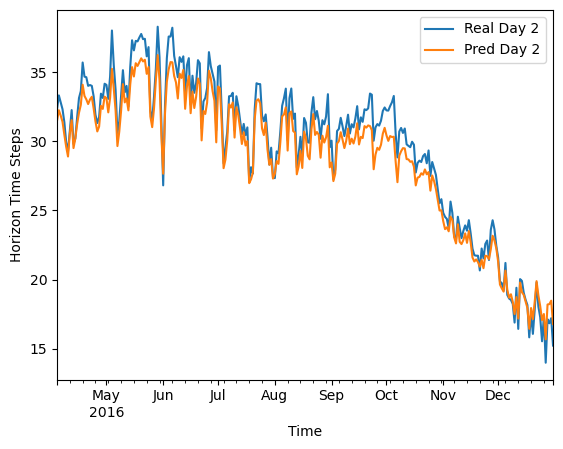

<Figure size 3000x1000 with 0 Axes>

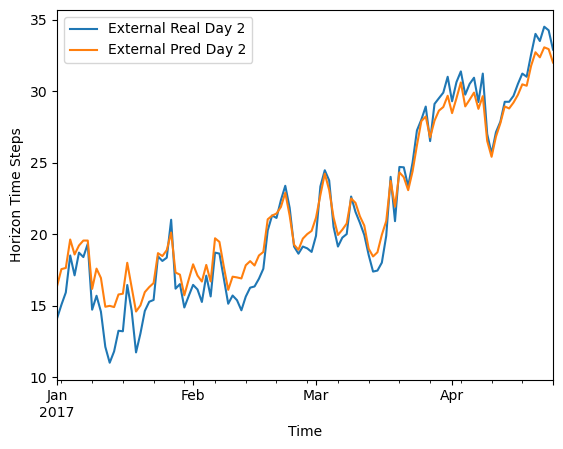

<Figure size 3000x1000 with 0 Axes>

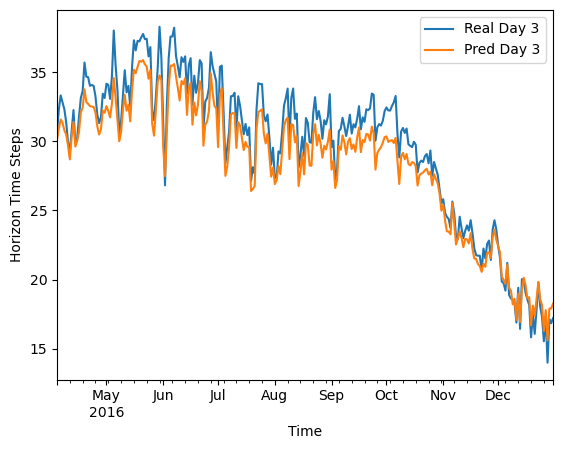

<Figure size 3000x1000 with 0 Axes>

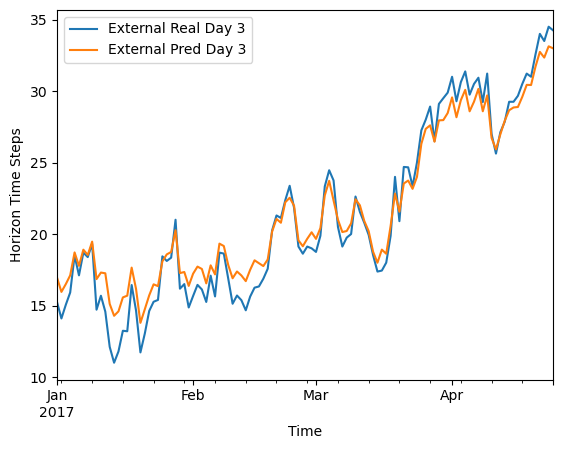

<Figure size 3000x1000 with 0 Axes>

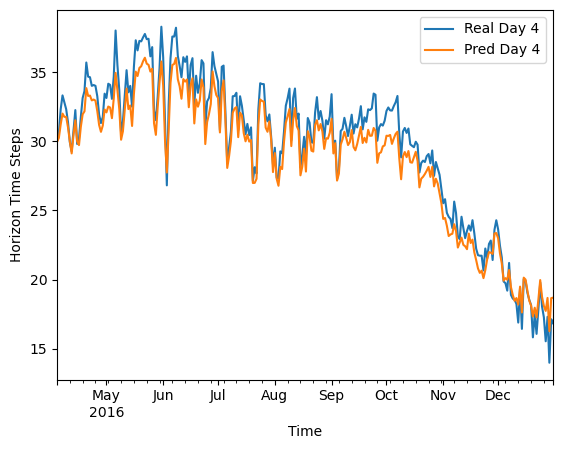

<Figure size 3000x1000 with 0 Axes>

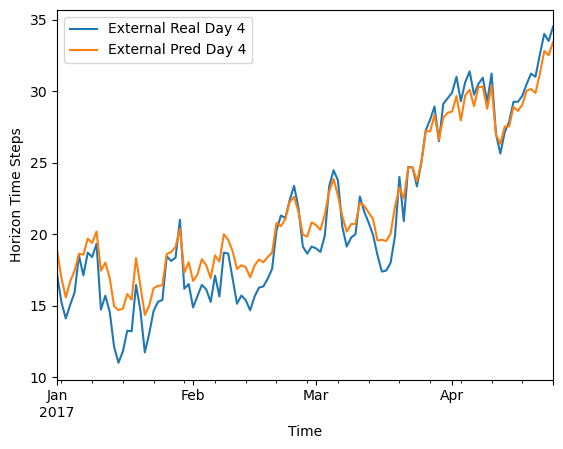

<Figure size 3000x1000 with 0 Axes>

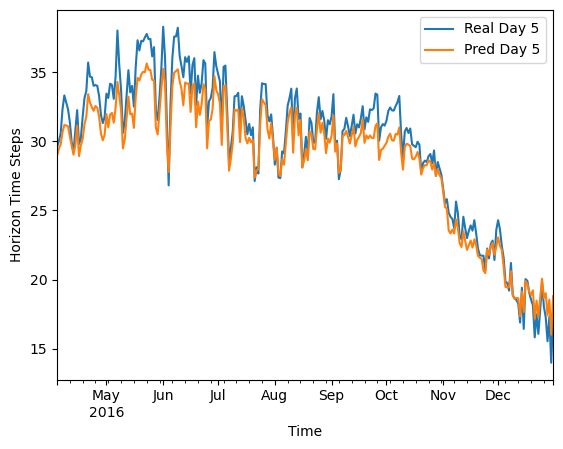

<Figure size 3000x1000 with 0 Axes>

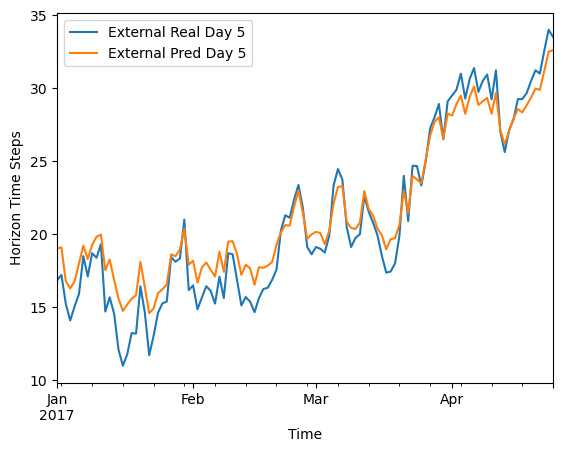

<Figure size 3000x1000 with 0 Axes>

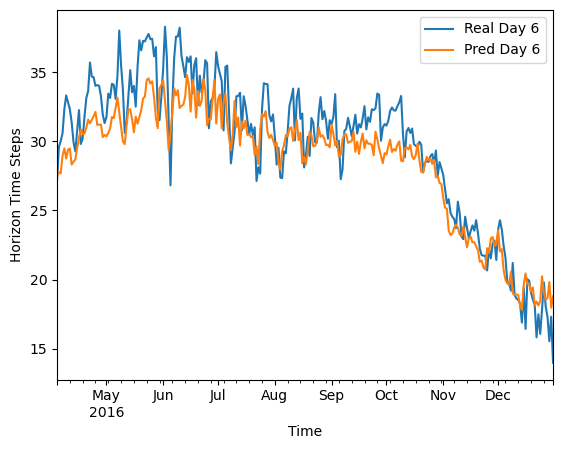

<Figure size 3000x1000 with 0 Axes>

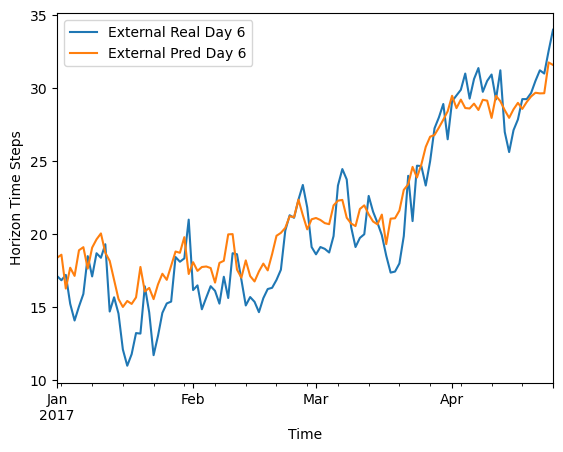

<Figure size 3000x1000 with 0 Axes>

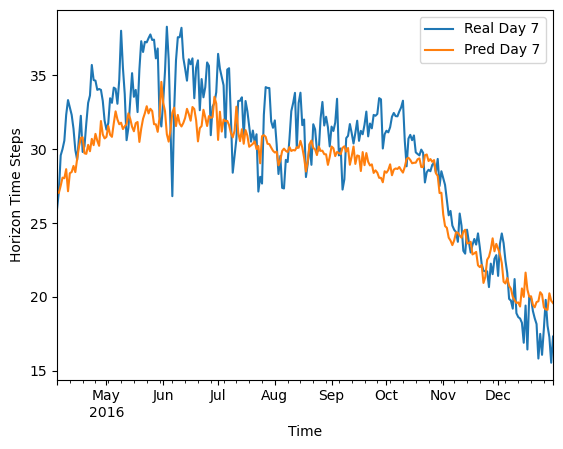

<Figure size 3000x1000 with 0 Axes>

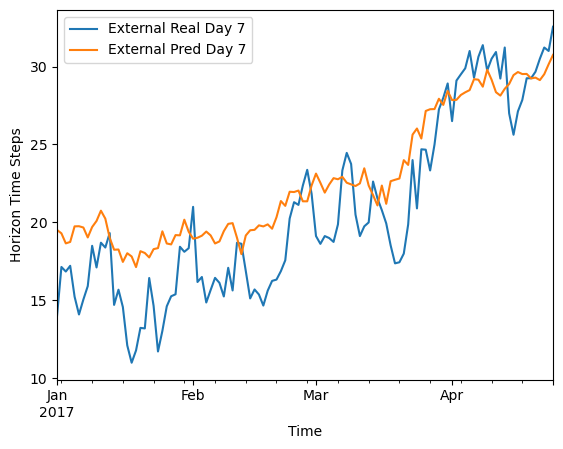

<Figure size 3000x1000 with 0 Axes>

In [84]:
alg = CatBoostRegressor(random_state=42,verbose=0)
train_and_visualization(X,y,external_y,external_final_data,fold_list,horizon,num_cols,cat_cols,frequency,alg)